# 25/26 KM6312 Report Analysis Group Five Guys

In [ ]:
1.Data collection

In [1]:
pip install DrissionPage

   ---------------------------------------- 257.5/257.5 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 107.4/107.4 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: tldextract
    Found existing installation: tldextract 3.2.0
    Uninstalling tldextract-3.2.0:
      Successfully uninstalled tldextract-3.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
from DrissionPage import ChromiumPage
from pprint import pprint

In [4]:
import csv
import json
from DrissionPage import ChromiumPage

f = open(file='data.csv', mode='w', encoding='utf-8', newline='')

csv_writer = csv.DictWriter(f, fieldnames=[
    '职位',
    '城市',
    '区域',
    '商圈',
    '公司',
    '薪资',
    '经验',
    '学历',
    '领域',
    '性质',
    '规模',
    '技能标签',
    '福利标签',
])

csv_writer.writeheader()

dp = ChromiumPage()

dp.listen.start('zpgeek/search/joblist.json')
dp.get('https://www.zhipin.com/web/geek/job?query=python&city=101290100')

for page in range(1, 30):
    print(f'正在采集第{page}页的数据内容')
    dp.scroll.to_bottom()
    r = dp.listen.wait()

    body = r.response.body

    if isinstance(body, bytes):
        body = body.decode('utf-8')   # 解码

    if isinstance(body, str):
        try:
            json_data = json.loads(body)   # 解析 JSON
        except Exception as e:
            print('JSON 解析失败：', e)
            print('返回内容前200字符：', body[:200])
            continue
    elif isinstance(body, dict):
        json_data = body
    else:
        print('未知 body 类型：', type(body))
        continue

    try:
        jobList = json_data['zpData']['jobList']
    except KeyError as e:
        print('关键字段不存在：', e)
        print('json_data keys:', json_data.keys())
        continue

    for job in jobList:
        dit = {
            '职位': job.get('jobName', ''),
            '城市': job.get('cityName', ''),
            '区域': job.get('areaDistrict', ''),
            '商圈': job.get('businessDistrict', ''),
            '公司': job.get('brandName', ''),
            '薪资': job.get('salaryDesc', ''),
            '经验': job.get('jobExperience', ''),
            '学历': job.get('jobDegree', ''),
            '领域': job.get('brandIndustry', ''),
            '性质': job.get('brandStageName', ''),
            '规模': job.get('brandScaleName', ''),
            '技能标签': ' '.join(job.get('skills', [])),
            '福利标签': ' '.join(job.get('welfareList', [])),
        }

        csv_writer.writerow(dit)
        print(dit)

    dp.scroll.to_bottom()


正在采集第1页的数据内容
{'职位': 'python程序员', '城市': '昆明', '区域': '西山区', '商圈': '前卫', '公司': '昆明拓肆纬科技', '薪资': '3-5K', '经验': '1-3年', '学历': '本科', '领域': '计算机软件', '性质': '', '规模': '0-20人', '技能标签': 'PostgreSQL Pandas MySQL MongoDB Python', '福利标签': ''}
{'职位': '高级python开发工程师', '城市': '昆明', '区域': '西山区', '商圈': '前卫', '公司': '岩创科技', '薪资': '7-12K', '经验': '3-5年', '学历': '本科', '领域': '大数据', '性质': '未融资', '规模': '0-20人', '技能标签': 'PyTorch Docker MySQL 机器学习经验 接受无前端经验/技能 MongoDB 其他 架构设计经验 Python Flask TensorFlow', '福利标签': '全勤奖 包住 生日福利 年终奖 带薪年假 交通补助 节日福利 五险'}
{'职位': 'Python开发（AI方向）', '城市': '昆明', '区域': '盘龙区', '商圈': '人民东路', '公司': '松赞绿谷', '薪资': '8-13K', '经验': '3-5年', '学历': '本科', '领域': '旅游/景区', '性质': '未融资', '规模': '1000-9999人', '技能标签': 'Python PyTorch TensorFlow Flask Django Linux开发/部署经验 LLM AI Agent Shell脚本编写', '福利标签': '意外险 餐补 宿舍有空调 年终奖 包吃 团建聚餐 有无线网 绩效奖金 包住 节日福利 员工旅游 带薪年假 免费工装 零食下午茶 定期体检 五险一金 生日福利'}
{'职位': 'Python开发工程师', '城市': '昆明', '区域': '五华区', '商圈': '龙泉', '公司': '慧科信息', '薪资': '6-10K', '经验': '3-5年', '学历': '本科', '领域': '计算机软件', '性质':

KeyboardInterrupt: 

2.Data cleaning

In [79]:
import pandas as pd

df = pd.read_csv("merged.csv")

df = df[df['薪资'] != '面议']
df = df[~df['职位'].str.contains('实习', case=False, na=False)]

df = df.reset_index(drop=True)

df.to_csv("cleaned_merged.csv", index=False)

print("save as cleaned_merged.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'merged.csv'

In [80]:
import pandas as pd
import re

df = pd.read_csv("cleaned_merged.csv")


def parse_salary(s):
    if pd.isna(s):
        return pd.Series([None, None, None])

    text = str(s).lower().replace("／", "/").replace("每月", "/月").replace("月薪", "/月")

    
    if "面议" in text or text.strip() == "":
        return pd.Series([None, None, None])

    
    match = re.findall(r"(\d+\.?\d*)\s*[-~—－–至]?\s*(\d+\.?\d*)?\s*k", text)
    if match:
        low, high = match[0]
        low = float(low)
        high = float(high) if high else low
        avg = (low + high) / 2 * 1000  
    else:
        avg = None

    
    if "年" in text:
        avg = (avg or 0) / 12  

    
    bonus_match = re.search(r"(\d+)\s*薪", text)
    bonus = int(bonus_match.group(1)) if bonus_match else 12

    
    annual = (avg or 0) * bonus

    return pd.Series([avg, annual, bonus])

 
df[["monthly_salary_avg", "annual_salary_equiv", "bonus_months"]] = df["薪资"].apply(parse_salary)


df.to_csv("adjusted_salary.csv", index=False)

print("save as adjusted_salary.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_merged.csv'

In [81]:
import pandas as pd
import numpy as np


df = pd.read_csv("adjusted_salary.csv")

df = df.dropna(subset=["monthly_salary_avg", "annual_salary_equiv"])
df = df[(df["monthly_salary_avg"] != 0) & (df["annual_salary_equiv"] != 0)]

df = df.reset_index(drop=True)

df.to_csv("final_salary_cleaned.csv", index=False, encoding="utf-8-sig")

print("save as final_salary_cleaned.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'adjusted_salary.csv'

In [82]:
import pandas as pd

df = pd.read_csv("final_salary_cleaned.csv")

df = df.sort_values(by="monthly_salary_avg", ascending=False)

df = df.reset_index(drop=True)

df.to_csv("final_salary_sorted.csv", index=False, encoding="utf-8-sig")

print("save as final_salary_sorted.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'final_salary_cleaned.csv'

# 3. data processing

In [6]:
import importlib
import pandas as pd
importlib.reload(pd)
import pandas as pd

df = pd.read_csv("coded_factors.csv")

df['city'] = df['city'].astype(str)
df['size(employees_number)'] = df['size(employees_number)'].astype(int)
print('basic data information：')
df.info()

rows, columns = df.shape

if rows < 100 and columns < 20:
    
    print('all data content information：')
    print(df.to_csv(sep='\t', na_rep='nan'))
else:
    
    print('top lines data information：')
    print(df.head().to_csv(sep='\t', na_rep='nan'))

basic data information：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position_category       1665 non-null   object 
 1   city                    1665 non-null   object 
 2   experience_atleast      1665 non-null   int64  
 3   education               1665 non-null   float64
 4   nature                  1665 non-null   object 
 5   size(employees_number)  1665 non-null   int32  
 6   benifit                 1665 non-null   int64  
 7   monthly_salary_avg      1665 non-null   int64  
 8   annual_salary_equiv     1665 non-null   int64  
 9   bonus_months            1665 non-null   int64  
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 123.7+ KB
top lines data information：
	position_category	city	experience_atleast	education	nature	size(employees_number)	benifit	monthly_salary_avg	annual_salary_equiv	b

In [50]:
# conda install -c conda-forge category_encoders

In [9]:
import importlib
import pandas as pd
importlib.reload(pd)
import pandas as pd

df = pd.read_csv("coded_factors.csv")
import re 
def city_function(city_name):
    """
    对应Excel中的：City=IFS(F2="杭州",4,F2="上海",6,F2="广州",3,F2="郑州",8,F2="北京",1,F2="黄冈",5,F2="深圳",7,F2="成都",2)
    """
    city_mapping = {
        "杭州": 4, "上海": 6, "广州": 3, "郑州": 8,
        "北京": 1, "黄冈": 5, "深圳": 7, "成都": 2
    }
    return city_mapping.get(city_name, 0)  

def experience_function(experience_str):
    """
    对应Excel中的：Experience=IF(OR(K2="经验不限",K2="在校/应届"),0,IF(K2="5-10年",5,IF(K2="3-5年",3,IF(K2="1-3年",1,IF(K2="1年以内",1,IF(K2="10年以上",10))))))
    """
    if pd.isna(experience_str) or experience_str in ["经验不限", "在校/应届"]:
        return 0
    elif experience_str == "5-10年":
        return 5
    elif experience_str == "3-5年":
        return 3
    elif experience_str in ["1-3年", "1年以内"]:
        return 1
    elif experience_str == "10年以上":
        return 10
    else:
        return 0 

def education_function(education_str):
    """
    对应Excel中的：Education=IFS(M2="本科",1,M2="学历不限",0,M2="硕士",2,M2="大专",0.5)
    """
    education_mapping = {
        "本科": 1,
        "学历不限": 0,
        "硕士": 2,
        "大专": 0.5
    }
    return education_mapping.get(education_str, 0) 

def nature_function(nature_str):
    """
    对应Excel中的：Nature=IF(Q2="不需要融资",1,IF(Q2="已上市",2,0))
    """
    if nature_str == "不需要融资":
        return 1
    elif nature_str == "已上市":
        return 2
    else:
        return 0

def size_function(size_str):
    """
    对应Excel中的：Size=提取数字部分
    从字符串中提取数字（如从"100-499人"中提取100和499）
    """
    if pd.isna(size_str):
        return 0
    
   
    numbers = re.findall(r'\d+', str(size_str))
    
    if numbers:
        
        numbers = [int(num) for num in numbers]
        return sum(numbers) / len(numbers)
    else:
        return 0

def benefit_function(benefit_list):
    """
    对应Excel中的：Benefit=COUNTA(U2:AO2)
    计算非空值的数量
    """
    if isinstance(benefit_list, (list, tuple, pd.Series)):
        return sum(1 for item in benefit_list if pd.notna(item) and item != "")
    else:
        return 1 if pd.notna(benefit_list) and benefit_list != "" else 0

In [10]:
df = pd.read_csv("coded_factors.csv")

df['city'] = df['city'].astype(str)
df['size(employees_number)'] = df['size(employees_number)'].astype(int)
print('data basic content information：')
df.info()

rows, columns = df.shape


if rows < 100 and columns < 20:
    
    print('all data information：')
    print(df.to_csv(sep='\t', na_rep='nan'))
else:
    
    print('top lines data information：')
    print(df.head().to_csv(sep='\t', na_rep='nan'))

data basic content information：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position_category       1665 non-null   object 
 1   city                    1665 non-null   object 
 2   experience_atleast      1665 non-null   int64  
 3   education               1665 non-null   float64
 4   nature                  1665 non-null   object 
 5   size(employees_number)  1665 non-null   int32  
 6   benifit                 1665 non-null   int64  
 7   monthly_salary_avg      1665 non-null   int64  
 8   annual_salary_equiv     1665 non-null   int64  
 9   bonus_months            1665 non-null   int64  
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 123.7+ KB
top lines data information：
	position_category	city	experience_atleast	education	nature	size(employees_number)	benifit	monthly_salary_avg	annual_salary

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.dpi'] = 300


X = df.drop(['monthly_salary_avg', 'annual_salary_equiv'], axis=1)
y_monthly = df['monthly_salary_avg']
y_annual = df['annual_salary_equiv']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()


fig, axes = plt.subplots(nrows=len(X.columns), ncols=2, figsize=(15, 5 * len(X.columns)))


for i, col in enumerate(X.columns):
    if col in categorical_cols:
        sns.boxplot(x=col, y=y_monthly, data=df, ax=axes[i, 0])
        axes[i, 0].set_title(f'{col} 与月薪的关系')
    else:
        sns.scatterplot(x=col, y=y_monthly, data=df, ax=axes[i, 0])
        axes[i, 0].set_title(f'{col} 与月薪的关系')


for i, col in enumerate(X.columns):
    if col in categorical_cols:
        sns.boxplot(x=col, y=y_annual, data=df, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col} 与年薪的关系')
    else:
        sns.scatterplot(x=col, y=y_annual, data=df, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col} 与年薪的关系')

plt.tight_layout()
plt.show()

C:\Users\28160\AppData\Local\Temp\ipykernel_28352\3548911677.py:37: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  plt.tight_layout()
C:\Users\28160\AppData\Local\Temp\ipykernel_28352\3548911677.py:37: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  plt.tight_layout()
C:\Users\28160\AppData\Local\Temp\ipykernel_28352\3548911677.py:37: UserWarning: Glyph 34218 (\N{CJK UNIFIED IDEOGRAPH-85AA}) missing from current font.
  plt.tight_layout()
C:\Users\28160\AppData\Local\Temp\ipykernel_28352\3548911677.py:37: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\28160\AppData\Local\Temp\ipykernel_28352\3548911677.py:37: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  plt.tight_layout()
C:\Users\28160\AppData\Local\Temp\ipykernel_28352\3548911677.py:37: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) miss

In [16]:
csv_path = 'coded_factors_encoded1.csv'
df.to_csv(csv_path, index=False)
print(f'save as {csv_path}')

save as coded_factors_encoded1.csv


4. EDA

In [17]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [18]:
!pip install geopandas

     ---------------------------------------- 59.7/59.7 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 323.6/323.6 kB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 15.9/15.9 MB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 19.2/19.2 MB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 6.1/6.1 MB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 1.4/1.4 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have numpy 2.0.2 which is incompatible.


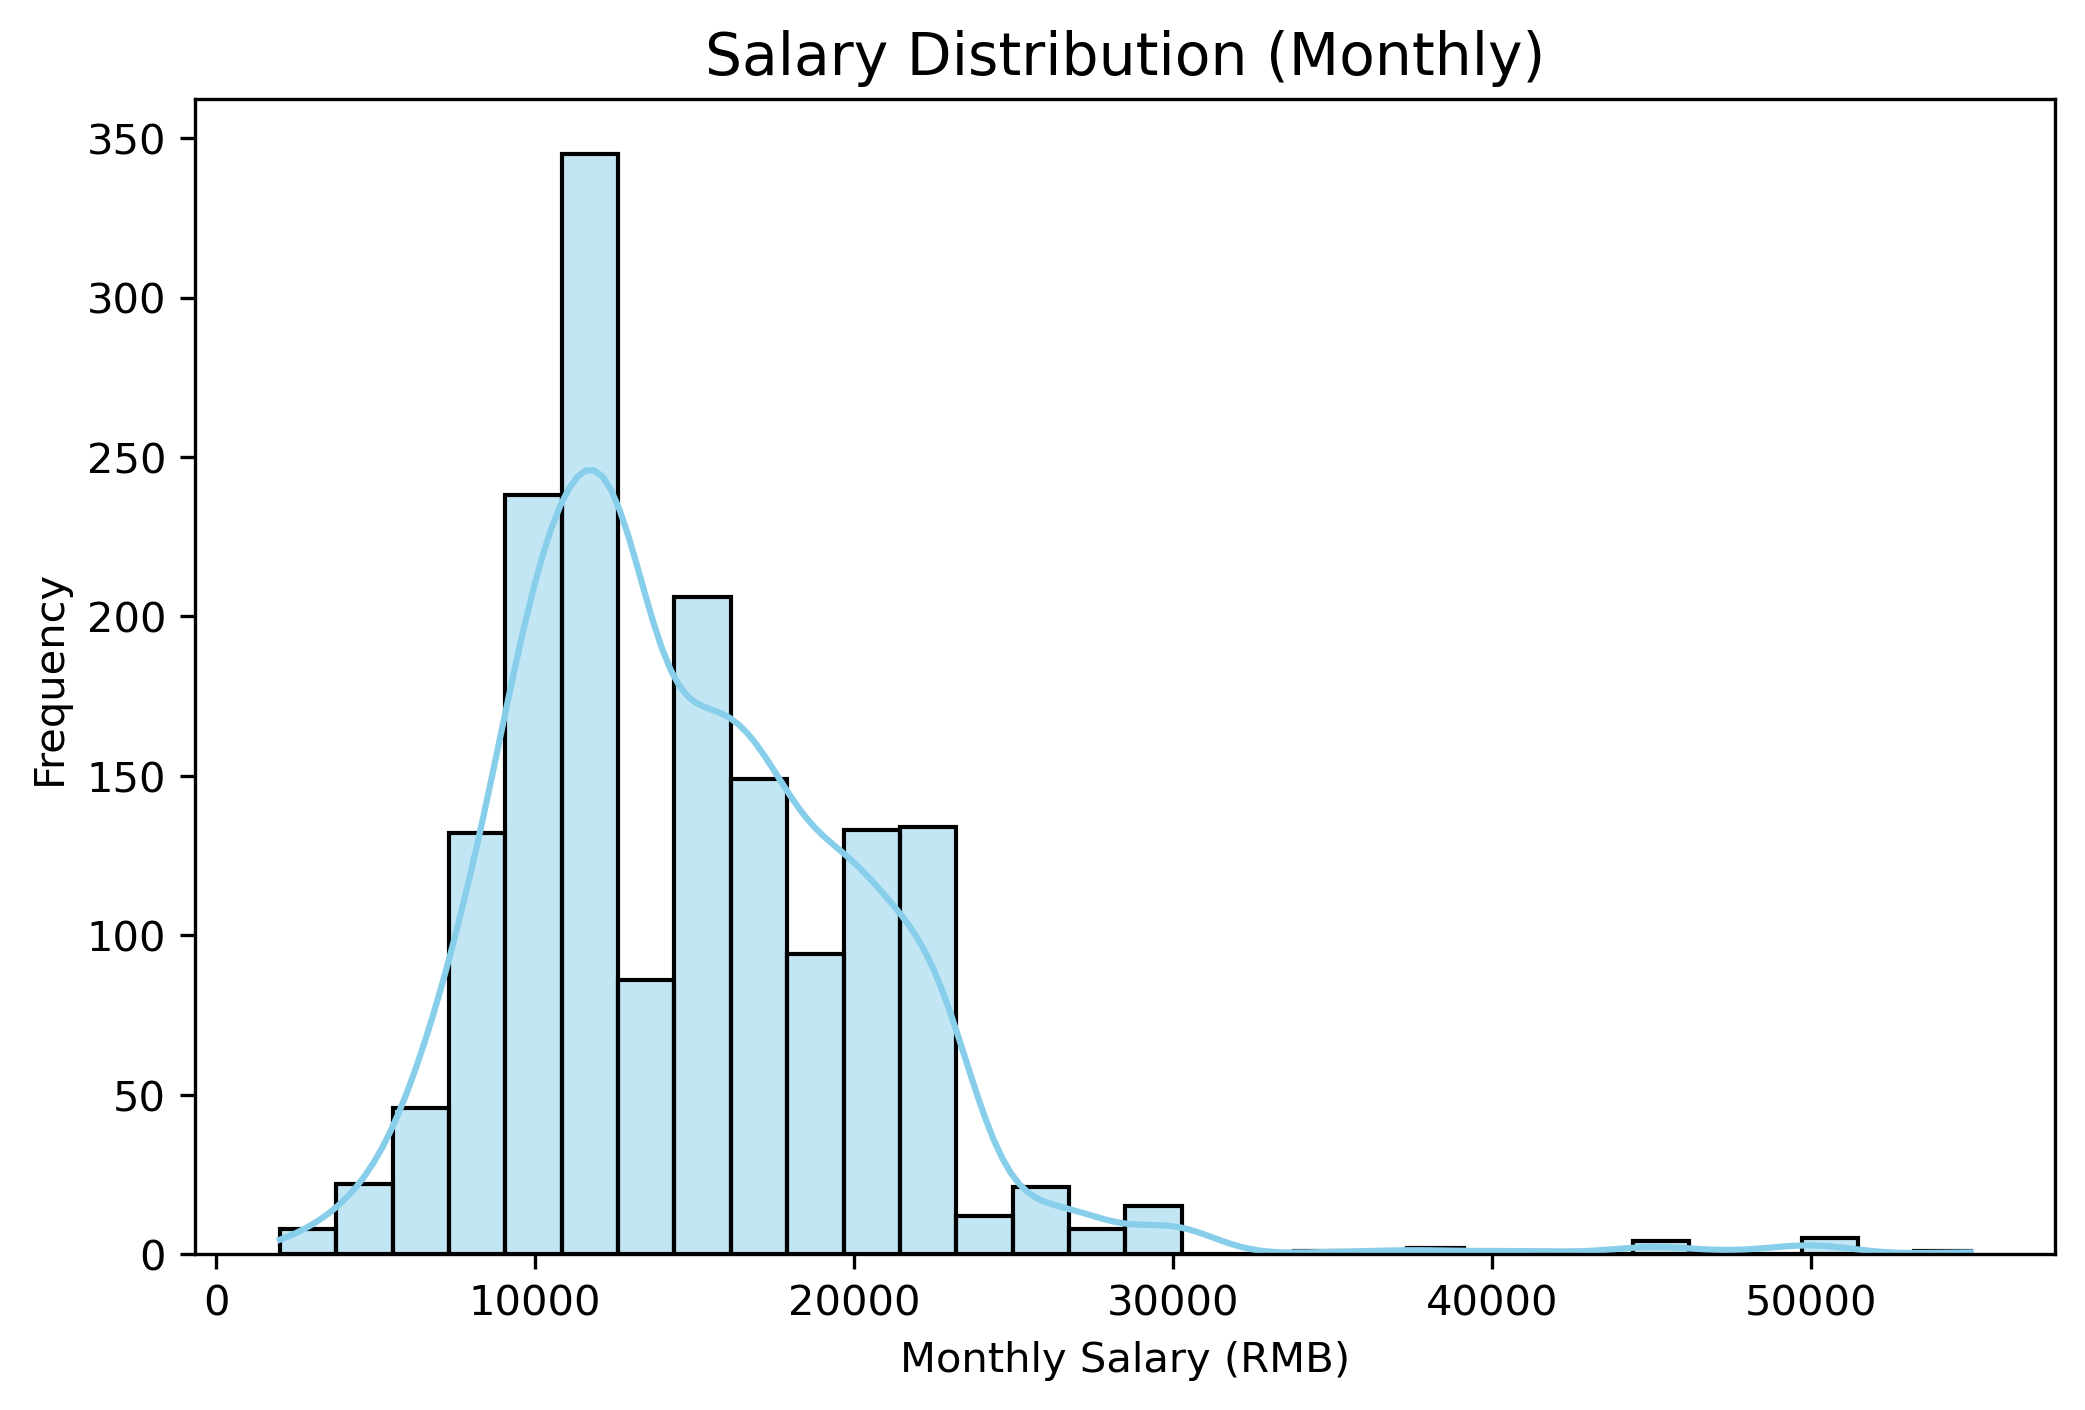

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("coded_factors.csv", encoding='utf-8')

plt.figure(figsize=(8,5))
sns.histplot(df['monthly_salary_avg'], kde=True, bins=30, color='skyblue')
plt.title("Salary Distribution (Monthly)", fontsize=14)
plt.xlabel("Monthly Salary (RMB)")
plt.ylabel("Frequency")
plt.show()

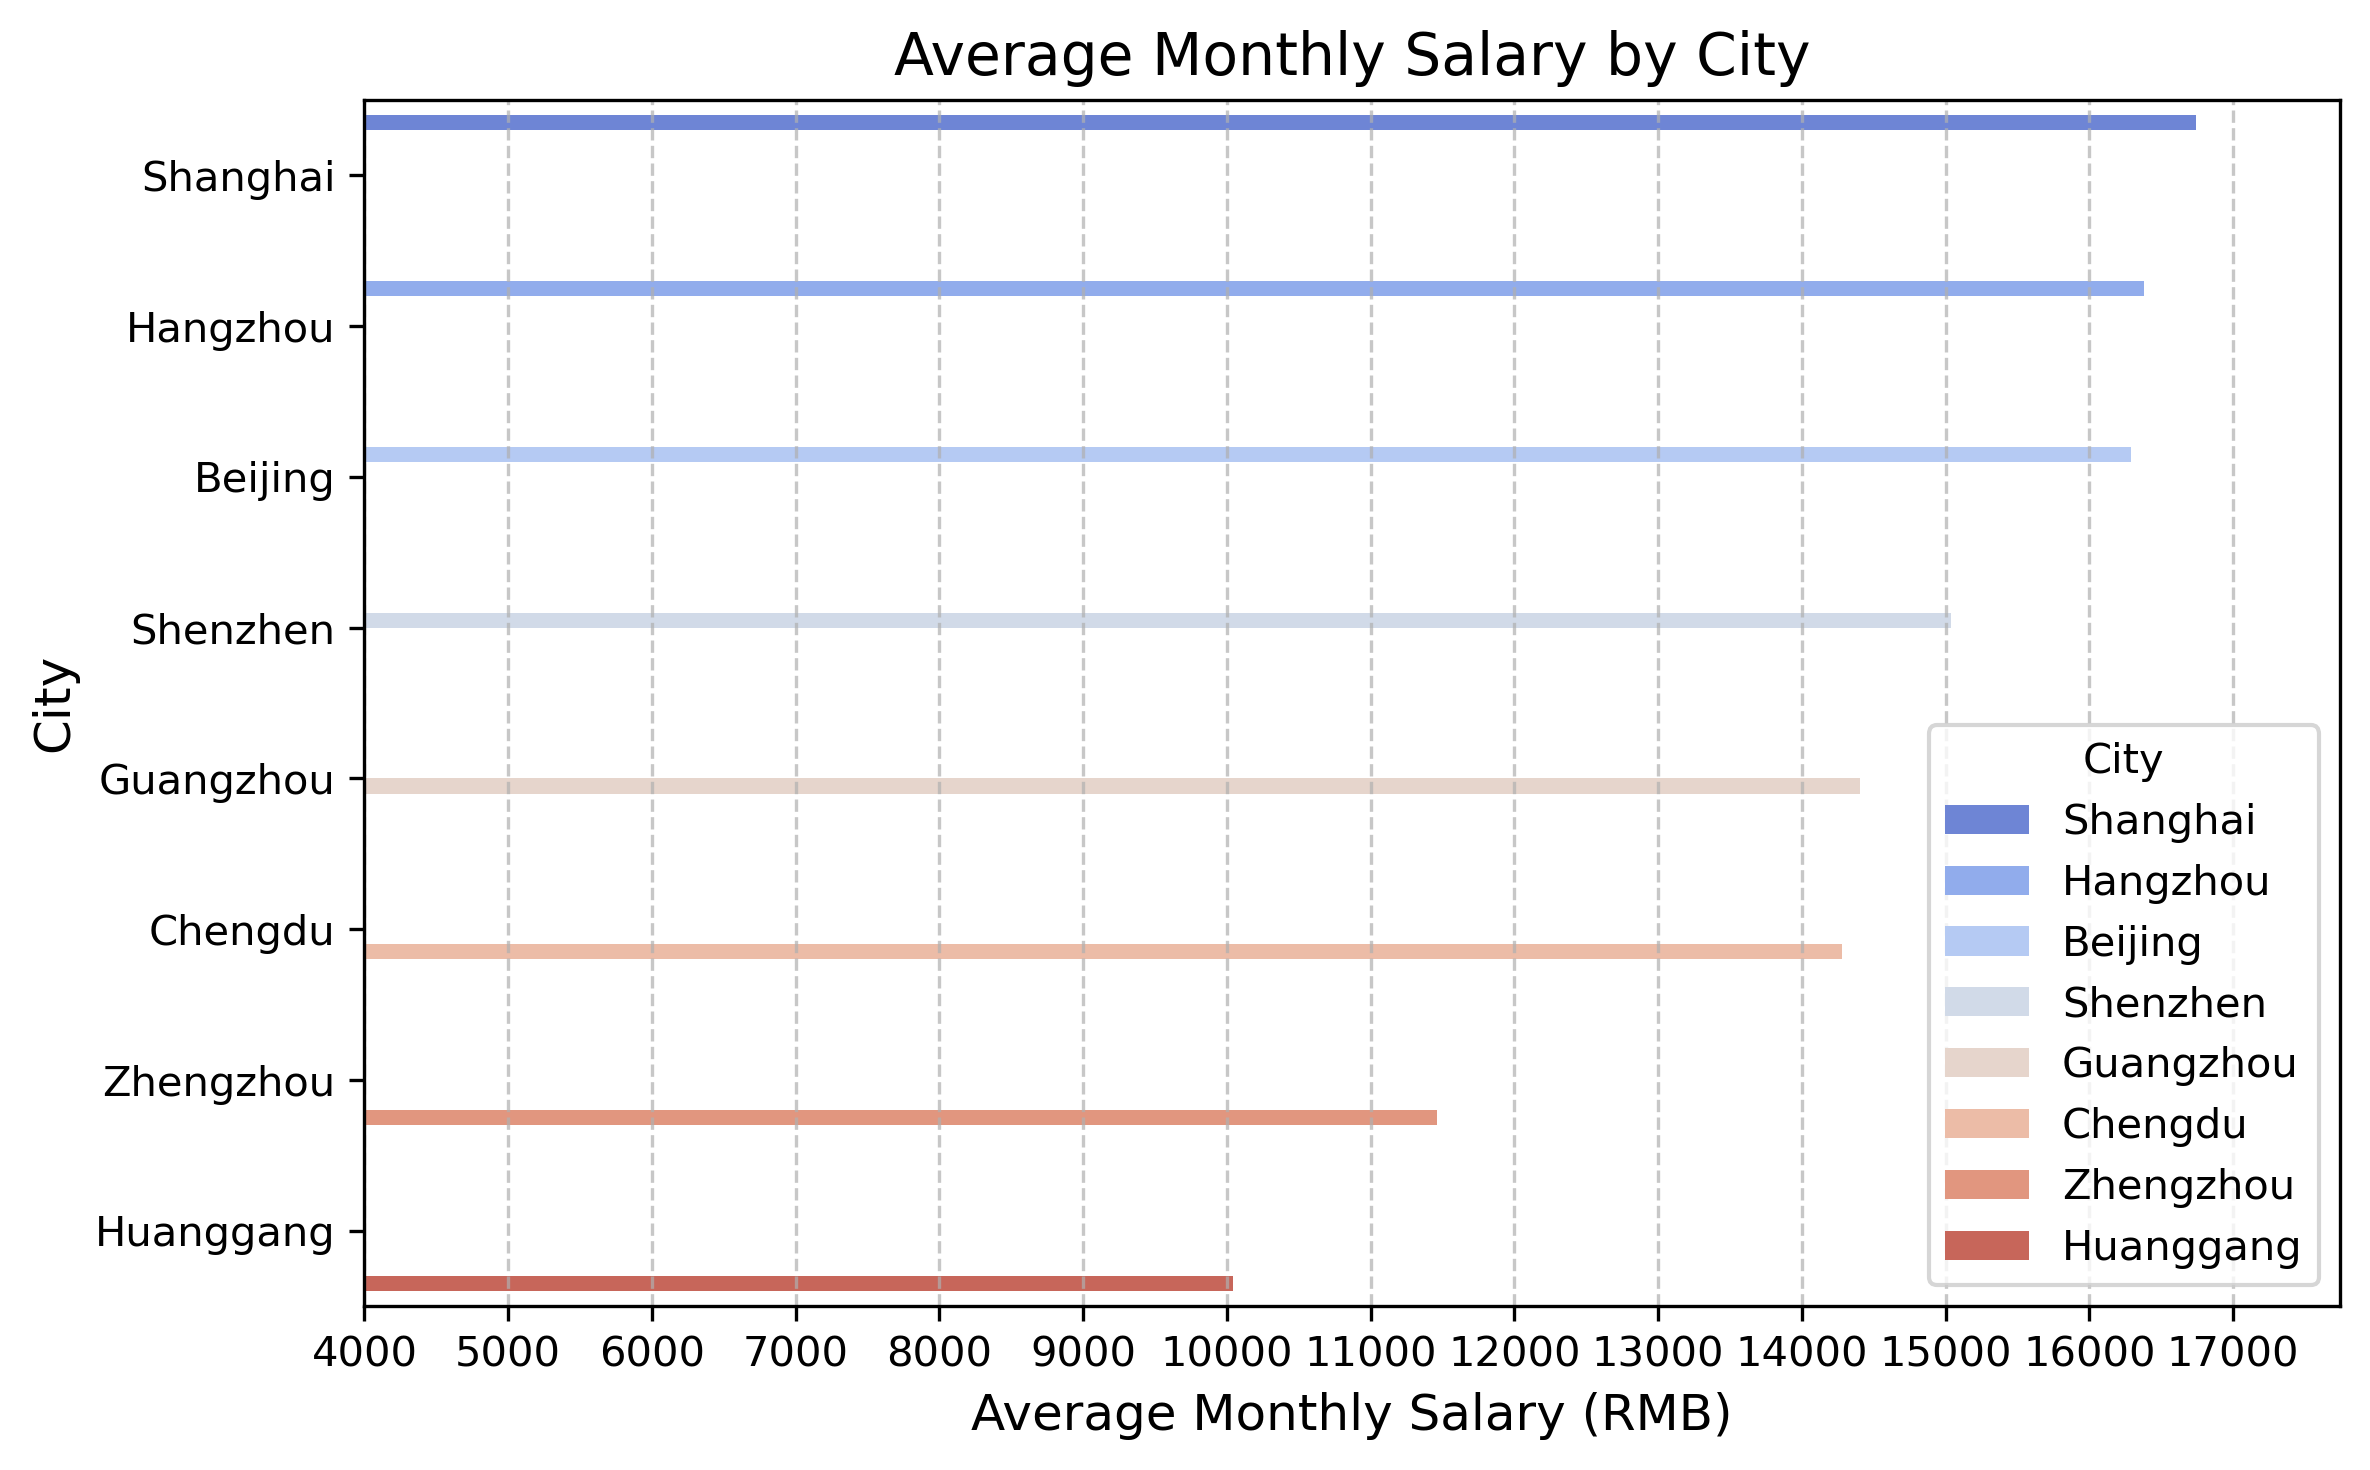

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("coded_factors.csv", encoding='utf-8')

city_map = {
    1: 'Beijing', 2: 'Chengdu', 3: 'Guangzhou',
    4: 'Hangzhou', 5: 'Huanggang', 6: 'Shanghai',
    7: 'Shenzhen', 8: 'Zhengzhou'
}
df['city_name'] = df['city'].map(city_map)

city_salary = df.groupby('city_name')['monthly_salary_avg'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(
    x='monthly_salary_avg',
    y='city_name',
    data=city_salary.sort_values('monthly_salary_avg', ascending=False),
    hue='city_name',
    palette='coolwarm',
)

plt.title("Average Monthly Salary by City", fontsize=14)
plt.xlabel("Average Monthly Salary (RMB)", fontsize=12)
plt.ylabel("City", fontsize=12)

plt.legend(title='City')

xmin, xmax = 4000, city_salary['monthly_salary_avg'].max() + 1000
plt.xlim(xmin, xmax)
plt.xticks(np.arange(xmin, xmax+1, 1000)) 

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

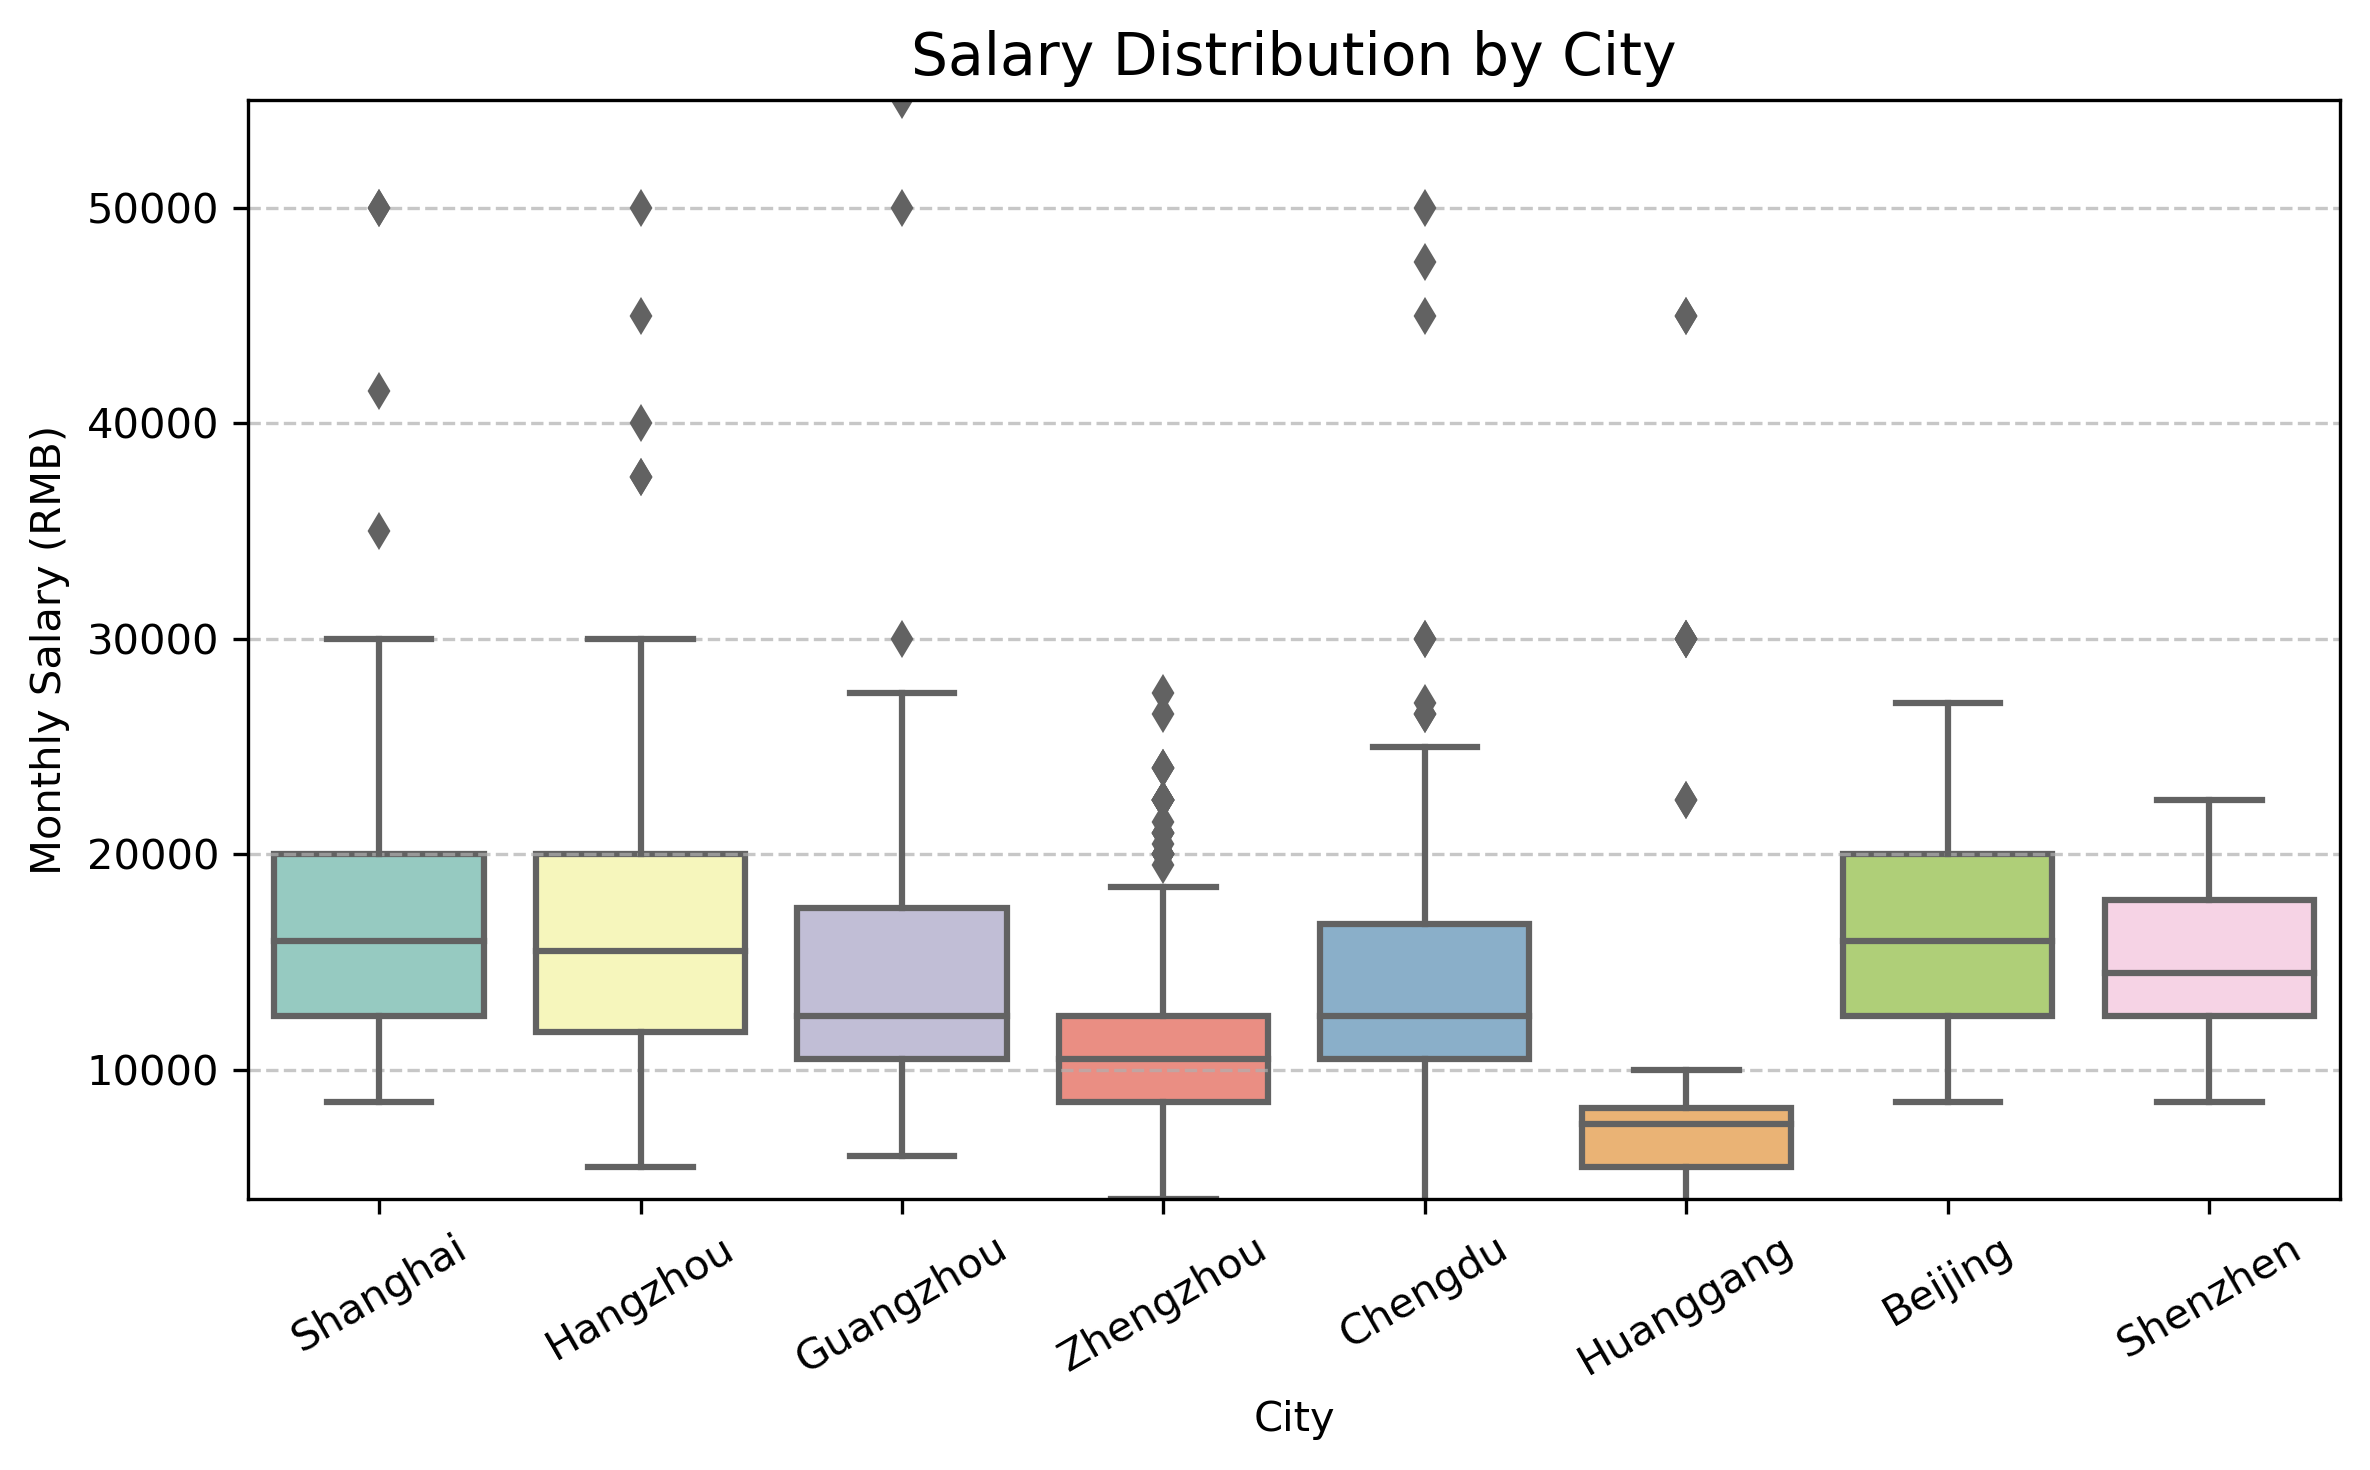

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x='city_name', y='monthly_salary_avg', data=df, palette='Set3')
plt.title("Salary Distribution by City", fontsize=14)
plt.xlabel("City")
plt.ylabel("Monthly Salary (RMB)")
plt.ylim(4000, df['monthly_salary_avg'].max()) 
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

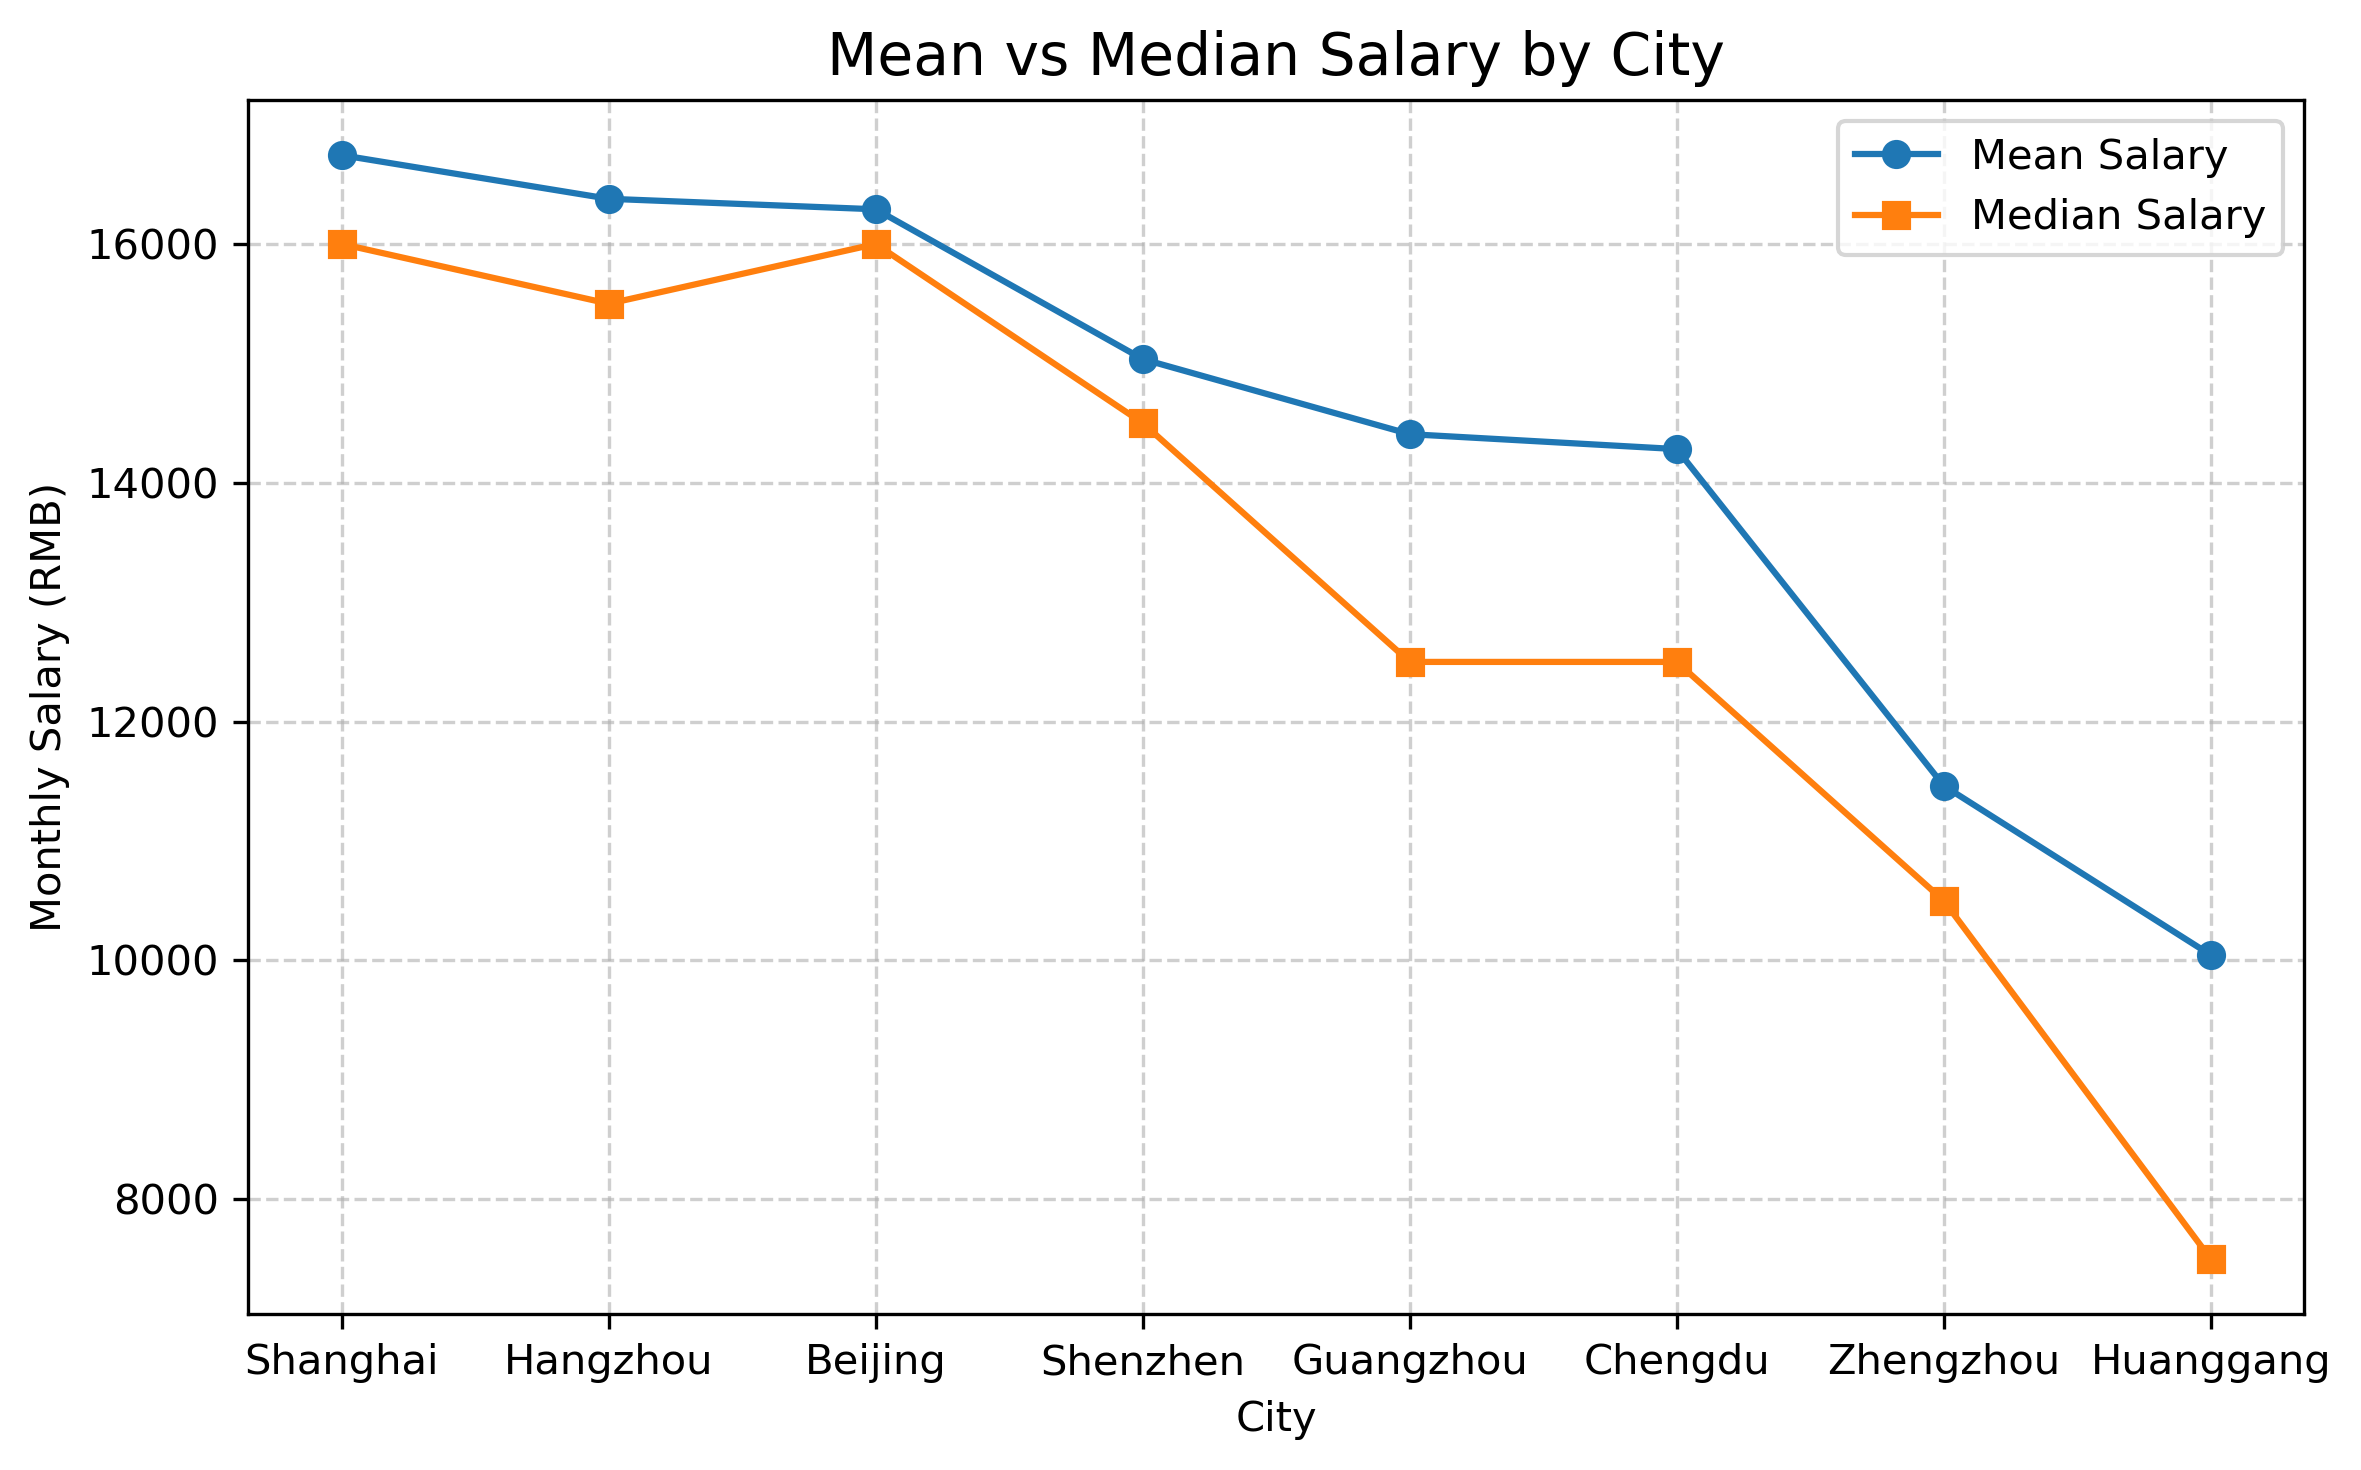

In [35]:
agg_city = df.groupby('city_name')['monthly_salary_avg'].agg(['mean','median']).reset_index()
agg_city = agg_city.sort_values('mean', ascending=False)

plt.figure(figsize=(8,5))
plt.plot(agg_city['city_name'], agg_city['mean'], marker='o', label='Mean Salary')
plt.plot(agg_city['city_name'], agg_city['median'], marker='s', label='Median Salary')
plt.title("Mean vs Median Salary by City", fontsize=14)
plt.xlabel("City")
plt.ylabel("Monthly Salary (RMB)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

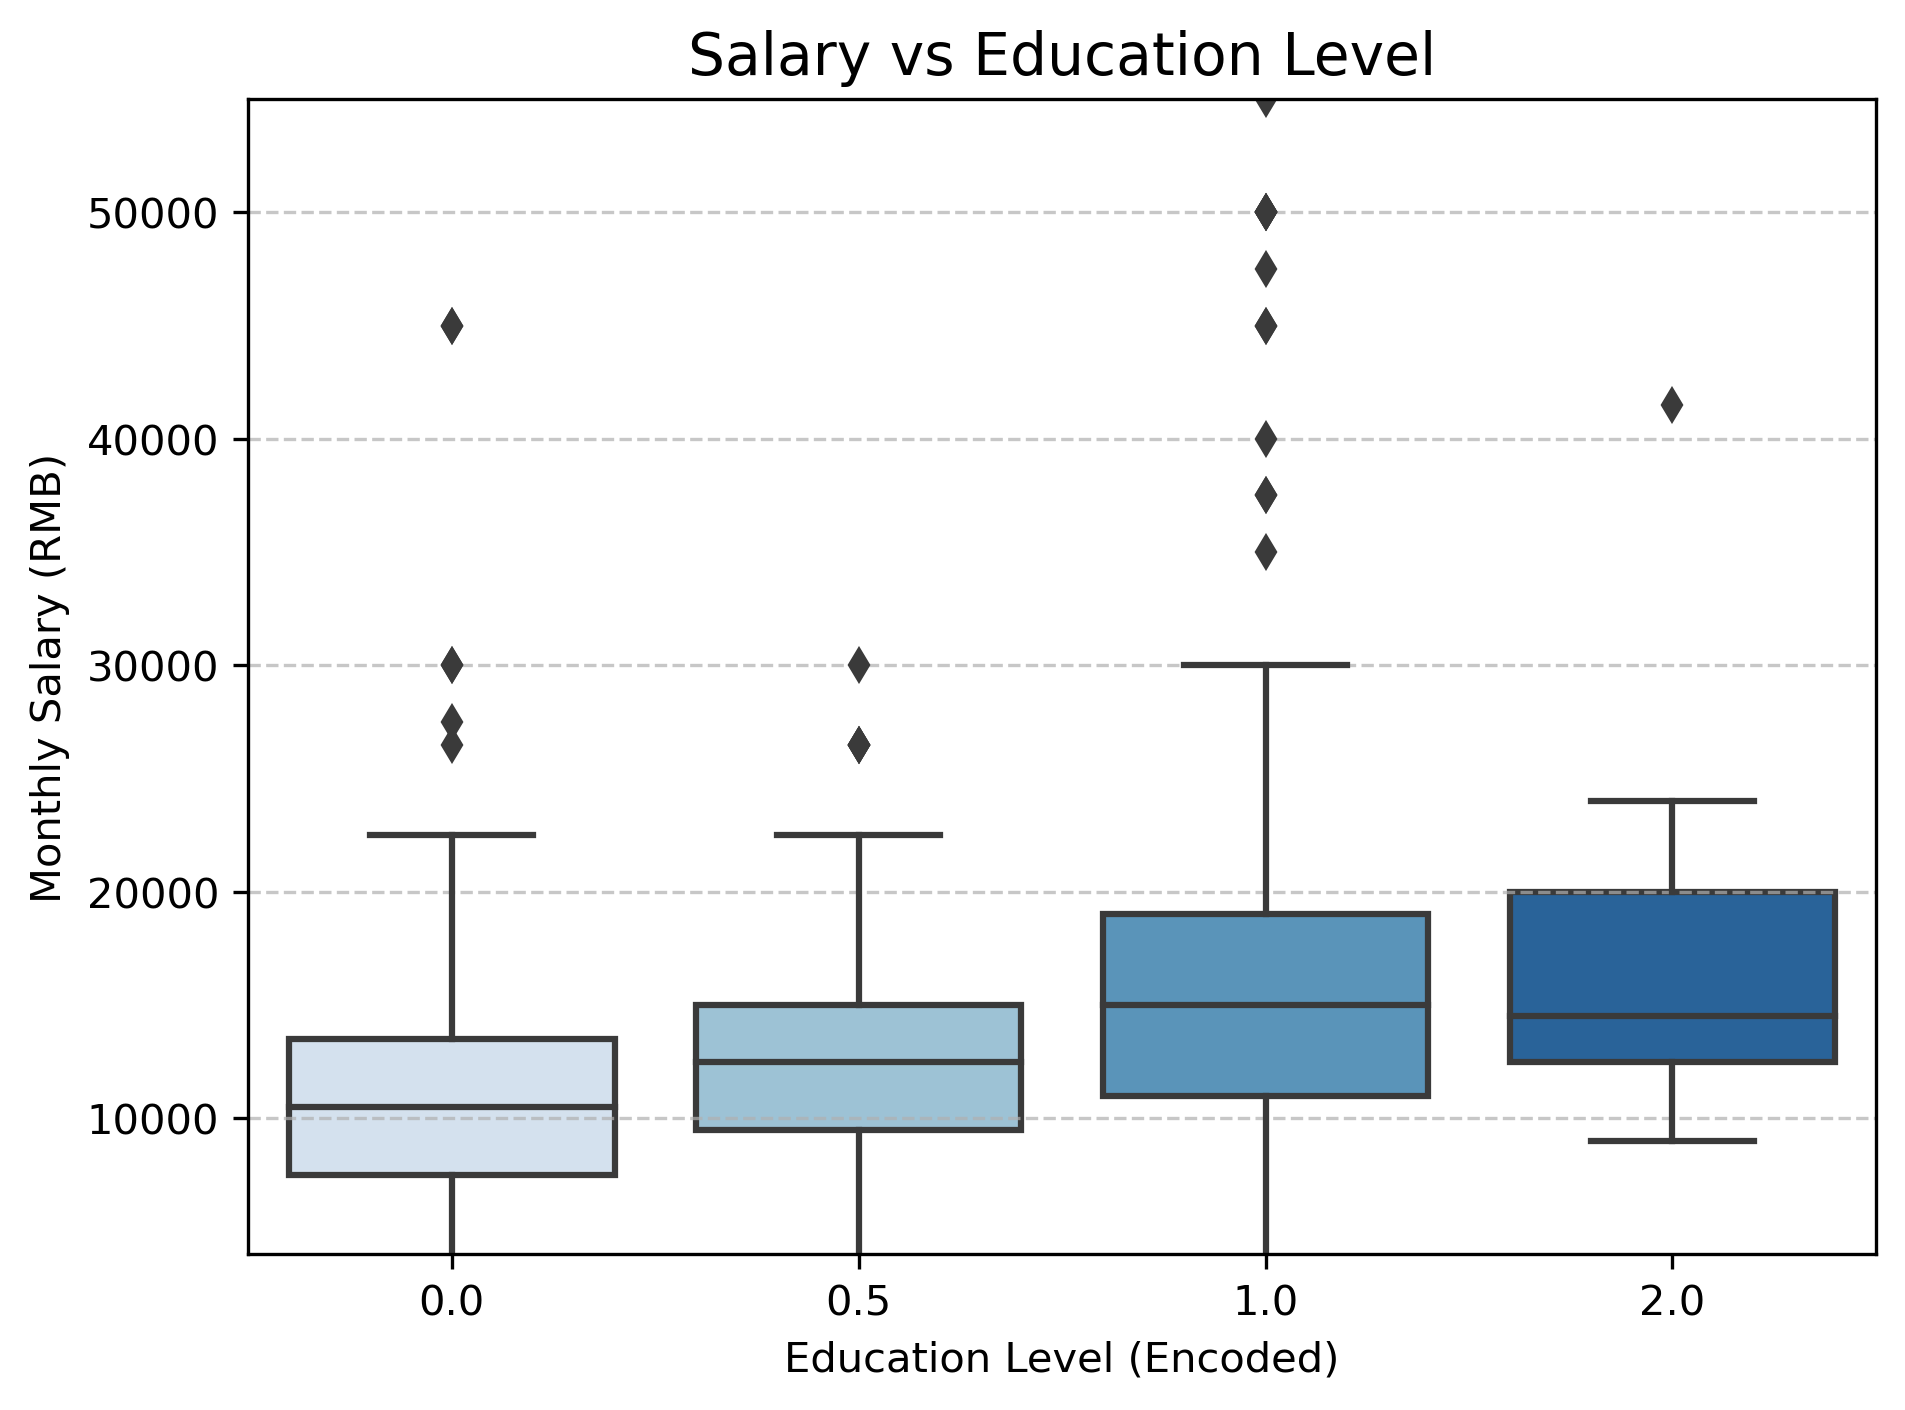

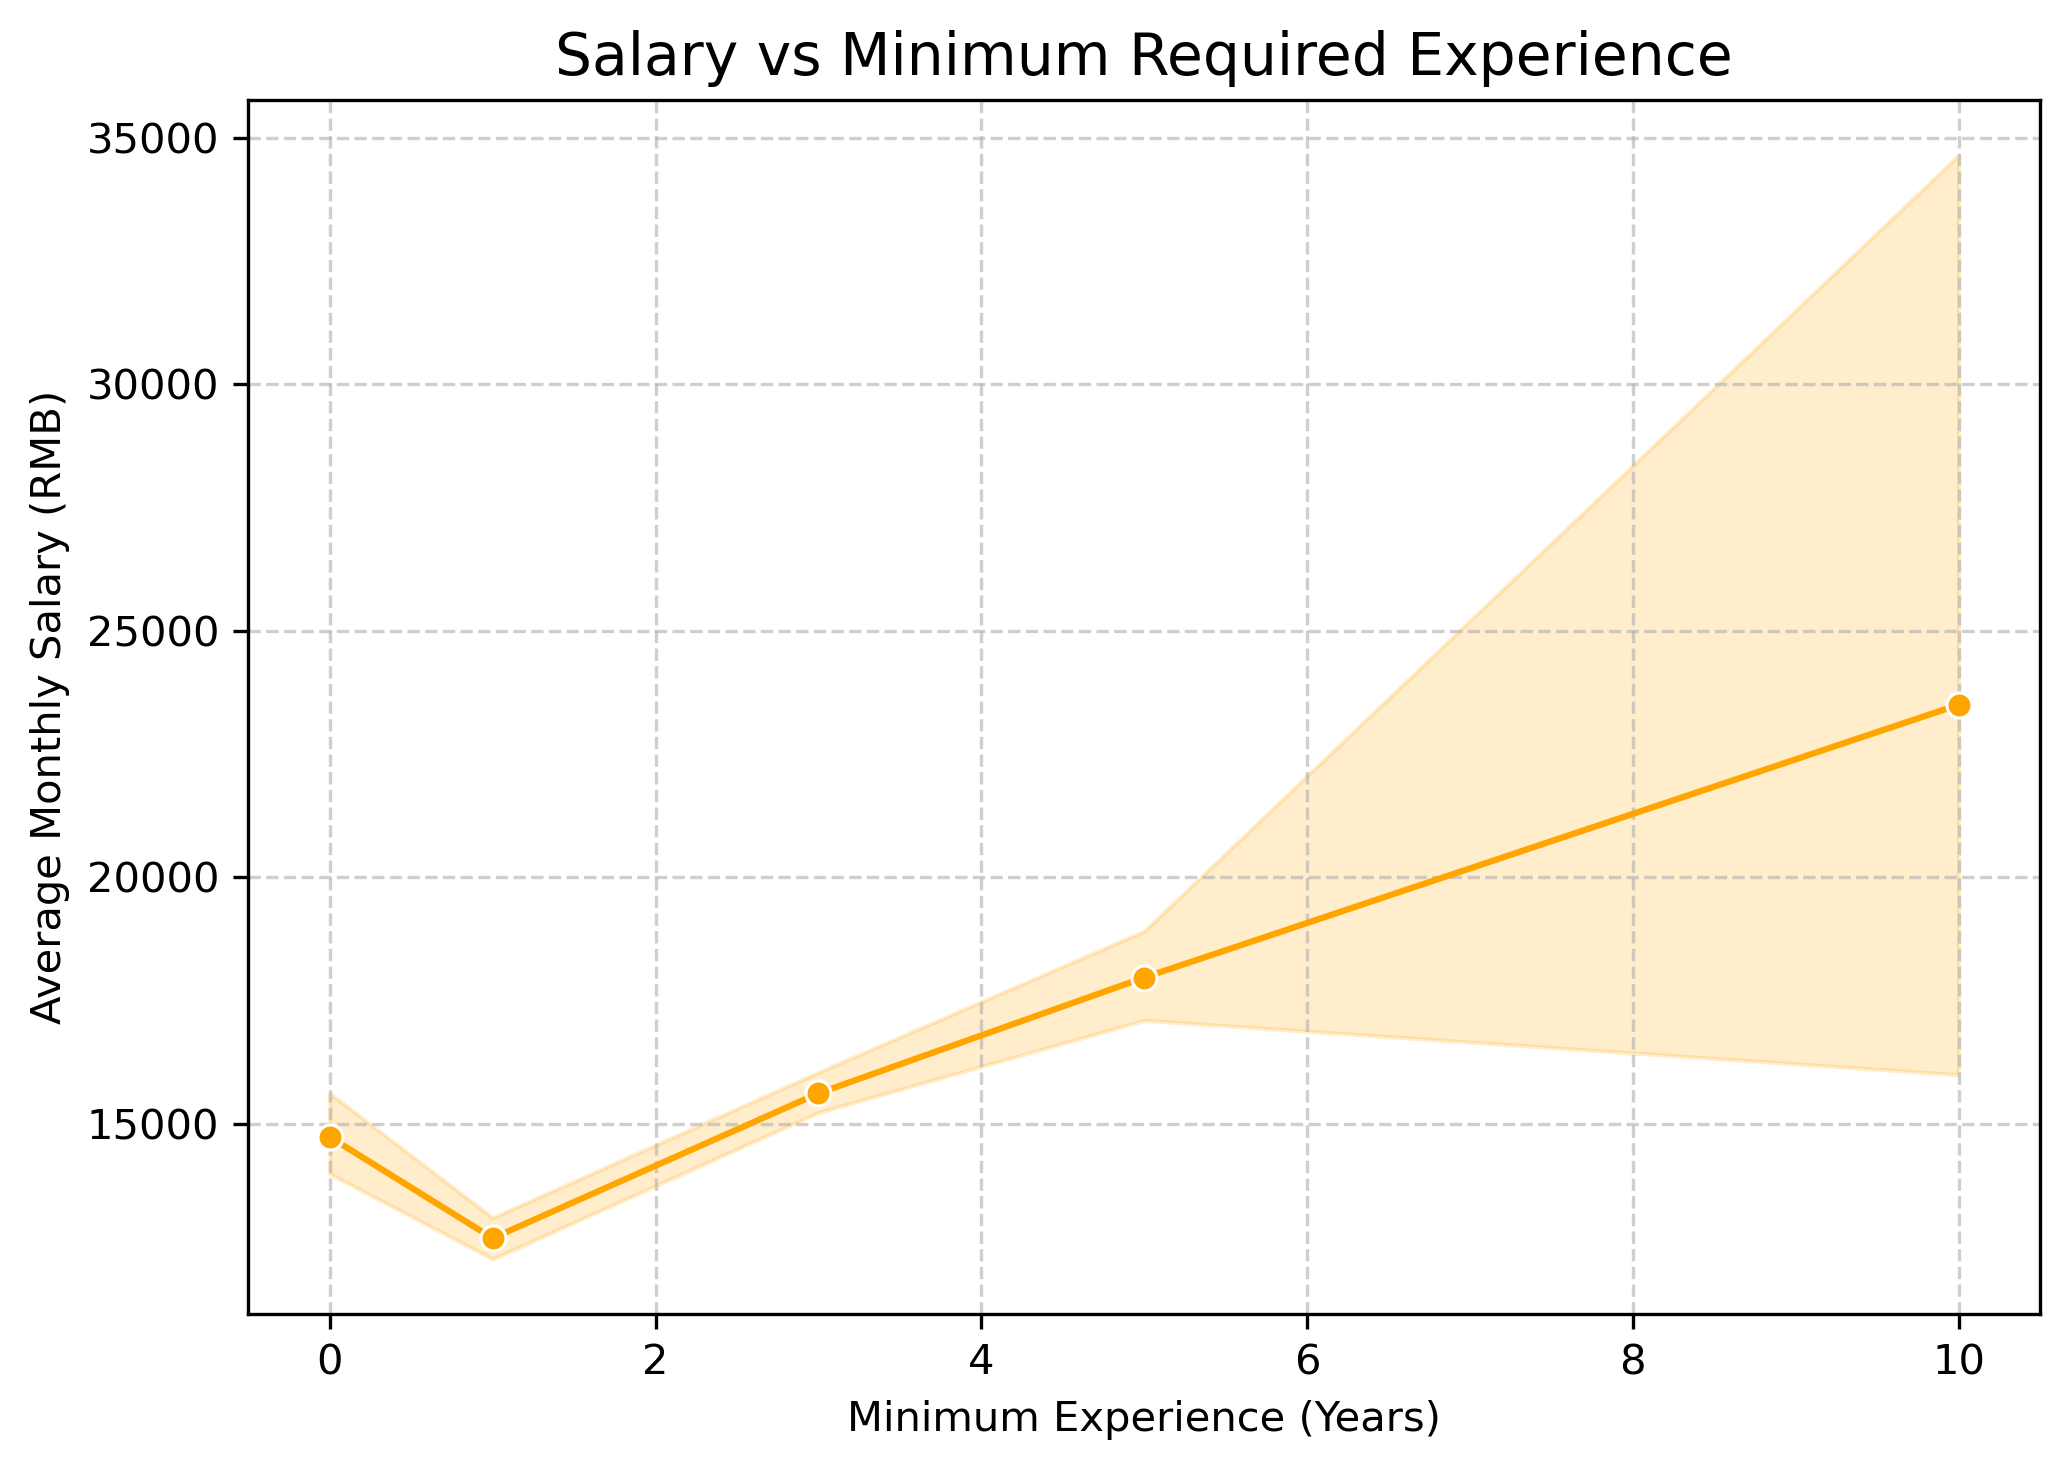

In [36]:
plt.figure(figsize=(7,5))
sns.boxplot(x='education', y='monthly_salary_avg', data=df, palette='Blues')
plt.title("Salary vs Education Level", fontsize=14)
plt.xlabel("Education Level (Encoded)")
plt.ylabel("Monthly Salary (RMB)")
plt.ylim(4000, df['monthly_salary_avg'].max())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(7,5))
sns.lineplot(x='experience_atleast', y='monthly_salary_avg', data=df, marker='o', color='orange')
plt.title("Salary vs Minimum Required Experience", fontsize=14)
plt.xlabel("Minimum Experience (Years)")
plt.ylabel("Average Monthly Salary (RMB)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


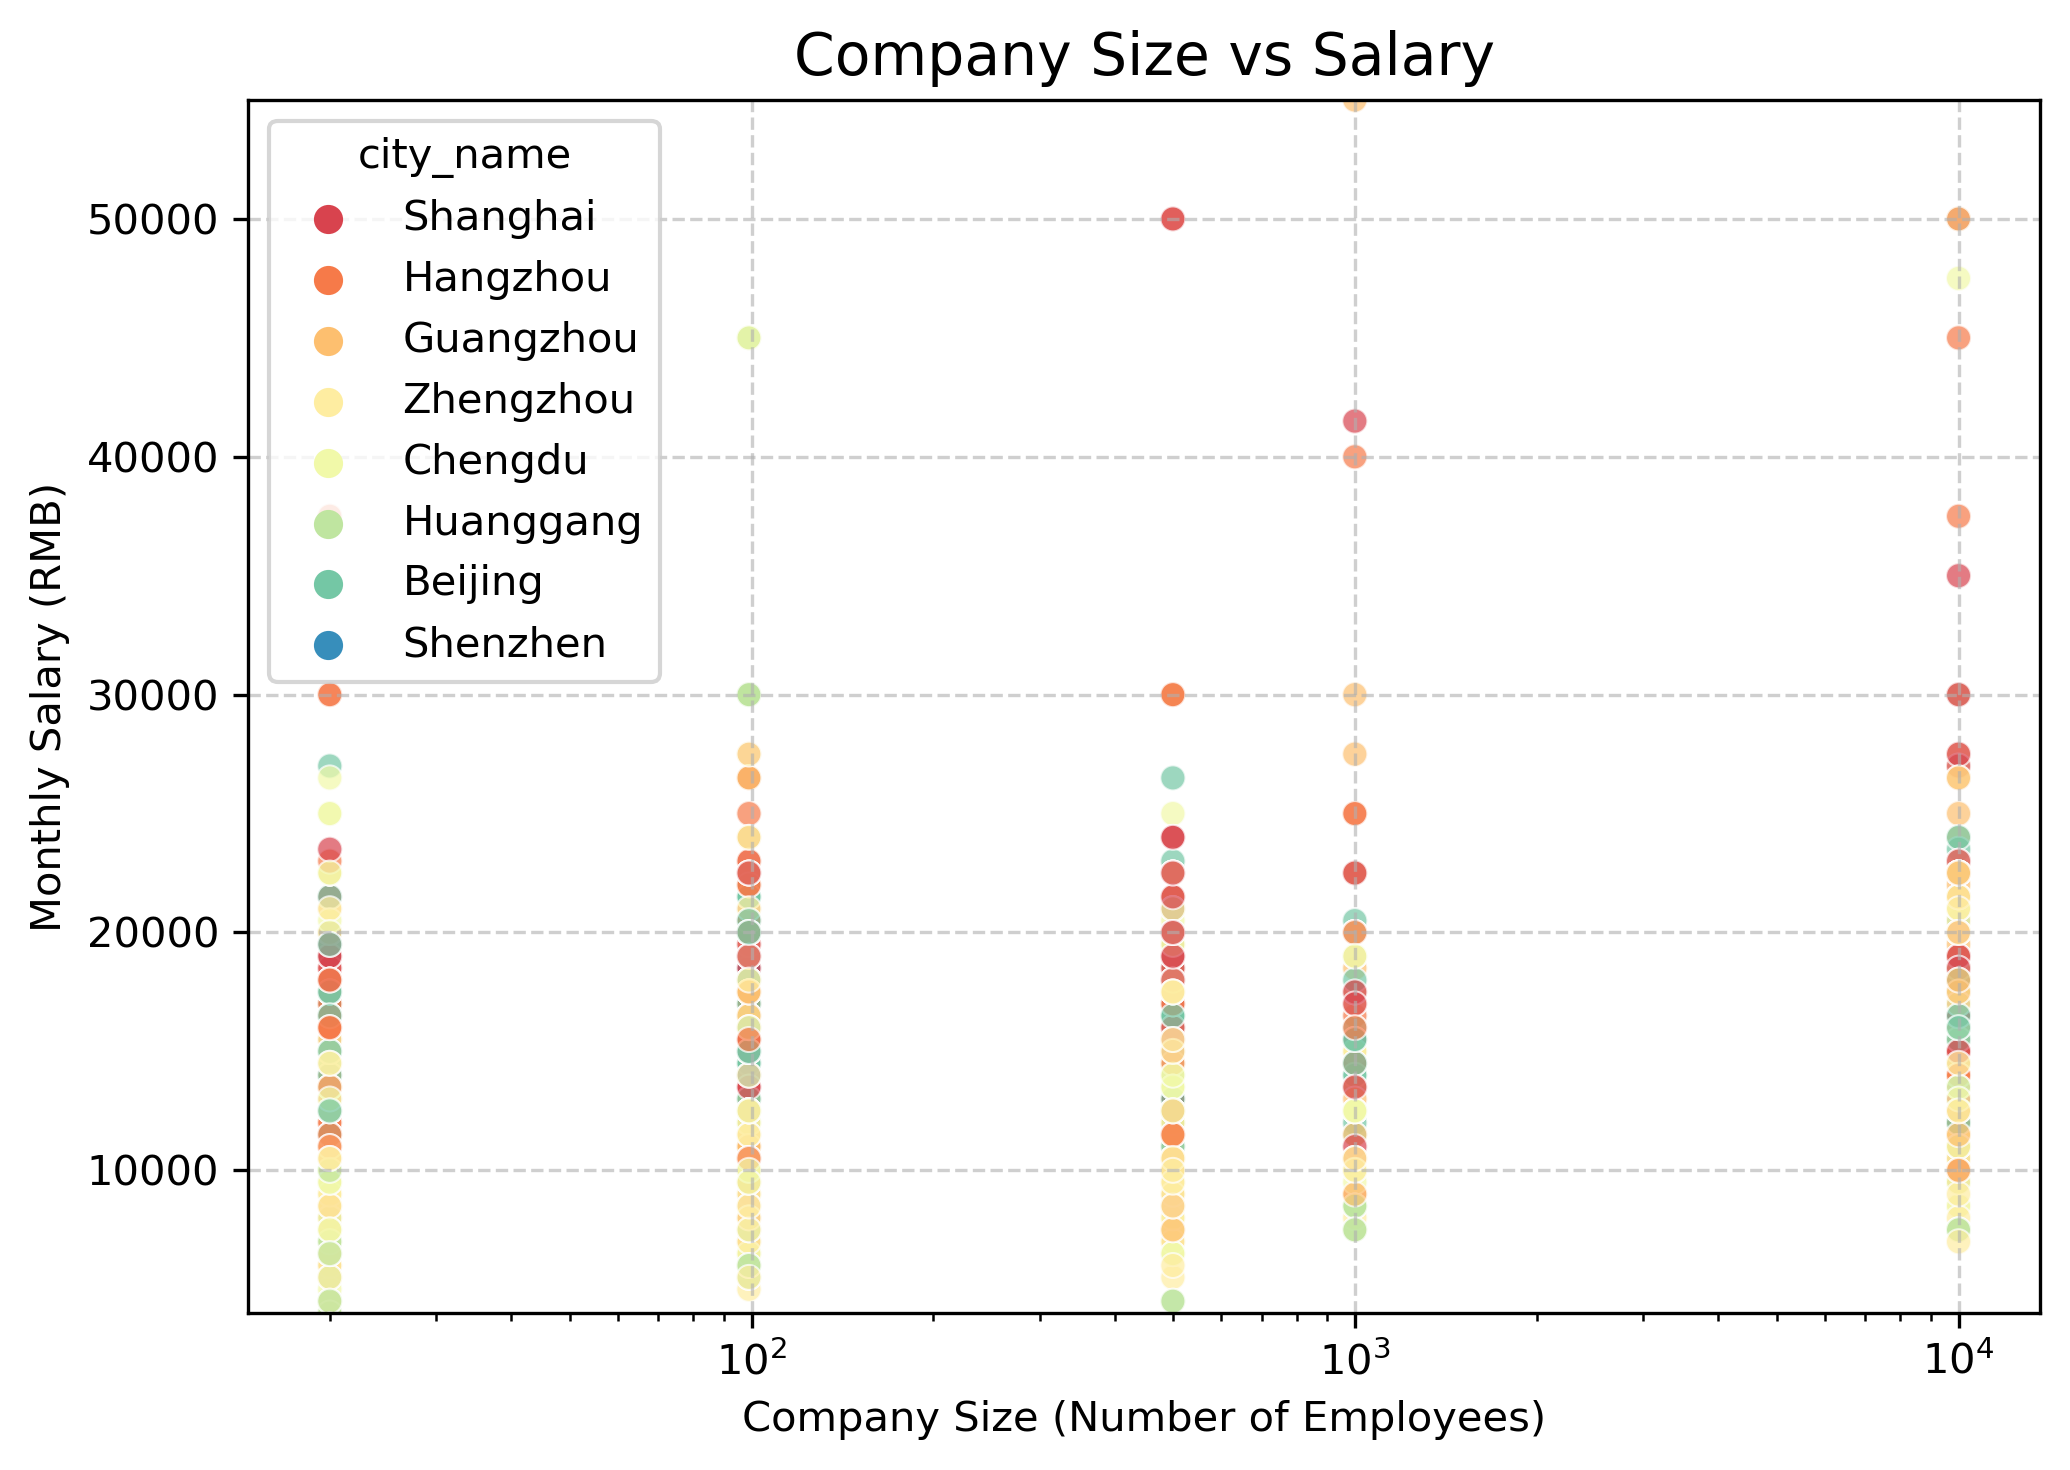

In [37]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='size(employees_number)', y='monthly_salary_avg', data=df, hue='city_name', palette='Spectral', alpha=0.7)
plt.title("Company Size vs Salary", fontsize=14)
plt.xlabel("Company Size (Number of Employees)")
plt.ylabel("Monthly Salary (RMB)")
plt.xscale('log')  
plt.ylim(4000, df['monthly_salary_avg'].max())
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

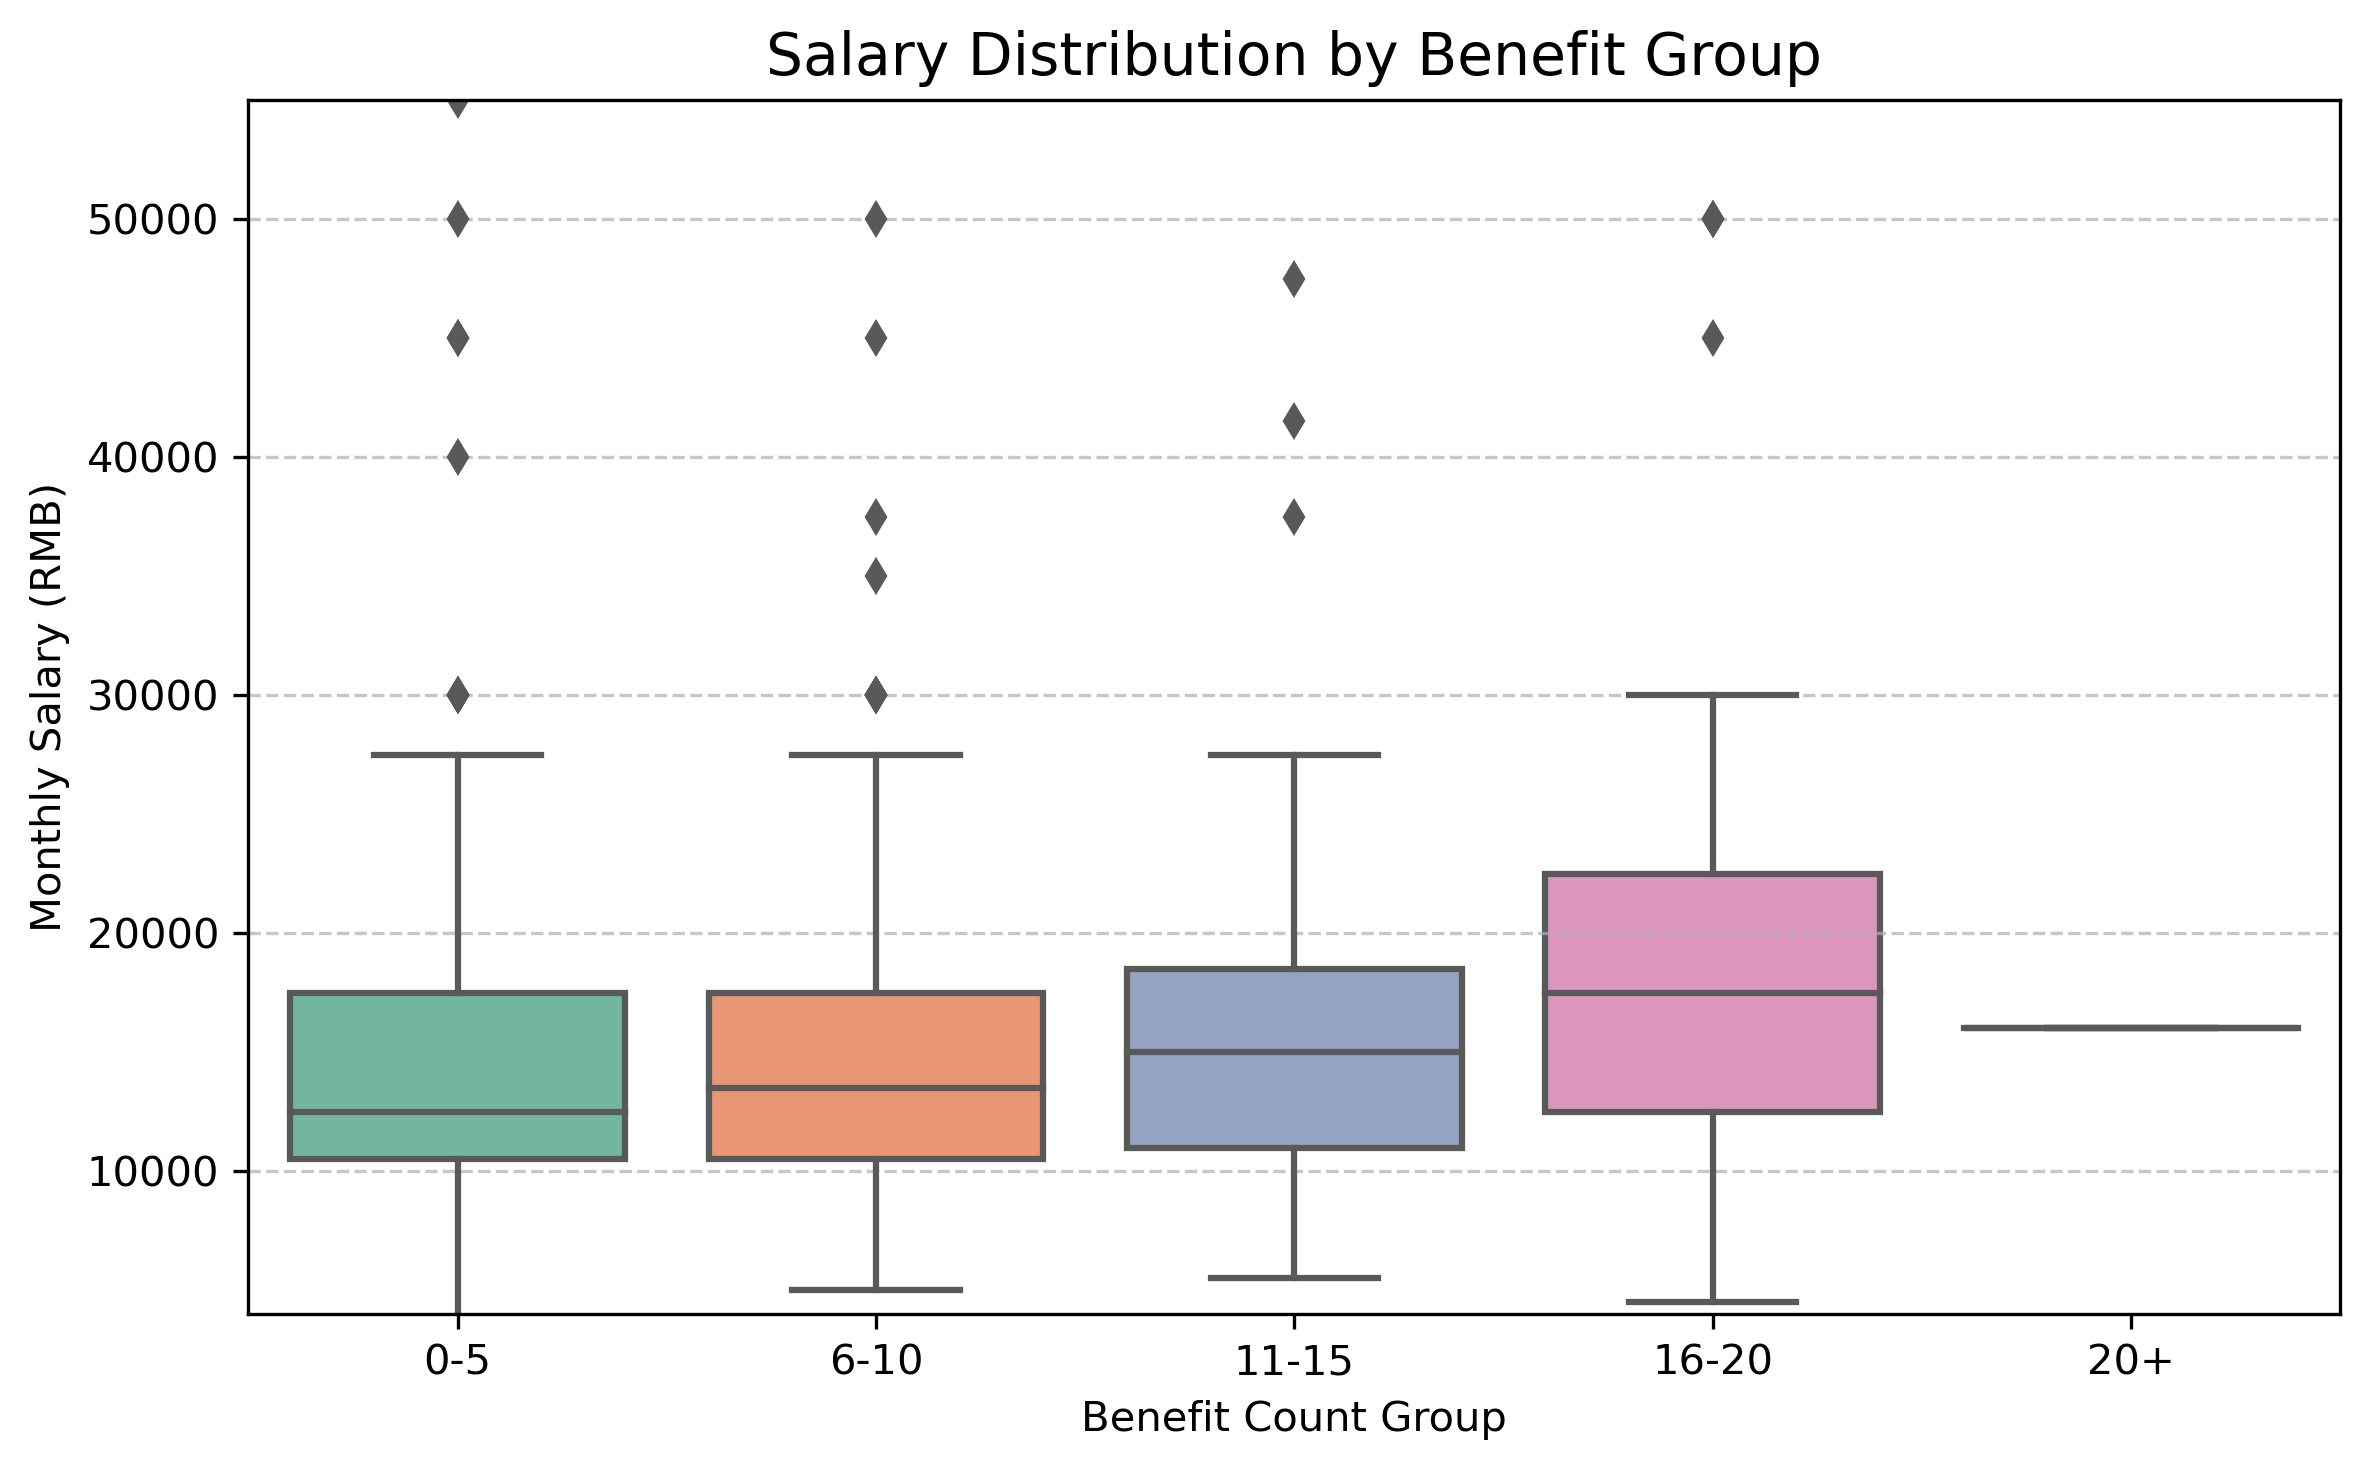

In [38]:
df['benefit_group'] = pd.cut(
    df['benifit'],
    bins=[-1,5,10,15,20,50],
    labels=['0-5','6-10','11-15','16-20','20+']
)

plt.figure(figsize=(8,5))
sns.boxplot(
    x='benefit_group',
    y='monthly_salary_avg',
    data=df,
    palette='Set2'
)
plt.title("Salary Distribution by Benefit Group", fontsize=14)
plt.xlabel("Benefit Count Group")
plt.ylabel("Monthly Salary (RMB)")
plt.ylim(4000, df['monthly_salary_avg'].max())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

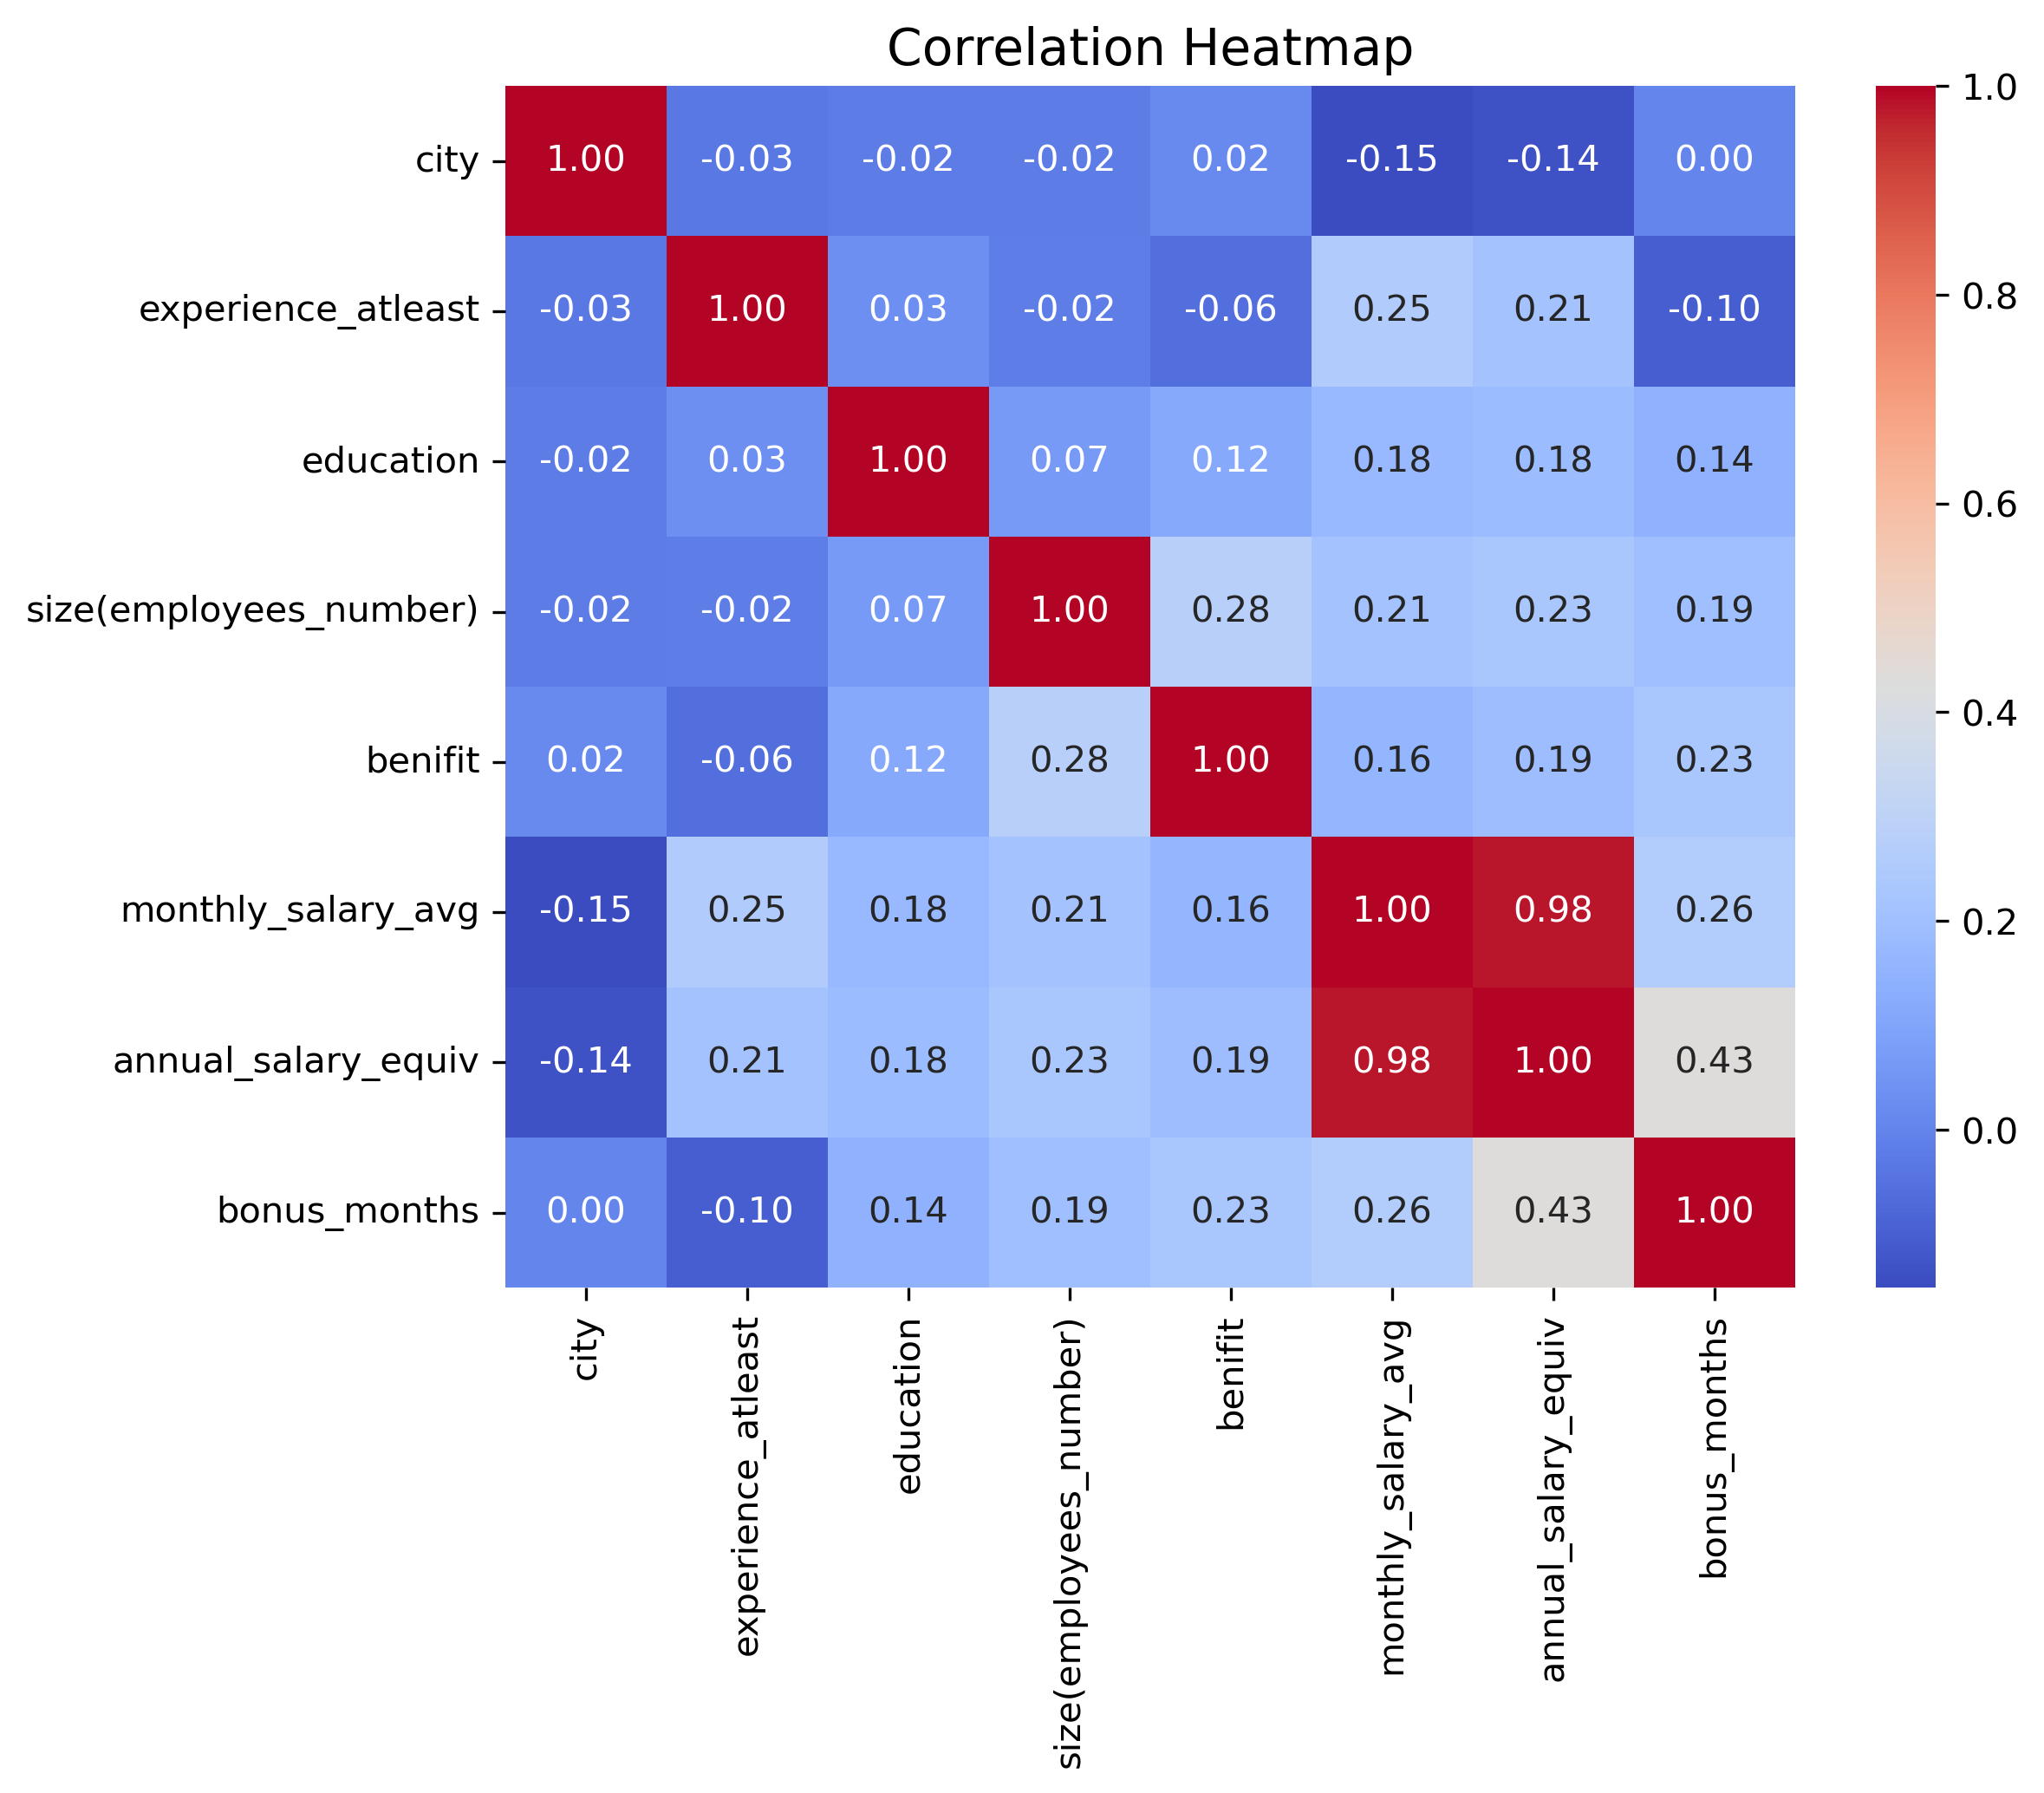

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 6))
sns.heatmap(num_df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Heatmap", fontsize=14)
plt.show()


Detected position column：position_category

Average Salary Table by Position：
  position_category          mean   median  count
0              1_AI  16910.714286  15500.0    112
2            3_test  15940.000000  13500.0     25
1             2_dev  15026.631658  14000.0   1333
5            6_data  14186.746988  13500.0     83
4              5_PA  12553.191489  11500.0     47
3           4_train   8453.846154   8000.0     65


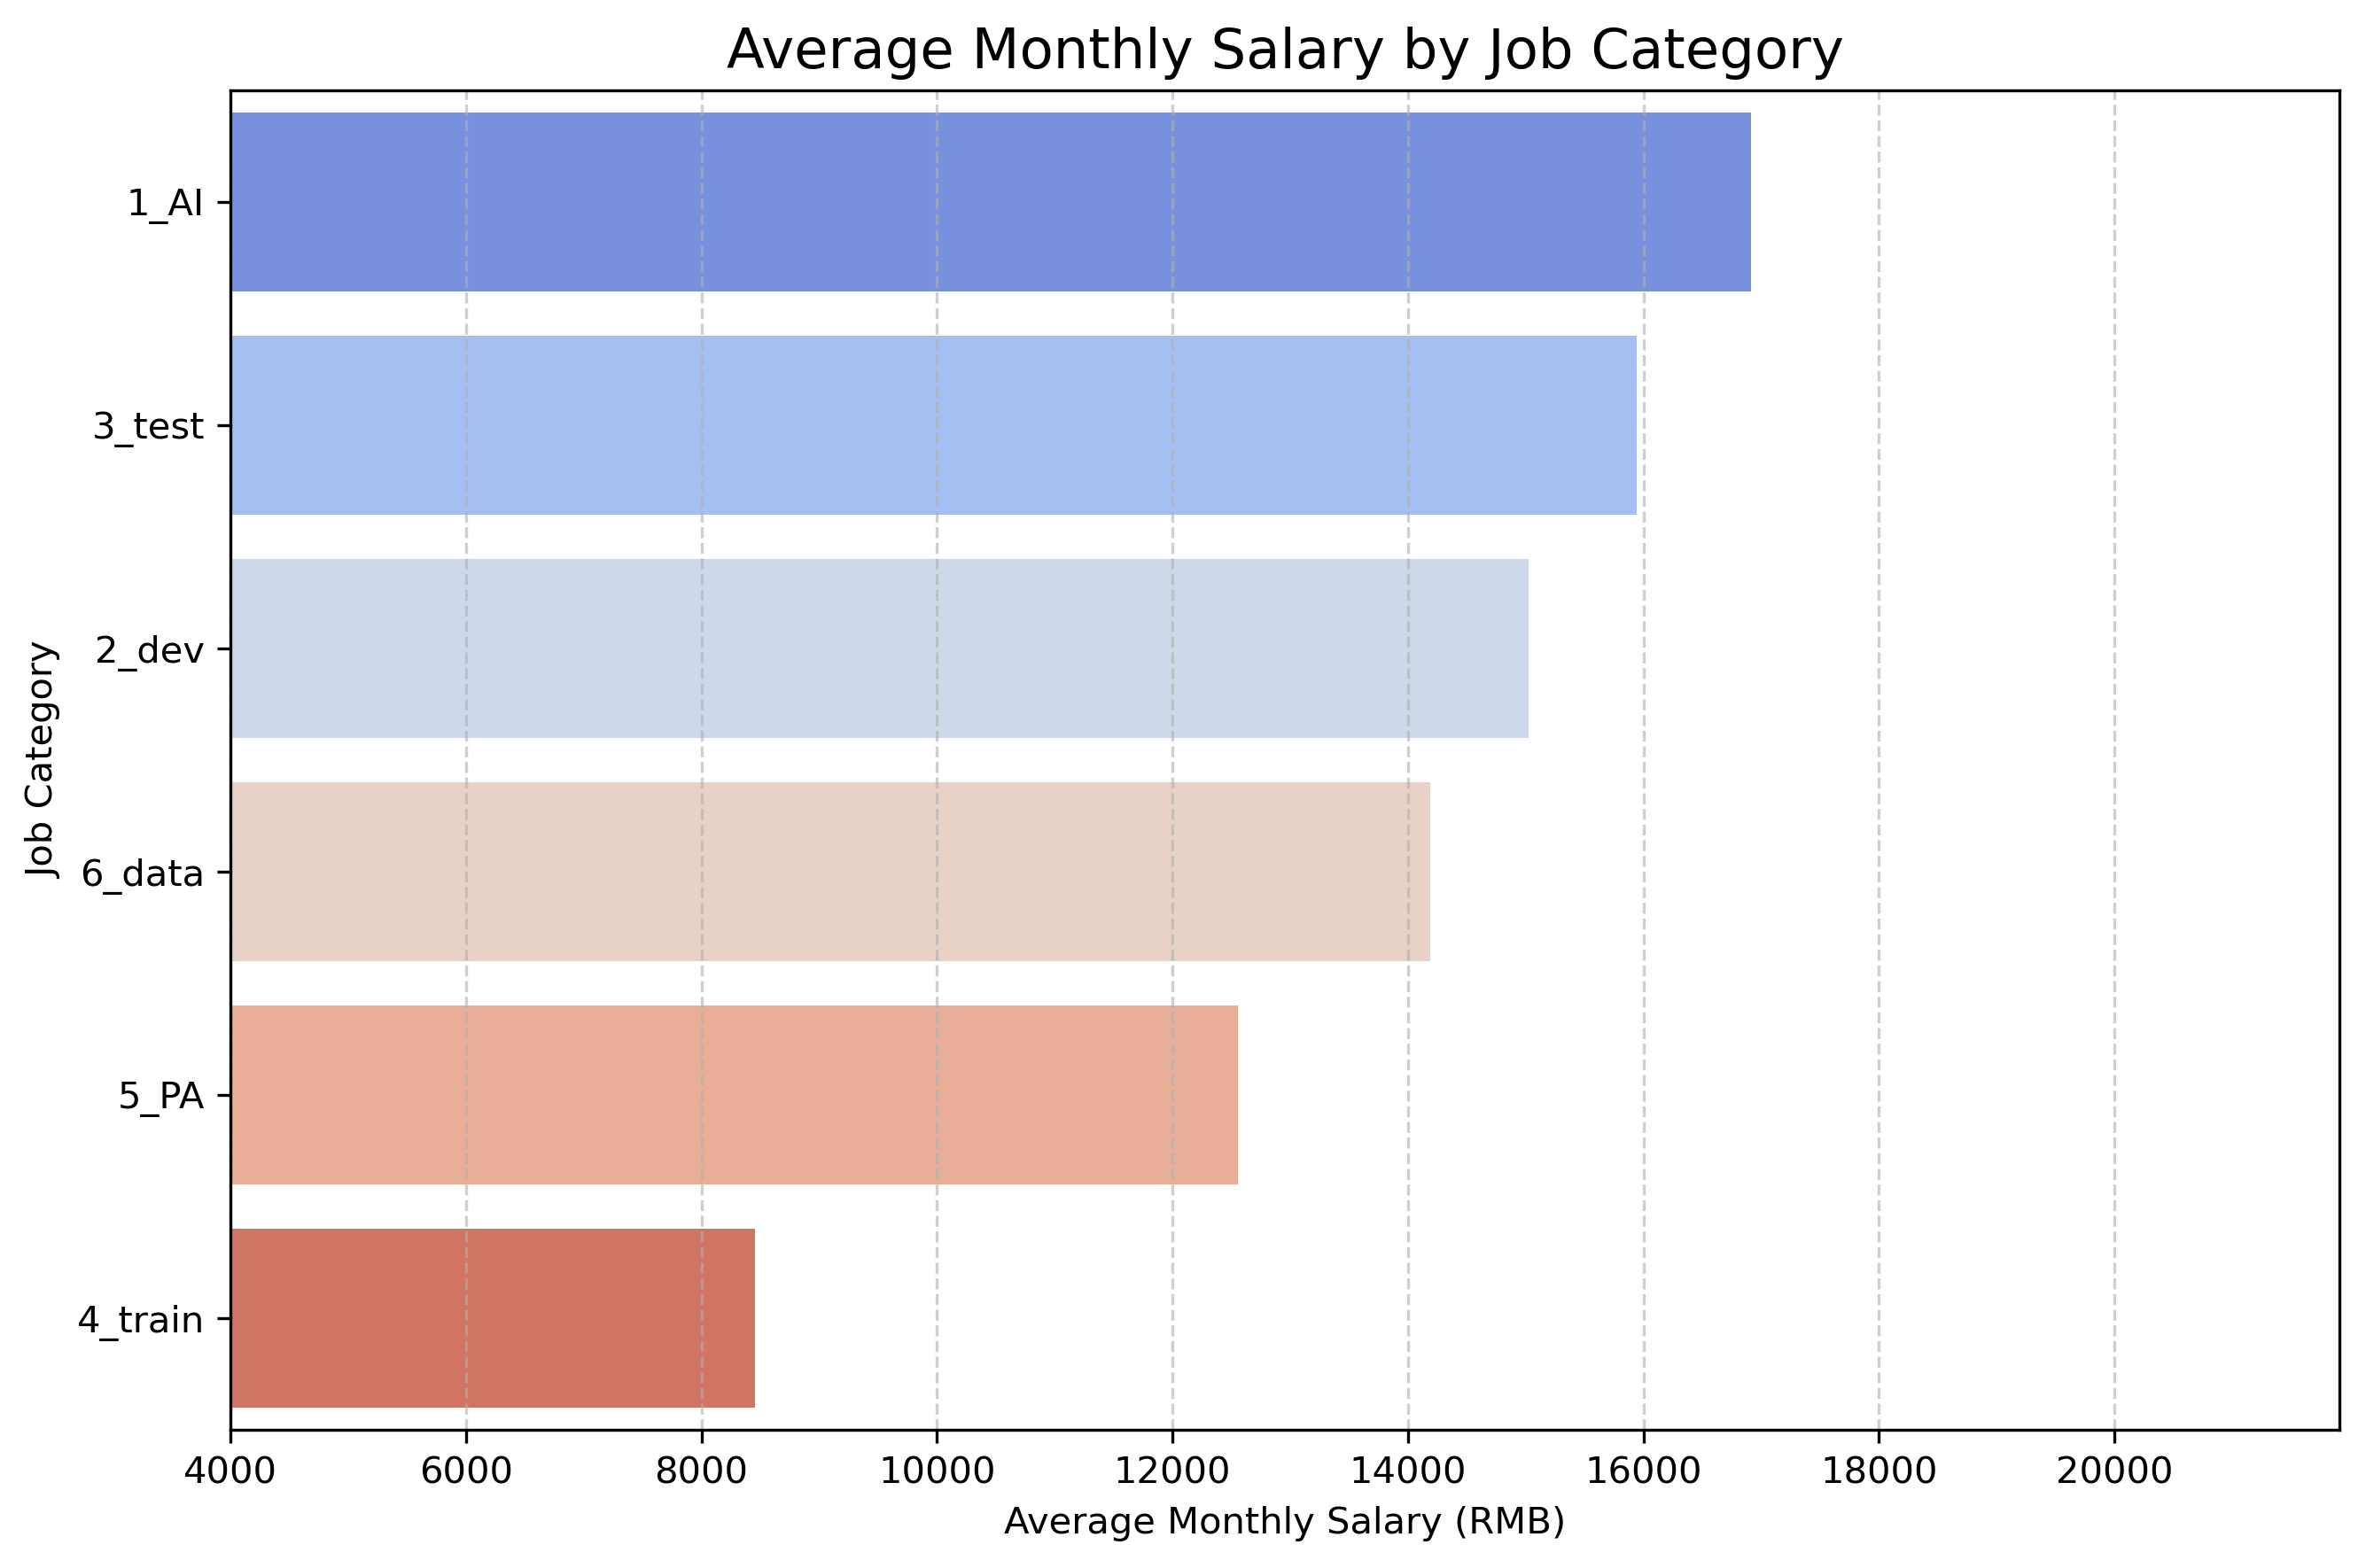

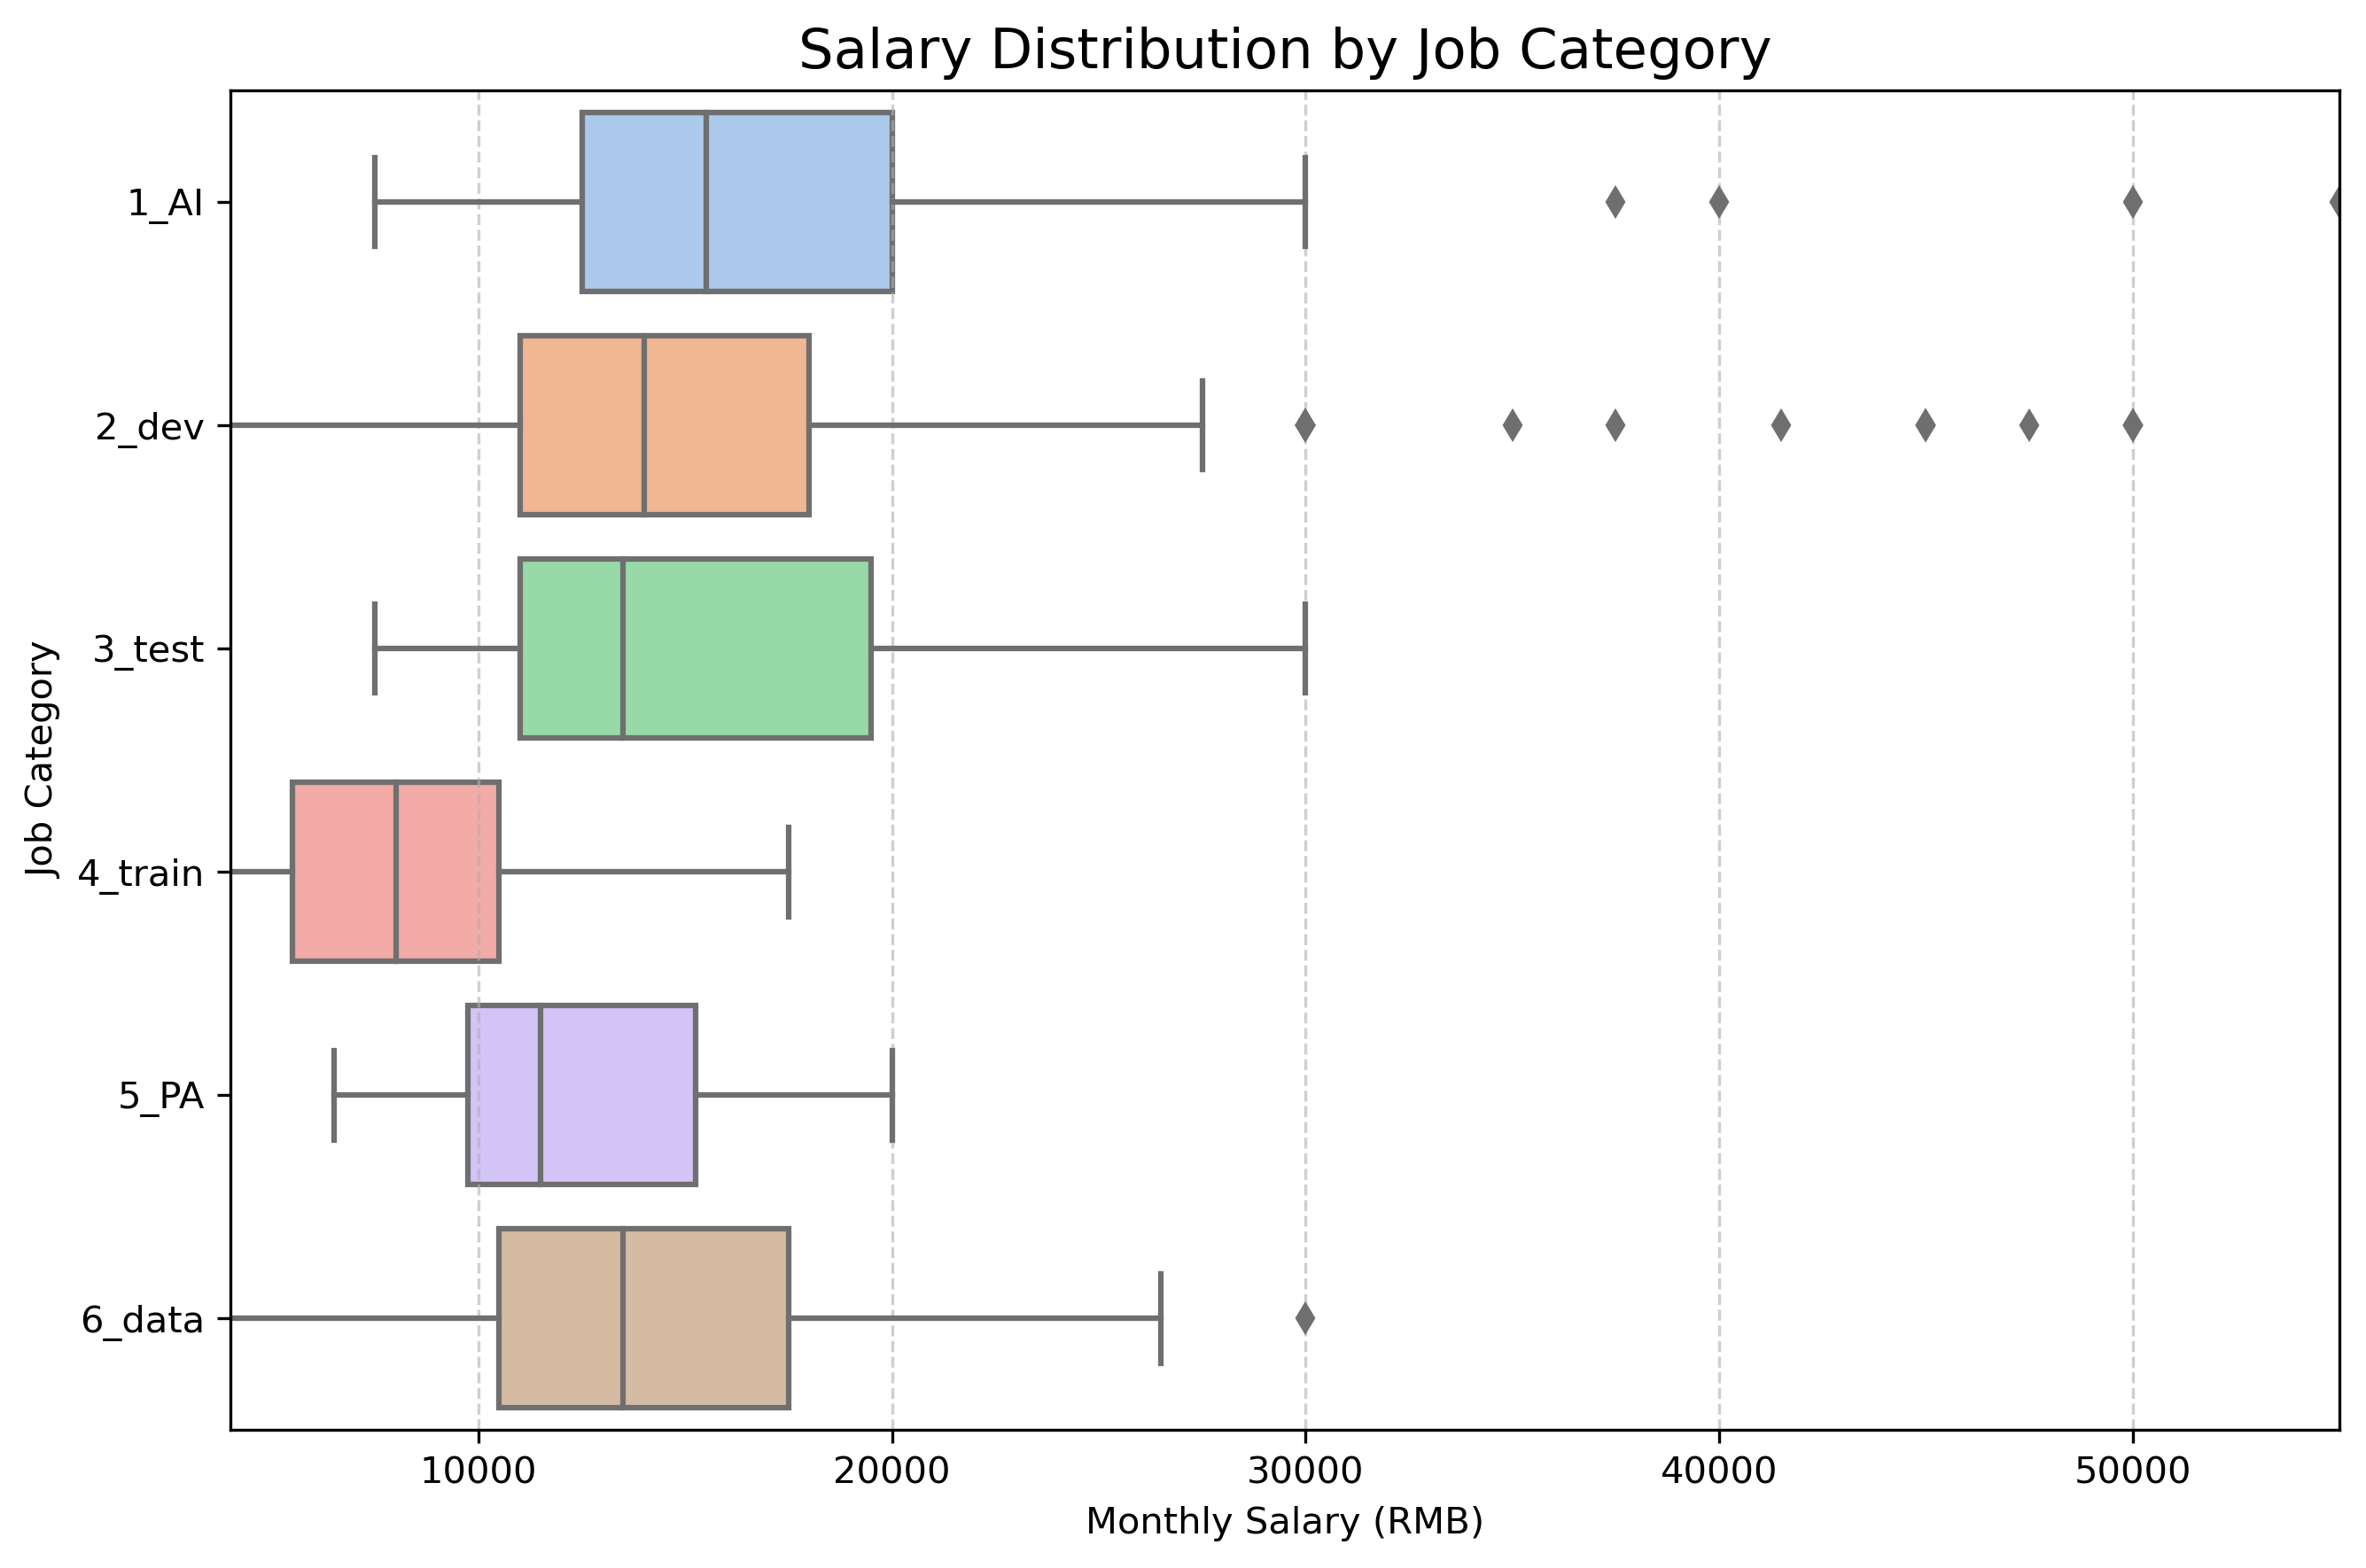

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df = pd.read_csv("coded_factors.csv", encoding='utf-8')

possible_cols = [c for c in df.columns if 'position' in c.lower() or '岗位' in c or '职位' in c]
if not possible_cols:
    raise KeyError("No job column detected. Please check the file column names.")
else:
    position_col = possible_cols[0]
    print(f"Detected position column：{position_col}")


df = df.dropna(subset=[position_col, 'monthly_salary_avg'])
df = df[df['monthly_salary_avg'] > 1000]  
df[position_col] = df[position_col].astype(str)


position_salary = (
    df.groupby(position_col)['monthly_salary_avg']
    .agg(['mean', 'median', 'count'])
    .reset_index()
    .sort_values('mean', ascending=False)
)

print("\nAverage Salary Table by Position：")
print(position_salary.head(10))


plt.figure(figsize=(9,6))
sns.barplot(
    x='mean',
    y=position_col,
    data=position_salary,
    palette='coolwarm'
)
plt.title("Average Monthly Salary by Job Category", fontsize=15)
plt.xlabel("Average Monthly Salary (RMB)")
plt.ylabel("Job Category")

max_salary = position_salary['mean'].max()
plt.xlim(4000, max_salary + 5000)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9,6))
sns.boxplot(
    x='monthly_salary_avg',
    y=position_col,
    data=df,
    palette='pastel'
)
plt.title("Salary Distribution by Job Category", fontsize=15)
plt.xlabel("Monthly Salary (RMB)")
plt.ylabel("Job Category")
plt.xlim(4000, df['monthly_salary_avg'].max())
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


5. Regression Analysis

---

# Multiple Regression Analysis on Salary Factors

## Objective
Analyze the impact of 6 factors on salary using multiple linear regression:
1. Position Category
2. City
3. Work Experience (Years)
4. Education Level
5. Company Size
6. Company Benefits

## 1. Data Loading and Preprocessing

In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-darkgrid') 
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [50]:
# Load the salary dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
df = pd.read_csv('coded_factors.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())

print(f"\nDataset info:")
df.info()

print(f"\nStatistical summary:")
display(df.describe())

Dataset shape: (1665, 10)

First 5 rows:


position_category  city  experience_atleast  education          nature  \
0              1_AI     6                   0        1.0  notneedfunding   
1              1_AI     4                   0        1.0  notneedfunding   
2              1_AI     4                   0        1.0  notneedfunding   
3              1_AI     6                   0        1.0  notneedfunding   
4              1_AI     4                   5        1.0       nofunding   

   size(employees_number)  benifit  monthly_salary_avg  annual_salary_equiv  \
0                   10000       20               22500               315000   
1                   10000       20               22500               315000   
2                   10000       20               22500               315000   
3                   10000       20               22500               315000   
4                     499        0               50000               800000   

   bonus_months  
0            14  
1            14  
2            14  
3            14  
4            16


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position_category       1665 non-null   object 
 1   city                    1665 non-null   int64  
 2   experience_atleast      1665 non-null   int64  
 3   education               1665 non-null   float64
 4   nature                  1665 non-null   object 
 5   size(employees_number)  1665 non-null   int64  
 6   benifit                 1665 non-null   int64  
 7   monthly_salary_avg      1665 non-null   int64  
 8   annual_salary_equiv     1665 non-null   int64  
 9   bonus_months            1665 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 130.2+ KB

Statistical summary:


city  experience_atleast    education  size(employees_number)  \
count  1665.000000         1665.000000  1665.000000             1665.000000   
mean      4.006006            2.142342     0.899099             1897.490691   
std       2.358997            1.593871     0.287509             3676.125898   
min       1.000000            0.000000     0.000000               20.000000   
25%       2.000000            1.000000     1.000000               99.000000   
50%       4.000000            3.000000     1.000000               99.000000   
75%       6.000000            3.000000     1.000000              499.000000   
max       8.000000           10.000000     2.000000            10000.000000   

           benifit  monthly_salary_avg  annual_salary_equiv  bonus_months  
count  1665.000000         1665.000000          1665.000000   1665.000000  
mean      6.894895        14798.798799        183586.186186     12.323724  
std       5.501672         5885.965503         79117.639568      0.785426  
min       0.000000         2000.000000         24000.000000     12.000000  
25%       2.000000        10500.000000        130000.000000     12.000000  
50%       6.000000        13500.000000        168000.000000     12.000000  
75%      10.000000        18000.000000        224000.000000     12.000000  
max      21.000000        55000.000000        800000.000000     20.000000

In [54]:
# Select features and target variable
feature_columns = [
    'position_category',        # Position type
    'city',                     # City
    'experience_atleast',       # Work experience (years)
    'education',                # Education level
    'size(employees_number)',   # Company size
    'benifit'                   # Company benefits
]

target_column = 'monthly_salary_avg'  # Target: Monthly average salary

# Check for missing values
print("Missing values:")
print(df[feature_columns + [target_column]].isnull().sum())

# Remove rows with missing values
df_clean = df[feature_columns + [target_column]].dropna()
print(f"\nCleaned dataset shape: {df_clean.shape}")

Missing values:
position_category         0
city                      0
experience_atleast        0
education                 0
size(employees_number)    0
benifit                   0
monthly_salary_avg        0
dtype: int64

Cleaned dataset shape: (1665, 7)


In [55]:
# Create a copy for encoding
df_encoded = df_clean.copy()

# Encode categorical variables
label_encoders = {}
for col in feature_columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded feature: {col}, unique values: {len(le.classes_)}")

print("\nEncoded features preview:")
display(df_encoded.head())

Encoded feature: position_category, unique values: 6

Encoded features preview:


position_category  city  experience_atleast  education  \
0                  0     6                   0        1.0   
1                  0     4                   0        1.0   
2                  0     4                   0        1.0   
3                  0     6                   0        1.0   
4                  0     4                   5        1.0   

   size(employees_number)  benifit  monthly_salary_avg  
0                   10000       20               22500  
1                   10000       20               22500  
2                   10000       20               22500  
3                   10000       20               22500  
4                     499        0               50000

In [56]:
# Prepare features (X) and target (y)
X = df_encoded[feature_columns]
y = df_encoded[target_column]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print("\nFeatures standardized successfully!")
print("\nStandardized features (first 5 rows):")
display(X_scaled.head())

Feature matrix shape: (1665, 6)
Target vector shape: (1665,)

Features standardized successfully!

Standardized features (first 5 rows):


position_category      city  experience_atleast  education  \
0          -1.198756  0.845526           -1.344517   0.351054   
1          -1.198756 -0.002547           -1.344517   0.351054   
2          -1.198756 -0.002547           -1.344517   0.351054   
3          -1.198756  0.845526           -1.344517   0.351054   
4          -1.198756 -0.002547            1.793443   0.351054   

   size(employees_number)   benifit  
0                2.204751  2.382738  
1                2.204751  2.382738  
2                2.204751  2.382738  
3                2.204751  2.382738  
4               -0.380539 -1.253613

## 4. Train-Test Split

In [57]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set ratio: {X_train.shape[0] / len(X):.1%}")
print(f"Testing set ratio: {X_test.shape[0] / len(X):.1%}")

Training set size: 1332 samples
Testing set size: 333 samples

Training set ratio: 80.0%
Testing set ratio: 20.0%


In [58]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model training completed!")
print(f"\nIntercept: {model.intercept_:.2f}")
print(f"\nFeature Coefficients:")

# Create coefficient dataframe
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

display(coef_df)

Model training completed!

Intercept: 14753.59

Feature Coefficients:


Feature  Coefficient
2      experience_atleast  1362.252513
4  size(employees_number)   969.848154
1                    city  -776.859948
5                 benifit   730.565706
3               education   710.185081
0       position_category  -533.649014

In [59]:
# Make predictions on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Predictions completed!")
print(f"\nSample predictions (first 5 from test set):")

comparison_df = pd.DataFrame({
    'Actual': y_test[:5].values,
    'Predicted': y_test_pred[:5],
    'Difference': y_test[:5].values - y_test_pred[:5]
})
display(comparison_df)

Predictions completed!

Sample predictions (first 5 from test set):


Actual     Predicted   Difference
0   16500  17016.488326  -516.488326
1   12500  13962.639025 -1462.639025
2   17500  12369.165159  5130.834841
3   20000  15566.955466  4433.044534
4    8500  11084.683099 -2584.683099

TRAINING PHASE: MULTIPLE REGRESSION FEATURE ANALYSIS

Visualizing the relationship between each feature and salary...

Position Type        - Correlation: -0.135 | Coefficient:  -533.65 | P-value: 0.0000
City                 - Correlation: -0.163 | Coefficient:  -776.86 | P-value: 0.0000
Work Experience      - Correlation:  0.244 | Coefficient:  1362.25 | P-value: 0.0000
Education Level      - Correlation:  0.161 | Coefficient:   710.19 | P-value: 0.0000
Company Size         - Correlation:  0.219 | Coefficient:   969.85 | P-value: 0.0000
Company Benefits     - Correlation:  0.173 | Coefficient:   730.57 | P-value: 0.0000


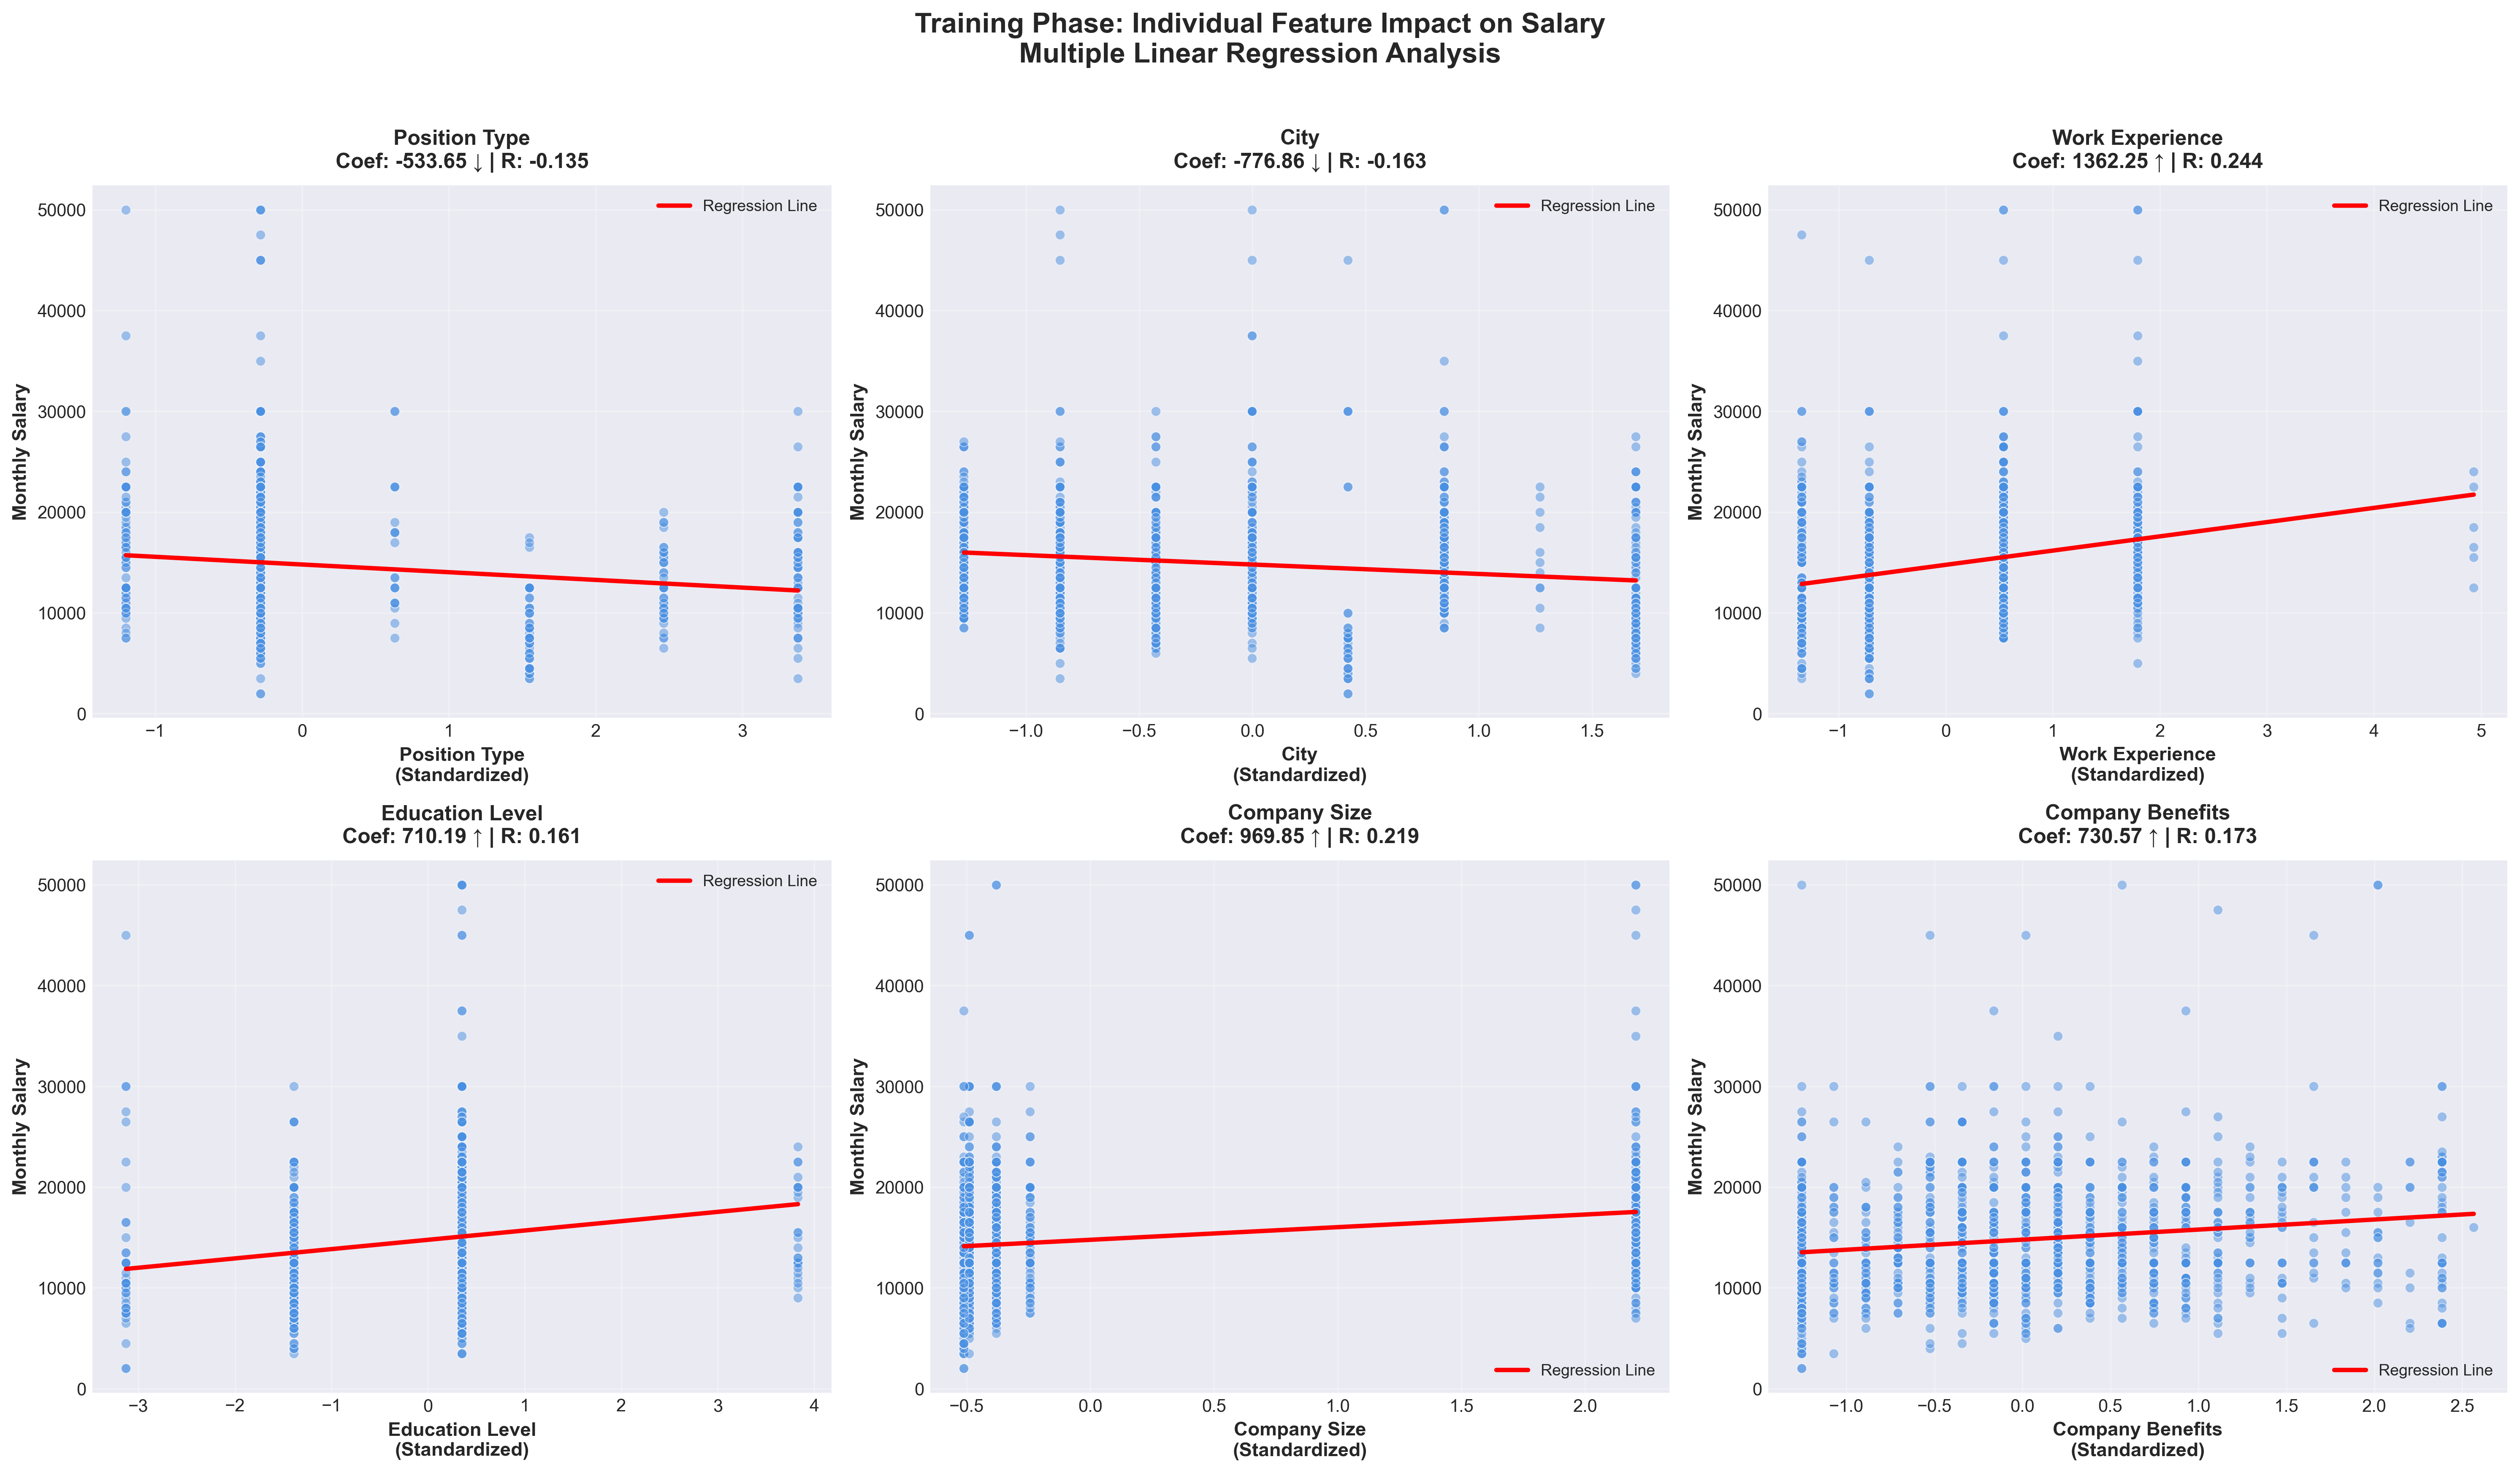


 Training phase feature-salary relationship visualization saved!
   File: training_feature_salary_relationships.png


In [60]:
# Visualize the relationship between each feature and salary in training set
fig = plt.figure(figsize=(20, 12))

# Feature name mapping
feature_names_map = {
    'position_category': 'Position Type',
    'city': 'City',
    'experience_atleast': 'Work Experience',
    'education': 'Education Level',
    'size(employees_number)': 'Company Size',
    'benifit': 'Company Benefits'
}

print("=" * 80)
print("TRAINING PHASE: MULTIPLE REGRESSION FEATURE ANALYSIS")
print("=" * 80)
print("\nVisualizing the relationship between each feature and salary...\n")

# Create 6 subplots for each feature
for idx, feature in enumerate(feature_columns, 1):
    ax = plt.subplot(2, 3, idx)
    
    # Get the feature data (standardized)
    x_feature = X_train[feature].values
    y_values = y_train.values
    
    # Scatter plot
    plt.scatter(x_feature, y_values, alpha=0.5, s=30, color='#4A90E2', edgecolors='white', linewidth=0.5)
    
    # Fit a regression line for this feature only
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_feature, y_values)
    
    # Plot regression line
    x_line = np.linspace(x_feature.min(), x_feature.max(), 100)
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, 'r-', linewidth=2.5, label=f'Regression Line')
    
    # Get coefficient from the multiple regression model
    coef = model.coef_[idx-1]
    feature_name = feature_names_map[feature]
    
    # Labels and title
    plt.xlabel(f'{feature_name}\n(Standardized)', fontsize=11, fontweight='bold')
    plt.ylabel('Monthly Salary', fontsize=11, fontweight='bold')
    
    # Title with correlation and coefficient info
    direction = "↑" if coef > 0 else "↓"
    plt.title(f'{feature_name}\nCoef: {coef:.2f} {direction} | R: {r_value:.3f}', 
              fontsize=12, fontweight='bold', pad=10)
    
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=9)
    
    # Print correlation info
    print(f"{feature_name:20s} - Correlation: {r_value:6.3f} | Coefficient: {coef:8.2f} | P-value: {p_value:.4f}")

plt.suptitle('Training Phase: Individual Feature Impact on Salary\nMultiple Linear Regression Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('training_feature_salary_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print(" Training phase feature-salary relationship visualization saved!")
print("   File: training_feature_salary_relationships.png")
print("=" * 80)

### Interpretation Guide

**Understanding the plots above:**

- **Scatter points**: Each point represents a training sample
- **Red line**: Simple linear regression line for that feature alone
- **Coefficient (Coef)**: From the multiple regression model
  - Positive (+) with ↑: Higher feature value → Higher salary
  - Negative (-) with ↓: Higher feature value → Lower salary
- **R (Correlation)**: Strength of linear relationship
  - Close to +1 or -1: Strong relationship
  - Close to 0: Weak relationship
- **P-value**: Statistical significance
  - < 0.05: Statistically significant relationship
  - ≥ 0.05: Not statistically significant

**Note**: The coefficients shown are from the multiple regression model (considering all features together), while the correlation R is from individual feature analysis.

TRAINING vs TESTING: TOP 3 FEATURES COMPARISON

Experience Atleast  :
  Training   - R:  0.244 | Slope:  1412.76 | P-value: 0.0000
  Testing    - R:  0.291 | Slope:  1806.50 | P-value: 0.0000
  Difference - R:  0.047 | Slope:   393.74

Size(Employees Number):
  Training   - R:  0.219 | Slope:  1253.57 | P-value: 0.0000
  Testing    - R:  0.179 | Slope:  1178.56 | P-value: 0.0011
  Difference - R:  0.041 | Slope:    75.01

City                :
  Training   - R: -0.163 | Slope:  -934.25 | P-value: 0.0000
  Testing    - R: -0.108 | Slope:  -704.75 | P-value: 0.0498
  Difference - R:  0.056 | Slope:   229.50



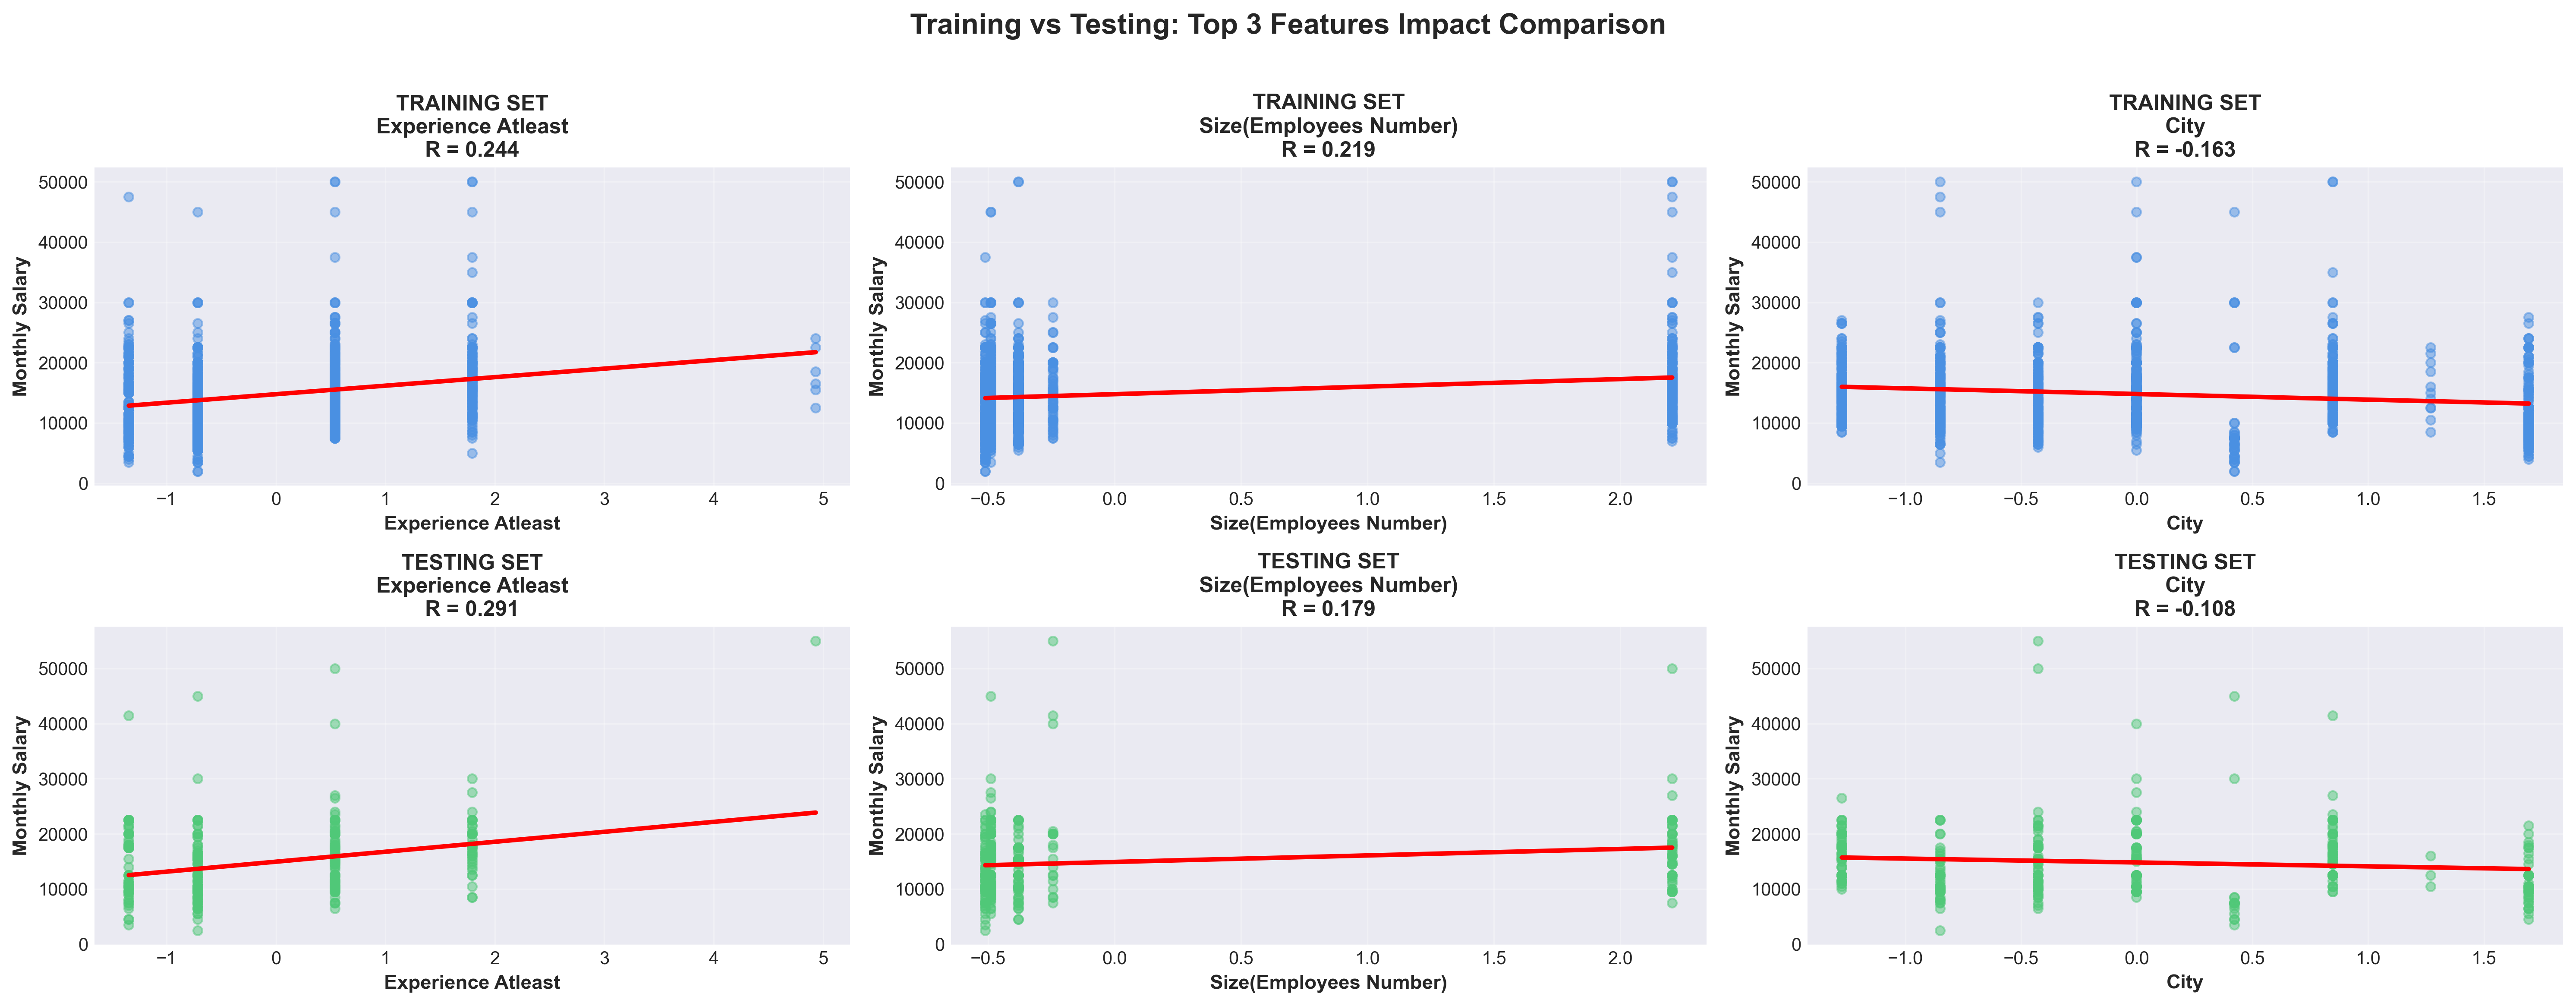

 Training vs Testing comparison visualization saved!
   File: training_vs_testing_feature_comparison.png


In [66]:
# Create side-by-side comparison of training and testing for top 3 features
from scipy import stats

importances = np.abs(model.coef_)
top_3_indices = np.argsort(importances)[-3:][::-1]
top_3_features = X_train.columns[top_3_indices] 

feature_names_map = {col: col.replace("_", " ").title() for col in X_train.columns}

fig = plt.figure(figsize=(20, 8))
print("=" * 80)
print("TRAINING vs TESTING: TOP 3 FEATURES COMPARISON")
print("=" * 80, "\n")

for idx, feature in enumerate(top_3_features, 1):

    # Training plot
    ax1 = plt.subplot(2, 3, idx)
    x_train_feature = X_train[feature].values
    y_train_values = y_train.values
    plt.scatter(x_train_feature, y_train_values, alpha=0.5, s=25, color='#4A90E2')
    
    slope_train, intercept_train, r_train, p_train, _ = stats.linregress(x_train_feature, y_train_values)
    x_line = np.linspace(x_train_feature.min(), x_train_feature.max(), 100)
    plt.plot(x_line, slope_train * x_line + intercept_train, 'r-', linewidth=2.5)

    feature_name = feature_names_map[feature]
    plt.xlabel(f'{feature_name}', fontsize=11, fontweight='bold')
    plt.ylabel('Monthly Salary', fontsize=11, fontweight='bold')
    plt.title(f'TRAINING SET\n{feature_name}\nR = {r_train:.3f}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Testing plot
    ax2 = plt.subplot(2, 3, idx + 3)
    x_test_feature = X_test[feature].values
    y_test_values = y_test.values
    plt.scatter(x_test_feature, y_test_values, alpha=0.5, s=25, color='#50C878')

    slope_test, intercept_test, r_test, p_test, _ = stats.linregress(x_test_feature, y_test_values)
    plt.plot(x_line, slope_test * x_line + intercept_test, 'r-', linewidth=2.5)

    plt.xlabel(f'{feature_name}', fontsize=11, fontweight='bold')
    plt.ylabel('Monthly Salary', fontsize=11, fontweight='bold')
    plt.title(f'TESTING SET\n{feature_name}\nR = {r_test:.3f}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Print stats
    print(f"{feature_name:20s}:")
    print(f"  Training   - R: {r_train:6.3f} | Slope: {slope_train:8.2f} | P-value: {p_train:.4f}")
    print(f"  Testing    - R: {r_test:6.3f} | Slope: {slope_test:8.2f} | P-value: {p_test:.4f}")
    print(f"  Difference - R: {abs(r_train - r_test):6.3f} | Slope: {abs(slope_train - slope_test):8.2f}\n")

plt.suptitle('Training vs Testing: Top 3 Features Impact Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('training_vs_testing_feature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(" Training vs Testing comparison visualization saved!")
print("   File: training_vs_testing_feature_comparison.png")
print("=" * 80)


In [72]:
# Calculate feature importance based on absolute coefficient values
abs_coef = np.abs(model.coef_)
total_abs_coef = np.sum(abs_coef)
feature_importance = (abs_coef / total_abs_coef) * 100

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_,
    'Absolute Coefficient': abs_coef,
    'Impact (%)': feature_importance
}).sort_values('Impact (%)', ascending=False)

# Create feature name mapping for better visualization
feature_names_map = {
    'position_category': 'Position Type',
    'city': 'City',
    'experience_atleast': 'Work Experience',
    'education': 'Education Level',
    'size(employees_number)': 'Company Size',
    'benifit': 'Company Benefits'
}

importance_df['Feature Name'] = importance_df['Feature'].map(feature_names_map)

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)
print("\n Impact of Each Factor on Salary (Ranked by Importance):\n")
display(importance_df[['Feature Name', 'Coefficient', 'Impact (%)']])

print(f"\n Most Important Factor: {importance_df.iloc[0]['Feature Name']} ({importance_df.iloc[0]['Impact (%)']:.2f}%)")
print(f" Second Important Factor: {importance_df.iloc[1]['Feature Name']} ({importance_df.iloc[1]['Impact (%)']:.2f}%)")
print(f" Third Important Factor: {importance_df.iloc[2]['Feature Name']} ({importance_df.iloc[2]['Impact (%)']:.2f}%)")

FEATURE IMPORTANCE ANALYSIS

 Impact of Each Factor on Salary (Ranked by Importance):



Feature Name  Coefficient  Impact (%)
2   Work Experience  1362.252513   26.798267
4      Company Size   969.848154   19.078878
1              City  -776.859948   15.282409
5  Company Benefits   730.565706   14.371708
3   Education Level   710.185081   13.970780
0     Position Type  -533.649014   10.497957


 Most Important Factor: Work Experience (26.80%)
 Second Important Factor: Company Size (19.08%)
 Third Important Factor: City (15.28%)


6. Clustering

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

df = pd.read_csv(r'coded_factors.csv')

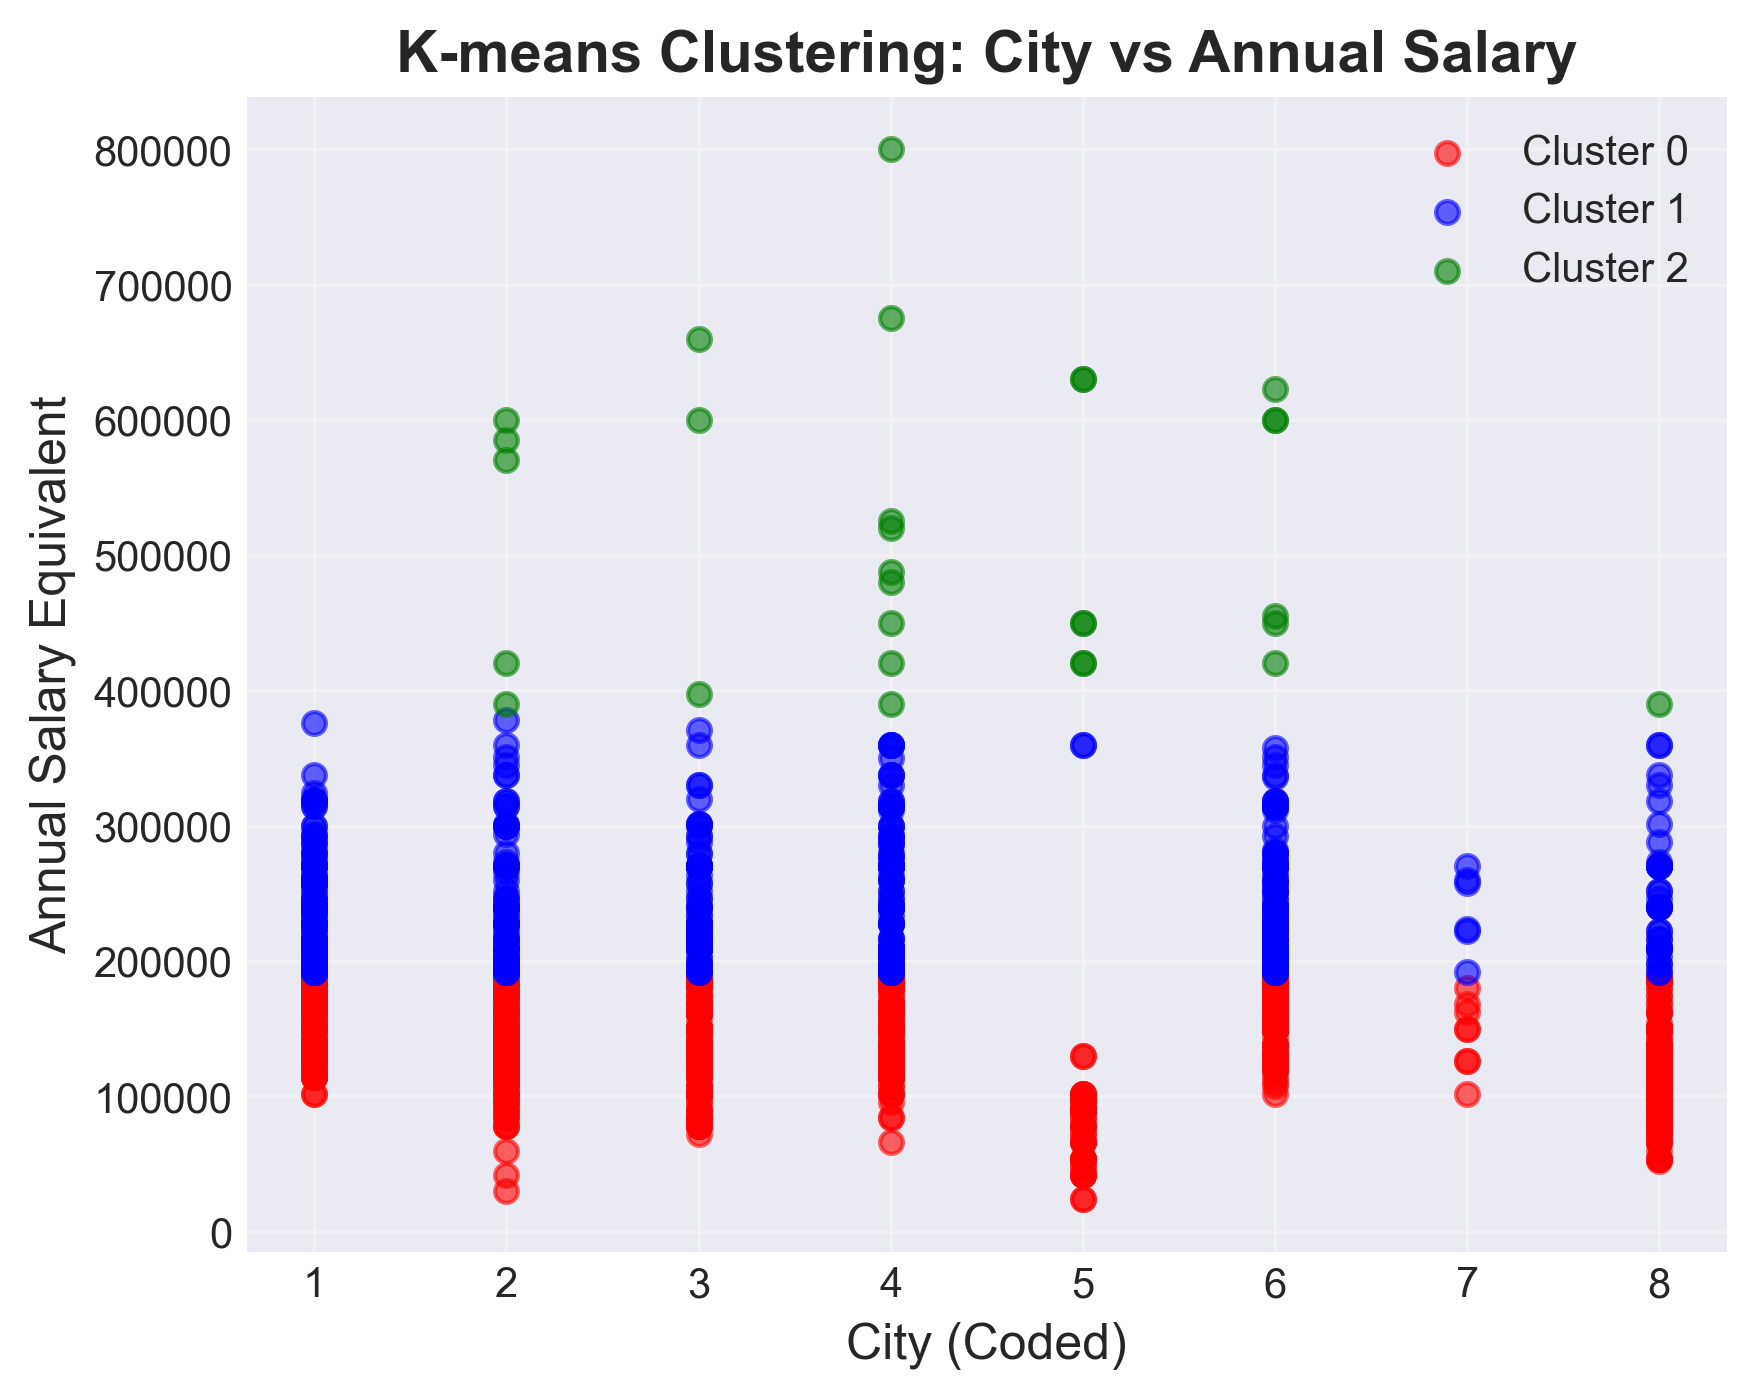

In [68]:
# 1. city vs. annual_salary_equiv
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
X_city = df[['city', 'annual_salary_equiv']].dropna()
kmeans_city = KMeans(n_clusters=3, random_state=42, n_init=10)
X_city['cluster'] = kmeans_city.fit_predict(X_city)
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = X_city[X_city['cluster'] == i]
    plt.scatter(cluster_data['city'], cluster_data['annual_salary_equiv'], 
                c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)
plt.xlabel('City (Coded)', fontsize=12)
plt.ylabel('Annual Salary Equivalent', fontsize=12)
plt.title('K-means Clustering: City vs Annual Salary', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

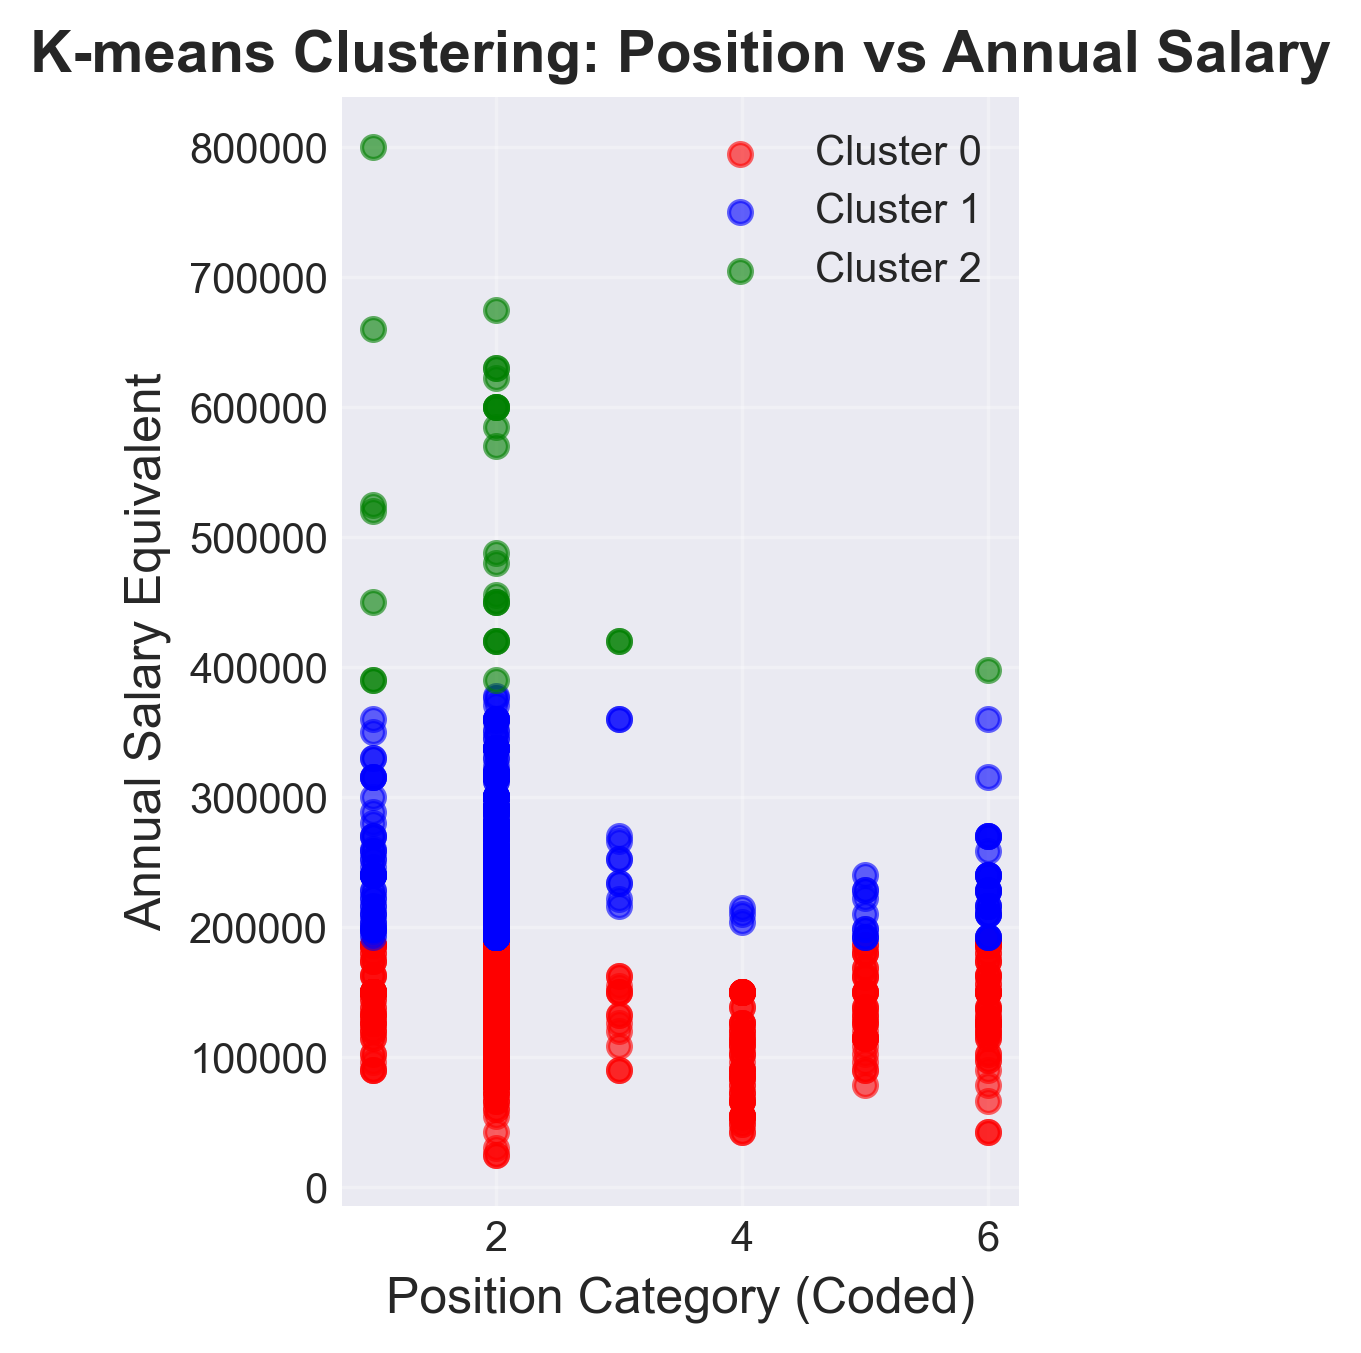

In [69]:
# 2. position_category vs. annual_salary_equiv
plt.subplot(1, 2, 2)
df['position_num'] = df['position_category'].str.extract(r'(\d+)').astype(float)
X_position = df[['position_num', 'annual_salary_equiv']].dropna()
kmeans_position = KMeans(n_clusters=3, random_state=42, n_init=10)
X_position['cluster'] = kmeans_position.fit_predict(X_position)
for i in range(3):
    cluster_data = X_position[X_position['cluster'] == i]
    plt.scatter(cluster_data['position_num'], cluster_data['annual_salary_equiv'], 
                c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)
plt.xlabel('Position Category (Coded)', fontsize=12)
plt.ylabel('Annual Salary Equivalent', fontsize=12)
plt.title('K-means Clustering: Position vs Annual Salary', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

In [70]:
print(f"\nCluster centers for city:\n{kmeans_city.cluster_centers_}")
print(f"\nCluster centers for position:\n{kmeans_position.cluster_centers_}")


Cluster centers for city:
[[4.27909270e+00 1.36238166e+05]
 [3.54589372e+00 2.44795491e+05]
 [4.30000000e+00 5.16916667e+05]]

Cluster centers for position:
[[2.40039448e+00 1.36238166e+05]
 [2.17874396e+00 2.44795491e+05]
 [1.96666667e+00 5.16916667e+05]]


In [71]:
# Summary
print("\n Annual salary Clustering")
for i in range(3):
    cluster_data = X_city[X_city['cluster'] == i]
    print(f"Cluster {i}: {len(cluster_data)} samples, "
          f"average Salary: {cluster_data['annual_salary_equiv'].mean():.0f}")


 Annual salary Clustering
Cluster 0: 1014 samples, average Salary: 136238
Cluster 1: 621 samples, average Salary: 244795
Cluster 2: 30 samples, average Salary: 516917


7.1 Evaluation of Regression

In [19]:
# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation results
print("=" * 80)
print("MODEL PERFORMANCE EVALUATION")
print("=" * 80)

print("\n  TRAINING SET PERFORMANCE:")
print(f"  MSE: {train_mse:,.2f}")
print(f"  RMSE: {train_rmse:,.2f}")
print(f"  MAE: {train_mae:,.2f}")
print(f"  R² Score (Coefficient of Det.): {train_r2:.4f}")
print(f"  Accuracy (R² × 100):  {train_r2 * 100:.2f}%")

print("\n  TESTING SET PERFORMANCE:")
print(f"  MSE: {test_mse:,.2f}")
print(f"  RMSE: {test_rmse:,.2f}")
print(f"  MAE: {test_mae:,.2f}")
print(f"  R² Score (Coefficient of Det.): {test_r2:.4f}")
print(f"  Accuracy (R² × 100): {test_r2 * 100:.2f}%")

# Create metrics summary table
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'MSE': [train_mse, test_mse],
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae],
    'R²': [train_r2, test_r2],
    'Accuracy (%)': [train_r2 * 100, test_r2 * 100]
})

print("\n METRICS SUMMARY TABLE:")
display(metrics_df)

MODEL PERFORMANCE EVALUATION

  TRAINING SET PERFORMANCE:
  MSE: 27,703,003.72
  RMSE: 5,263.36
  MAE: 3,949.61
  R² Score (Coefficient of Det.): 0.1710
  Accuracy (R² × 100):  17.10%

  TESTING SET PERFORMANCE:
  MSE: 32,255,678.17
  RMSE: 5,679.41
  MAE: 3,976.63
  R² Score (Coefficient of Det.): 0.1822
  Accuracy (R² × 100): 18.22%

 METRICS SUMMARY TABLE:


Dataset           MSE         RMSE          MAE        R²  Accuracy (%)
0  Training  2.770300e+07  5263.364297  3949.609837  0.171019     17.101870
1   Testing  3.225568e+07  5679.408259  3976.627195  0.182231     18.223106

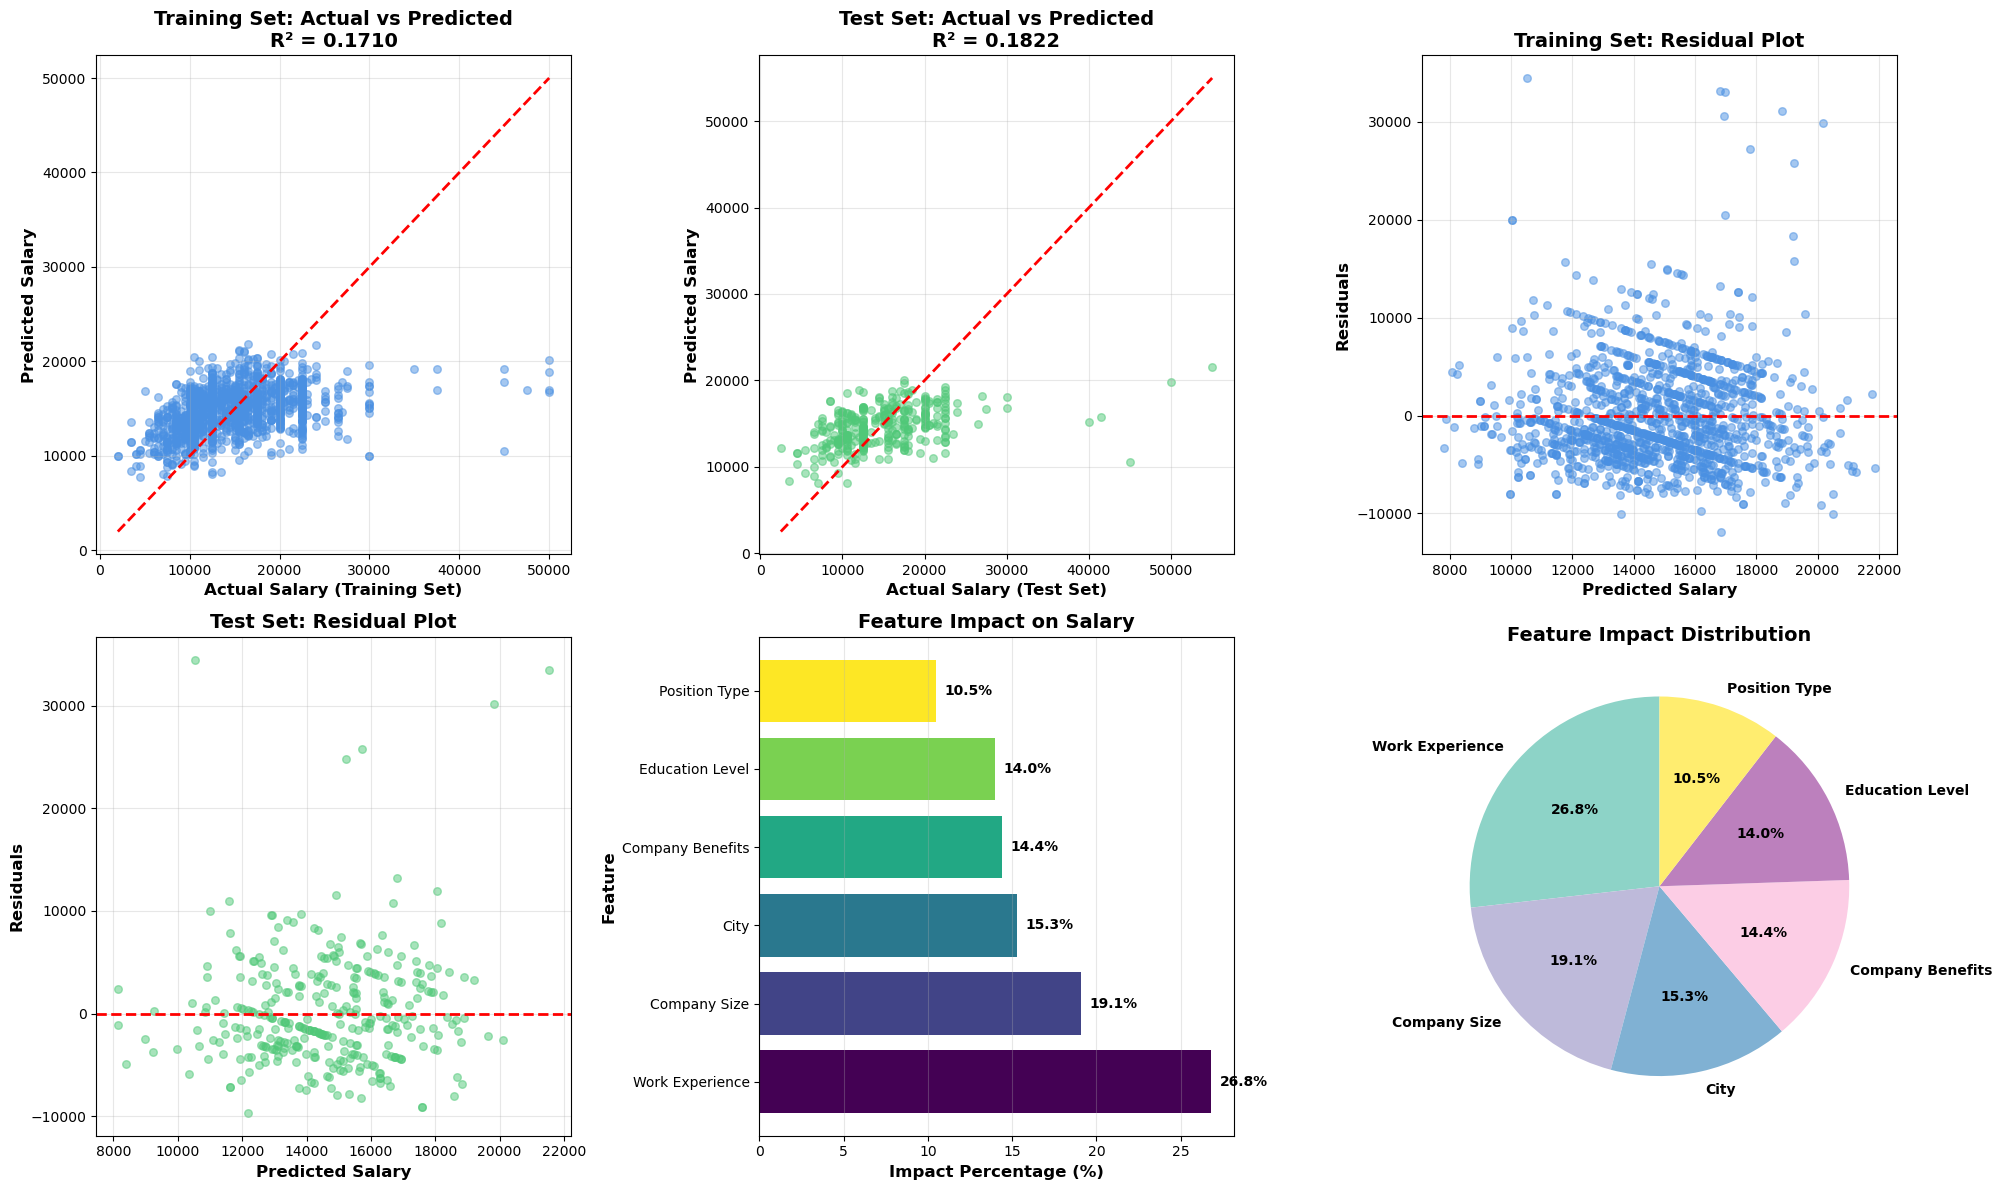

 Comprehensive visualization saved as 'salary_regression_comprehensive_analysis.png'


In [22]:
# Create comprehensive visualization with 6 subplots
fig = plt.figure(figsize=(20, 12))

# 1. Training Set: Actual vs Predicted
ax1 = plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, s=30, color='#4A90E2')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Salary (Training Set)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Salary', fontsize=12, fontweight='bold')
plt.title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 2. Testing Set: Actual vs Predicted
ax2 = plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, s=30, color='#50C878')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary (Test Set)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Salary', fontsize=12, fontweight='bold')
plt.title(f'Test Set: Actual vs Predicted\nR² = {test_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 3. Training Set: Residual Plot
ax3 = plt.subplot(2, 3, 3)
residuals_train = y_train - y_train_pred
plt.scatter(y_train_pred, residuals_train, alpha=0.5, s=30, color='#4A90E2')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Salary', fontsize=12, fontweight='bold')
plt.ylabel('Residuals', fontsize=12, fontweight='bold')
plt.title('Training Set: Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Testing Set: Residual Plot
ax4 = plt.subplot(2, 3, 4)
residuals_test = y_test - y_test_pred
plt.scatter(y_test_pred, residuals_test, alpha=0.5, s=30, color='#50C878')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Salary', fontsize=12, fontweight='bold')
plt.ylabel('Residuals', fontsize=12, fontweight='bold')
plt.title('Test Set: Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 5. Feature Impact - Bar Chart
ax5 = plt.subplot(2, 3, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars = plt.barh(importance_df['Feature Name'], importance_df['Impact (%)'], color=colors)
plt.xlabel('Impact Percentage (%)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Impact on Salary', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, importance_df['Impact (%)'])):
    plt.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=10, fontweight='bold')

# 6. Feature Impact - Pie Chart
ax6 = plt.subplot(2, 3, 6)
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(importance_df)))
wedges, texts, autotexts = plt.pie(
    importance_df['Impact (%)'], 
    labels=importance_df['Feature Name'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
plt.title('Feature Impact Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('salary_regression_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Comprehensive visualization saved as 'salary_regression_comprehensive_analysis.png'")

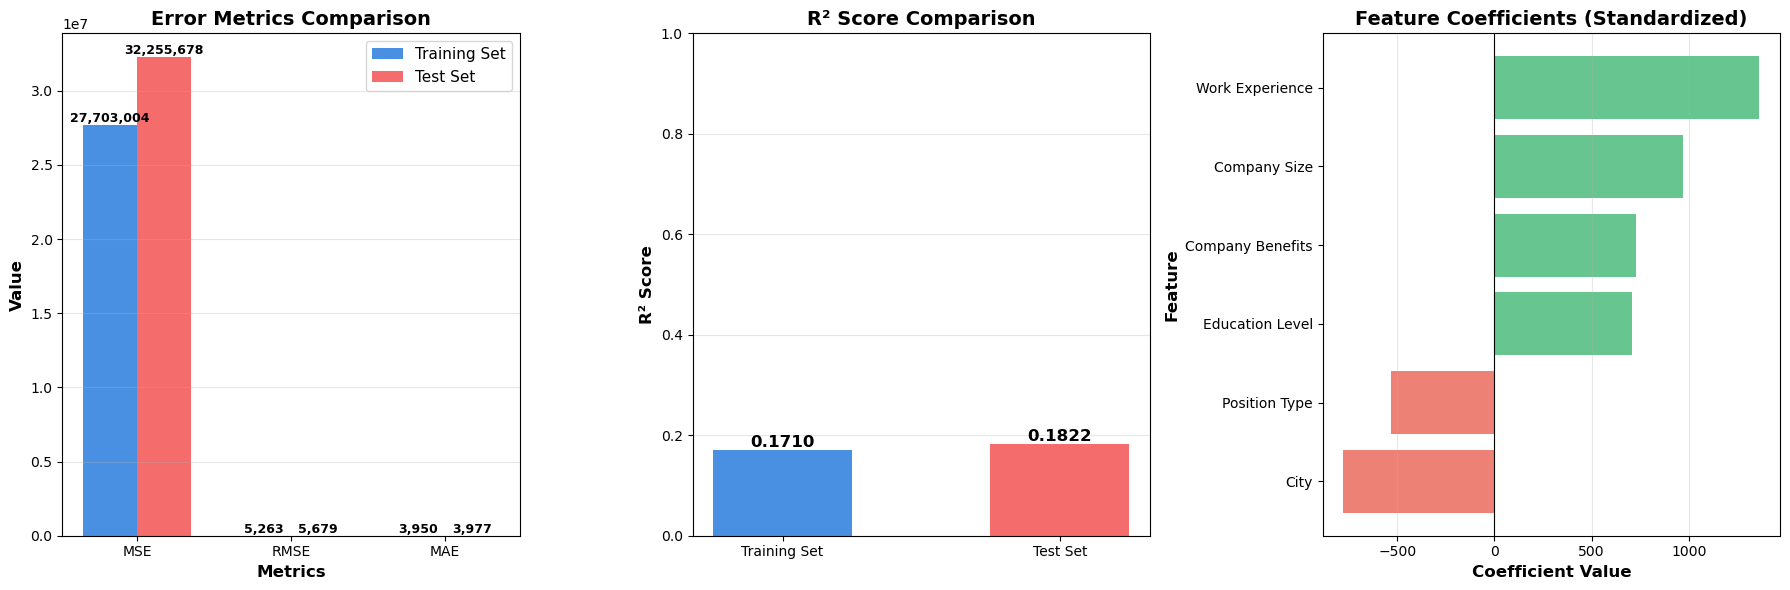

 Detailed metrics comparison saved as 'detailed_metrics_comparison.png'


In [23]:
# Create detailed metrics comparison plots
fig = plt.figure(figsize=(18, 6))

# 1. Error Metrics Comparison (MSE, RMSE, MAE)
ax1 = plt.subplot(1, 3, 1)
metrics = ['MSE', 'RMSE', 'MAE']
train_metrics = [train_mse, train_rmse, train_mae]
test_metrics = [test_mse, test_rmse, test_mae]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, train_metrics, width, label='Training Set', color='#4A90E2')
bars2 = plt.bar(x + width/2, test_metrics, width, label='Test Set', color='#F56C6C')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.title('Error Metrics Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. R² Score Comparison
ax2 = plt.subplot(1, 3, 2)
r2_scores = [train_r2, test_r2]
colors_r2 = ['#4A90E2', '#F56C6C']
bars = plt.bar(['Training Set', 'Test Set'], r2_scores, color=colors_r2, width=0.5)

plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.title('R² Score Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Feature Coefficients (Standardized)
ax3 = plt.subplot(1, 3, 3)
coef_sorted = importance_df.sort_values('Coefficient', ascending=True)
colors_coef = ['#E74C3C' if x < 0 else '#27AE60' for x in coef_sorted['Coefficient']]

plt.barh(coef_sorted['Feature Name'], coef_sorted['Coefficient'], color=colors_coef, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Coefficients (Standardized)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('detailed_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Detailed metrics comparison saved as 'detailed_metrics_comparison.png'")

7.2 Evaluation of Clustering

In [73]:
#Evaluation 1: City vs Anuual Salary
# Quantitative Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score

X = df[['city', 'annual_salary_equiv']].dropna()
labels = X_city['cluster']

sil_score = silhouette_score(X[['city','annual_salary_equiv']], labels)
db_score = davies_bouldin_score(X[['city','annual_salary_equiv']], labels)
print(f"Silhouette Score: {sil_score:.3f}, Davies-Bouldin: {db_score:.3f}")

Silhouette Score: 0.594, Davies-Bouldin: 0.523


In [74]:
# Statistical Evaluation 
X_city.groupby('cluster')['annual_salary_equiv'].agg(['count','mean','median'])

count           mean    median
cluster                                
0         1014  136238.165680  138000.0
1          621  244795.491143  240000.0
2           30  516916.666667  483750.0

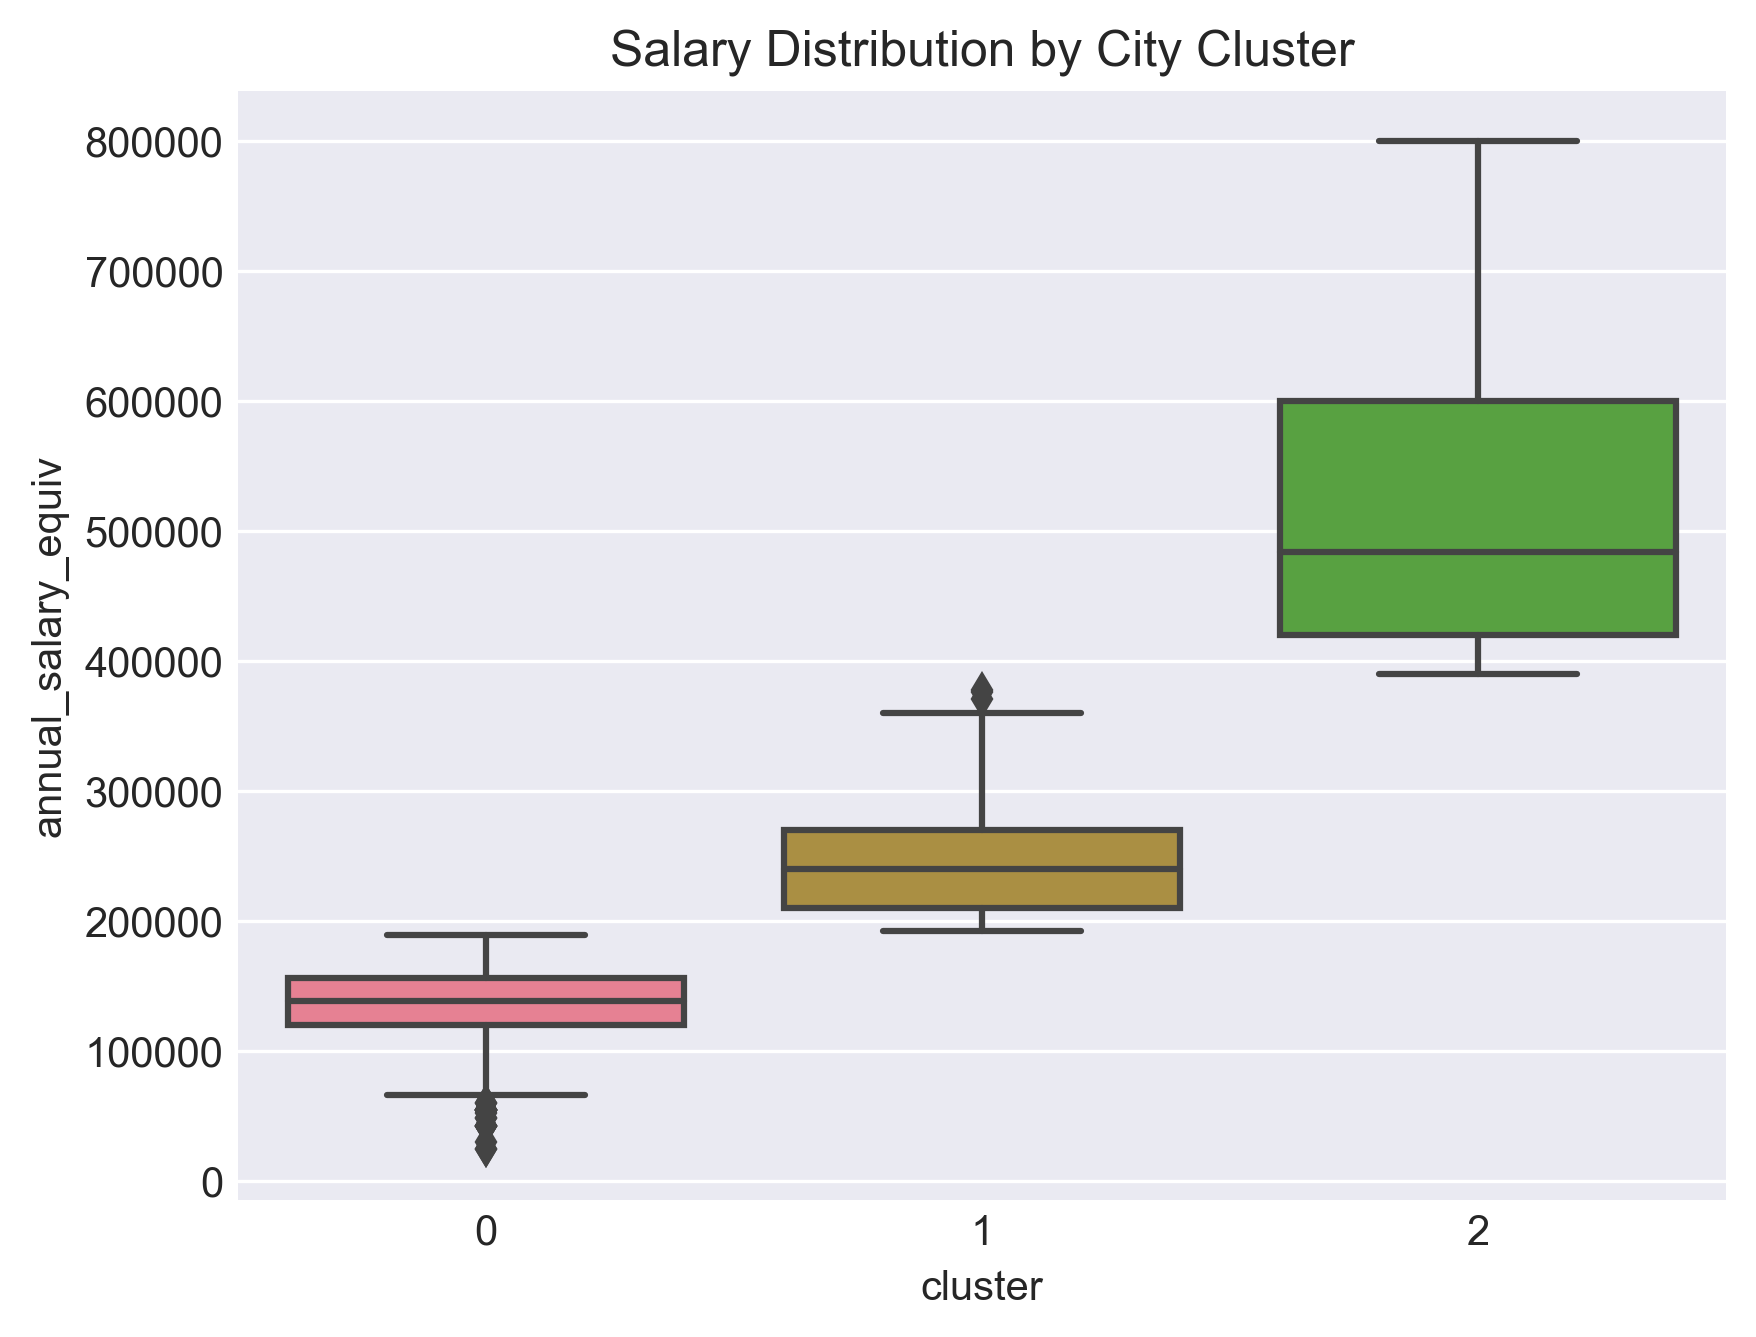

In [75]:
#Visualization Explanation
import seaborn as sns
sns.boxplot(x='cluster', y='annual_salary_equiv', data=X_city)
plt.title('Salary Distribution by City Cluster')
plt.show()

In [76]:
#Evaluation 2: Position vs Annual Salary
#Quantitative Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_pos = silhouette_score(X_position[['position_num','annual_salary_equiv']], X_position['cluster'])
db_pos = davies_bouldin_score(X_position[['position_num','annual_salary_equiv']], X_position['cluster'])

print(f"Silhouette Score: {sil_pos:.3f}, Davies-Bouldin Index: {db_pos:.3f}")

Silhouette Score: 0.594, Davies-Bouldin Index: 0.523


In [77]:
# Statistical Evaluation
X_position.groupby('cluster')['annual_salary_equiv'].agg(['count', 'mean', 'median'])

count           mean    median
cluster                                
0         1014  136238.165680  138000.0
1          621  244795.491143  240000.0
2           30  516916.666667  483750.0

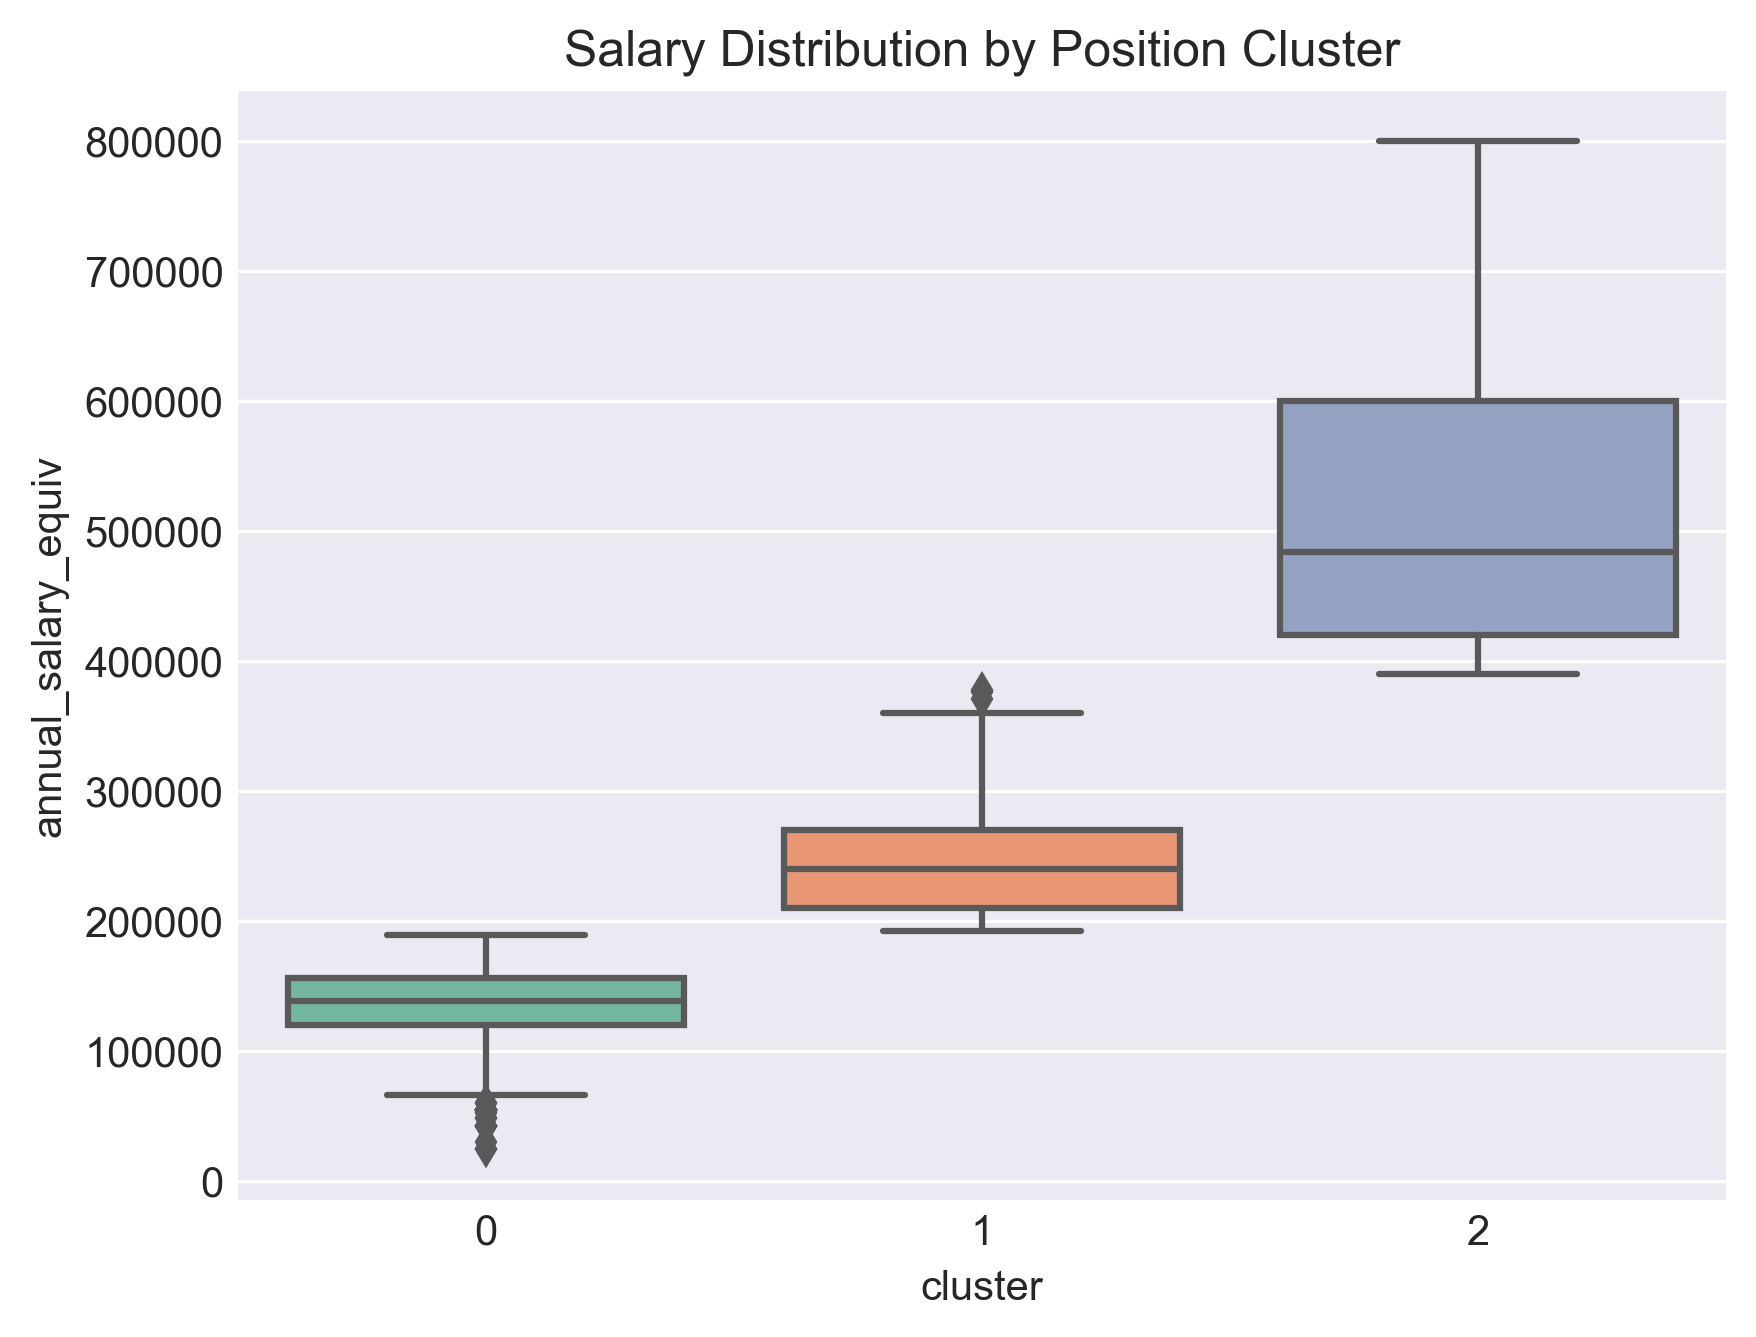

In [78]:
#Visualization Explanation
import seaborn as sns
sns.boxplot(x='cluster', y='annual_salary_equiv', data=X_position, palette='Set2')
plt.title('Salary Distribution by Position Cluster')
plt.show()

8. Conclusion

In [26]:
print("=" * 80)
print("KEY FINDINGS AND CONCLUSIONS")
print("=" * 80)

print("\n DATASET OVERVIEW:")
print(f"  • Total samples: {df_clean.shape[0]:,}")
print(f"  • Number of features: {len(feature_columns)}")
print(f"  • Training samples: {X_train.shape[0]:,} (80%)")
print(f"  • Testing samples: {X_test.shape[0]:,} (20%)")

print("\n MODEL PERFORMANCE:")
print(f"  • Test R² Score: {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"  • Test RMSE: {test_rmse:,.2f}")
print(f"  • Test MAE: {test_mae:,.2f}")
if abs(train_r2 - test_r2) < 0.05:
    print(f"  • Overfitting Status:  No significant overfitting detected")
elif abs(train_r2 - test_r2) < 0.1:
    print(f"  • Overfitting Status:  Slight overfitting detected")
else:
    print(f"  • Overfitting Status:  Overfitting detected")

print("\n FEATURE IMPORTANCE RANKING:")
for i, row in importance_df.iterrows():
    medal = "No.1" if row['Impact (%)'] == importance_df['Impact (%)'].max() else \
            "No.2" if row['Impact (%)'] == importance_df['Impact (%)'].nlargest(2).iloc[-1] else \
            "No.3"  if row['Impact (%)'] == importance_df['Impact (%)'].nlargest(3).iloc[-1] else "  "
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"  {medal} {row['Feature Name']:20s} - {row['Impact (%)']:5.2f}% {direction}")

print("\n KEY INSIGHTS:")
print(f"  1. The most influential factor is {importance_df.iloc[0]['Feature Name']}")
print(f"     accounting for {importance_df.iloc[0]['Impact (%)']:.2f}% of the total impact.")
print(f"\n  2. The top 3 factors ({importance_df.iloc[0]['Feature Name']}, ")
print(f"     {importance_df.iloc[1]['Feature Name']}, and {importance_df.iloc[2]['Feature Name']})")
print(f"     collectively account for {importance_df.iloc[:3]['Impact (%)'].sum():.2f}% of the impact.")
print(f"\n  3. Model explains {test_r2*100:.2f}% of salary variance in the test set.")

print("\n RECOMMENDATIONS:")
print("  • For job seekers: Focus on improving", importance_df.iloc[0]['Feature Name'])
print("    and", importance_df.iloc[1]['Feature Name'], "to maximize salary potential.")
print("  • For employers: Consider these factors when setting competitive salaries.")
if test_r2 < 0.5:
    print("  • Model improvement: Consider adding more features or trying non-linear models.")

print("\n" + "=" * 80)
print("Analysis completed successfully!")
print("=" * 80)

KEY FINDINGS AND CONCLUSIONS

 DATASET OVERVIEW:
  • Total samples: 1,665
  • Number of features: 6
  • Training samples: 1,332 (80%)
  • Testing samples: 333 (20%)

 MODEL PERFORMANCE:
  • Test R² Score: 0.1822 (18.22%)
  • Test RMSE: 5,679.41
  • Test MAE: 3,976.63
  • Overfitting Status:  No significant overfitting detected

 FEATURE IMPORTANCE RANKING:
  No.1 Work Experience      - 26.80% ↑
  No.2 Company Size         - 19.08% ↑
  No.3 City                 - 15.28% ↓
     Company Benefits     - 14.37% ↑
     Education Level      - 13.97% ↑
     Position Type        - 10.50% ↓

 KEY INSIGHTS:
  1. The most influential factor is Work Experience
     accounting for 26.80% of the total impact.

  2. The top 3 factors (Work Experience, 
     Company Size, and City)
     collectively account for 61.16% of the impact.

  3. Model explains 18.22% of salary variance in the test set.

 RECOMMENDATIONS:
  • For job seekers: Focus on improving Work Experience
    and Company Size to maximize s

In [27]:
# Export feature importance to CSV
importance_df[['Feature Name', 'Coefficient', 'Impact (%)']].to_csv(
    'feature_importance_results.csv', index=False
)

# Export model metrics to CSV
metrics_df.to_csv('model_evaluation_metrics.csv', index=False)

# Export test predictions
predictions_df = pd.DataFrame({
    'Actual_Salary': y_test.values,
    'Predicted_Salary': y_test_pred,
    'Residual': y_test.values - y_test_pred,
    'Absolute_Error': np.abs(y_test.values - y_test_pred)
})
predictions_df.to_csv('test_set_predictions.csv', index=False)

print(" Results exported successfully!")
print("\nExported files:")
print("  1. feature_importance_results.csv")
print("  2. model_evaluation_metrics.csv")
print("  3. test_set_predictions.csv")
print("  4. salary_regression_comprehensive_analysis.png")
print("  5. detailed_metrics_comparison.png")

 Results exported successfully!

Exported files:
  1. feature_importance_results.csv
  2. model_evaluation_metrics.csv
  3. test_set_predictions.csv
  4. salary_regression_comprehensive_analysis.png
  5. detailed_metrics_comparison.png
